In [2]:
import sys
from common import commons
home = commons.home
sys.path.append('/home/ec2-user/anaconda3/lib/python3.6/site-packages')
import pandas as pd
import numpy as np
from models import ModelSelection as MS
from models import Ensemble as es
from models import xgbooster
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.metrics import confusion_matrix,recall_score,precision_score,accuracy_score,f1_score,roc_curve,roc_auc_score,precision_recall_curve
import matplotlib.pyplot as plt
from sklearn import clone
from sklearn.externals import joblib
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from importlib import reload
from log import Logger
from models import deep_network_estimator as dne
from models import Ensemble_hyperopt as eh
from hyperopt import fmin,tpe,hp, STATUS_OK,Trials
from hyperopt_models import parallel_ensemble as pe
from functools import reduce
import itertools

In [3]:
def plot_curves_cv(probs,label,methods,types='roc_curve'):
    plt.figure(figsize=(7,5))
    plt.title(types)
    plt.axis([0,1,0,1])
    lw = 2
    colors = ['r','b','g','k','c','m','y']
    for method,color in zip(methods,colors[:len(methods)]):
        if types == 'precision_recall_curve':       
            precision,recall,threshold = precision_recall_curve(label,probs[method])
            plt.plot(recall,precision,color,linewidth=2,label=method)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
        if types == 'roc_curve':
            fpr,tpr, threshold = roc_curve(label,probs[method])
            plt.plot(fpr,tpr,color,linewidth=2,label=method)
            plt.xlabel('False Positive Rate')
            plt.ylabel('Recall')
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.legend(loc='best')


#----------------------------------------------------------------------------
def get_estimators(methods,params,train_x,train_label):
    ensemble = eh.Ensemble(methods,params)
    ensemble.fit(train_x,train_label,sample_weight=sample_weight_train,max_iter=100)
    return ensemble
#-----------------------------------------------------------------------------
def plot_curves(estimators,test_x,label,types='roc_curve'):
    plt.figure(figsize=(7,5))
    plt.title(types)
    plt.axis([0,1,0,1])
    lw = 2
    colors = ['r','b','g','k','c','m','y']
    for color,estimator in zip(colors[:len(estimators)],estimators):
        name = type(estimator).__name__
        probs = np.array(estimator.predict_proba(test_x))[:,1]
        if types == 'precision_recall_curve':       
            precision,recall,threshold = precision_recall_curve(label,probs)
            plt.plot(recall,precision,color,linewidth=2,label=name)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
        if types == 'roc_curve':
            fpr,tpr, threshold = roc_curve(label,probs)
            plt.plot(fpr,tpr,color,linewidth=2,label=name)
            plt.xlabel('False Positive Rate')
            plt.ylabel('Recall')
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.legend(loc='best')
#-----------------------------------------------------------------------------
def learn_curve(model,train_x,train_label,cv=3,scoring='neg_log_loss'):
    model_c = clone(model)
    N,train_score,test_score = learning_curve(model_c, 
                                            train_x,train_label,cv=cv,train_sizes=np.linspace(0.5,1,5),
                                            scoring=scoring)
    
    plt.figure(figsize=(7,4))
    plt.title('{}'.format(type(model).__name__))
    plt.plot(N,np.mean(train_score,1),color='blue', label='training score')
    plt.plot(N,np.mean(test_score,1),color='red',label='validation score')
    plt.xlabel('training sample')
    plt.ylabel(scoring)
    plt.legend(loc=0)
    plt.show()
#-----------------------------------------------------------------------------    
def error_analysis(estimator,test_x,label,types=['confusion_matrix']):
    print('Error analysis of ',type(estimator).__name__)
    predict = estimator.predict(test_x)
    probs = np.array(estimator.predict_proba(test_x))[:,1]
    class_num = len(label.unique())
    if 'confusion_matrix' in types:
        conf_mat = confusion_matrix(label,predict)
        row_sums = conf_mat.sum(axis=1,keepdims=True)
        norm_conf_mat = conf_mat/row_sums
        np.fill_diagonal(norm_conf_mat,0)
        plt.matshow(norm_conf_mat,cmap=plt.cm.gray)        
    if 'precision_recall_curve' in types and class_num<=2:
        precision,recall,threshold = precision_recall_curve(label,probs)
        plot_curve(recall,precision,type(estimator).__name__,'precision_recall_curve')
    if 'roc_curve' in types and class_num<=2:
        fpr,tpr, threshold = roc_curve(label,probs)
        plot_curve(fpr,tpr,type(estimator).__name__,'roc_curve')    
    plt.show()
#---------------------------------------------------------------------------    
def plot_curve(score1,score2,label,types):
    plt.figure(figsize=(7,5))
    plt.title(types)
    plt.plot(score1,score2,linewidth=2,label=label)
    plt.plot([0,1],[1,1],'k--')
    plt.axis([0,1,0,1])
    lw = 2
    if types == 'precision_recall_curve':        
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
    if types == 'roc_curve':
        plt.xlabel('False Positive Rate')
        plt.ylabel('Recall')
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#--------------------------------------------------------------------------
def scores(y,predicts,pred_probs,average='macro'):
    class_num = len(y.unique())
    score_map = {}

    if class_num <=2:
        recall = recall_score(y,predicts)      
        precision = precision_score(y,predicts)      
        accuracy = accuracy_score(y,predicts)
        f1 = f1_score(y,predicts)
        auc = roc_auc_score(y,pred_probs)
        score_map['auc'] = auc
    else:
        recall = recall_score(y,predicts,average=average)      
        precision = precision_score(y,predicts,average=average)      
        accuracy = accuracy_score(y,predicts)
        f1 = f1_score(y,predicts,average=average)
        
    score_map['recall'] = recall
    score_map['precision'] = precision
    score_map['accuracy'] = accuracy
    score_map['f1'] = f1
    return score_map

#---------------------------------------------------------------------------
def cross_val_ensemble(x,y,sample_weight,methods,params,fold=10, hyperopt=True,up_sampling=False):
    skfolds = StratifiedKFold(n_splits=10,random_state=43)
    results = []
    model_combine_scores_cv = []
    model_scores_cv = []
    best_params_cv = []
    cv_columns = ['label','ensemble']+methods
    pred_probs_cv = pd.DataFrame(columns=cv_columns)
    predicts_cv = pd.DataFrame(columns=cv_columns)
    if not hyperopt:
        search_methods = get_train_models(models=methods)
    class_num = len(y.unique())
    for train_index,test_index in skfolds.split(x,y):
        train_fold = x.ix[train_index,:]
        train_label = y[train_index]
        sample_weight_train = sample_weight[train_index]
        test_fold = x.ix[test_index,:]
        test_label = y[test_index]
        sample_weight_test = sample_weight[test_index]
        if up_sampling:
            train_fold,train_label,sample_weight_train = upsampling(train_fold,train_label,sample_weight_train,fold=9)
            test_fold,test_label,sample_weight_test = downsampling(test_fold,test_label,sample_weight_test)
        if not hyperopt:            
            for param_l in params.values():
                param = param_l[0]
                if 'sample_weight' in param:
                    param['sample_weight'] = [sample_weight_train,]
            ensemble = es.Ensemble(methods=search_methods,params=params)
            ensemble.fit(train_fold,train_label)            
        else:
            ensemble = eh.Ensemble(methods,params)
            ensemble.fit(train_fold,train_label,sample_weight=sample_weight_train,max_iter=100)
        score = ensemble.score(test_fold,test_label)
        results.extend([score])
        model_prob = ensemble.model_probs()
        model_preds = ensemble.model_predicts() 
        ensemble_prob = ensemble.predict_proba(test_fold)
        ensemble_pred = ensemble.predict(test_fold)
        
        temp_df = pd.DataFrame(columns=pred_probs_cv.columns)
        for method,prob in model_prob.items():
            temp_df[method] = prob[:,1]
            temp_df[method] = temp_df[method].astype('f')
        temp_df['ensemble'] = ensemble_prob[:,1]
        temp_df['ensemble'] = temp_df['ensemble'].astype('f')
        temp_df['label'] = test_label
        temp_df['label'] = temp_df['label'].astype('i8')
        pred_probs_cv = pred_probs_cv.append(temp_df,ignore_index=True)
        
        
        temp_df = pd.DataFrame(columns=predicts_cv.columns)
        for method,pred in model_preds.items():
            temp_df[method] = pred
            temp_df[method] = temp_df[method].astype('i8')
        temp_df['ensemble'] = ensemble_pred
        temp_df['ensemble'] = temp_df['ensemble'].astype('i8')
        temp_df['label'] = test_label
        temp_df['label'] = temp_df['label'].astype('i8')
        predicts_cv = predicts_cv.append(temp_df,ignore_index=True)
        
        comb_results = methods_combination_results(methods,model_prob,test_label)
        model_combine_scores_cv.extend([comb_results])
        model_score = ensemble.get_model_scores()
        model_scores_cv.extend([model_score.copy()])
        best_params = ensemble.best_params()
        best_params_cv.extend([best_params.copy()])
        all_estimators = list(ensemble.best_estimators_.values())
        all_estimators.extend([ensemble])
        plot_curves(all_estimators,test_fold,test_label,types='roc_curve')
        plot_curves(all_estimators,test_fold,test_label,types='precision_recall_curve')
        del ensemble
    if class_num == 2:
        result_df = pd.DataFrame(results,columns=['logloss','f1','recall','precision','auc_score'])
    else:
        result_df = pd.DataFrame(results,columns=['logloss','f1','recall','precision'])
    return result_df,model_combine_scores_cv,model_scores_cv,best_params_cv,pred_probs_cv,predicts_cv


#--------------------------------------------------------------------------------------------------------------------
def soft_voting(model_probs):
    pred_probs = reduce(lambda x,y: np.add(x,y), model_probs.values())/len(model_probs)
    print(pred_probs)
    predicts = np.argmax(pred_probs,axis=1)
    return pred_probs,predicts    

#------------------------------------------------------------------------------
def get_search_params(methods=['LogisticRegression','RandomForestClassifier','SVC','MLPClassifier','xgbooster','tensor_DNN']):
    params={}
    feature_num = train_x.shape[1]
    #class_weight = {0:1,1:30}
    class_weight = None
    l_param=[{'C':np.linspace(0.01, 20,20),'class_weight':[class_weight],'sample_weight':[sample_weights_train]}]
    rf_param = [{'n_estimators':np.linspace(10,500,5,dtype='i8'),'max_depth':np.linspace(5,30,6,dtype='i8'),'min_samples_split': np.linspace(3,30,5,dtype='i8'),'min_samples_leaf': np.linspace(1,10,10,dtype='i8'),'class_weight':[class_weight],'sample_weight':[sample_weights_train]}]
    svc_param = [{'C':np.linspace(0.01,0.2,5),'gamma':np.linspace(0.001,0.5,5),'class_weight':[class_weight],'sample_weight':[sample_weights_train]}]
    mlp_param = [{'alpha':np.linspace(0.001,5,10),'max_iter':[3000],'hidden_layer_sizes':[(100,80,50,25,10),(200,120,80,40),(300,200,100),(400,200)]}]
    xgb_param = [{'learning_rate':[0.1],'max_depth': np.linspace(3,21,6,dtype='i8'),'n_estimators':np.linspace(500,2000,5,dtype='i8'),'reg_lambda': np.linspace(1,50,10),'gamma':np.linspace(0.1,20,10),'class_weight':[class_weight],'sample_weight':[sample_weights_train],'search':['random',],'n_iter':[20] }]
    dnn_param = [{'batch_normalization': [True],
                 'l2_reg': np.linspace(0.01,5,5),                            
                 'drop_out':np.linspace(0.1,0.8,4),
                 'n_classes': [len(train_label.unique())],
                 'hidden_layers': [[int(feature_num*5),int(feature_num*3),int(feature_num*1)],[int(feature_num*4),int(feature_num*3),int(feature_num*2),int(feature_num*1)],[int(feature_num*3),int(feature_num*2.5),int(feature_num*2),int(feature_num*1.5),int(feature_num*1)],[int(feature_num*6),int(feature_num*3)]],
                 #'weight_factor':np.linspace(1,2,3),
                 'steps':np.linspace(200,2000,10,dtype='i8'),
                 'batch_size':[30],
                 'scoring':['precision'],
                 'sample_weight':[sample_weights_train],
                 'search':['random',],
                 'n_iter':[50]
                 }]
    if 'LogisticRegression' in methods:
        params['LogisticRegression'] = l_param
    if 'RandomForestClassifier' in methods:
        params['RandomForestClassifier'] = rf_param
    if 'SVC' in methods:
        params['SVC'] = svc_param
    if 'MLPClassifier' in methods:
        params['MLPClassifier'] = mlp_param
    if 'xgbooster' in methods:
        params['xgbooster'] = xgb_param
    if 'tensor_DNN' in methods:
        params['tensor_DNN'] = dnn_param
    return params
#-----------------------------------------------------------------------------------
def get_train_models(models=['LogisticRegression','RandomForestClassifier','SVC','MLPClassifier','xgbooster','tensor_DNN']):
    methods = []
    l = LogisticRegression()
    rf = RandomForestClassifier()
    svc = SVC()
    xg = xgbooster.xgbooster()
    mlp = MLPClassifier()
    dnn = dne.tensor_DNN()
    lsvc = LinearSVC()
    if 'LogisticRegression' in models:
        methods.extend([l])
    if 'RandomForestClassifier' in models:
        methods.extend([rf])
    if 'SVC' in models:
        methods.extend([svc])
    if 'MLPClassifier' in models:
        methods.extend([mlp])
    if 'xgbooster' in models:
        methods.extend([xg])
    if 'tensor_DNN' in models:
        methods.extend([dnn])
    if 'LinearSVC' in models:
        methods.extend([lsvc])
    return methods
 #------------------------------------------------------------------------------

def get_hyperopt_params(methods=['LogisticRegression','RandomForestClassifier','LinearSVC','SVC','xgbooster','tensor_DNN','MLPClassifier'],wtf_lo=1,wtf_hi=1):
    weight_factor = hp.uniform('weight_factor',wtf_lo,wtf_hi)
    params={}
    l_param = {'C': hp.uniform('C',0.05,20),'weight_factor':weight_factor}
    rf_param = {'n_estimators':100+hp.randint('n_estimators',900),'max_depth':5+hp.randint('max_depth',20), 'min_samples_split': 5+hp.randint('min_samples_split',15),'min_samples_leaf': 2+hp.randint('min_samples_leaf',4),'weight_factor':weight_factor}
    svc_param = {'C': hp.uniform('C',0.005,1),'gamma': hp.uniform('gamma',0.001,1),'probability':hp.choice('probability',[True]),'weight_factor':weight_factor}
    xgb_param = {'learning_rate':hp.choice('learning_rate',[0.1]),'max_depth': 5+hp.randint('max_depth',15),'n_estimators':500+hp.randint('n_estimators',2000),'reg_lambda': hp.uniform('reg_lambda',20,100),'gamma': hp.uniform('gamma',0.01,10),'weight_factor':weight_factor}
    dnn_param = {'batch_normalization': hp.choice('batch_normalization',[True]),
                 'l2_reg': hp.uniform('l2_reg',0.001,5),                            
                 'drop_out':hp.uniform('drop_out',0.1,0.8),
                 'weight_factor':weight_factor,
                 'steps':200+hp.randint('steps',1000),
                 'batch_size':hp.choice('batch_size',[30]),
                 'scoring':hp.choice('scoring',['precision']),
                 }
    mlp_param = {'alpha':hp.uniform('alpha',0.001,5),'max_iter':2000+hp.randint('max_iter',1000)}
    lsvc_param = {'C': hp.uniform('C',0.1,10),'weight_factor':weight_factor} 
    if 'LogisticRegression' in methods:
        params['LogisticRegression'] = l_param
    if 'RandomForestClassifier' in methods:
        params['RandomForestClassifier'] = rf_param
    if 'SVC' in methods:
        params['SVC'] = svc_param
    if 'xgbooster' in methods:
        params['xgbooster'] = xgb_param
    if 'tensor_DNN' in methods:
        params['tensor_DNN'] = dnn_param
    if 'MLPClassifier' in methods:
        params['MLPClassifier'] = mlp_param
    if 'LinearSVC' in methods:
        params['LinearSVC'] = lsvc_param
    return params    

#----------------------------------------------------------------------
def methods_combination_results(methods,model_probs,test_label):
    n = len(methods)
    results = {}
    for i in range(1,n+1):
        iterator = itertools.combinations(methods,i)
        for combination in iterator:
            key = reduce(lambda x,y: x+'-'+y,combination)
            print(key)
            test_model_probs = {method:prob for method,prob in model_probs.items() if method in combination}
            pred_probs,pred = soft_voting(test_model_probs)
            test_score = scores(test_label,pred,pred_probs[:,1])
            results[key] = test_score.copy()
    return results
#---------------------------------------------------------------------
def upsampling(train_x,train_label,sample_weights_train,fold=9):
    trainx = train_x.copy()
    trainx['label'] = train_label
    trainx['weight'] = sample_weights_train
    up_samples = commons.upSampling(trainx[trainx['label']==1],10)
    trainx = trainx.append(up_samples,ignore_index=True).sample(frac=1).reset_index(drop=True)
    train_label = trainx['label']
    sample_weights_train = trainx['weight']
    trainx = trainx.drop(['label','weight'],axis=1)
    return trainx,train_label,sample_weights_train

#------------------------------------------------------------------------
def downsampling(x,y,sample_weights):
    x = x.copy()
    x['label'] = y
    x['weight'] = sample_weights
    pos = x[x['label']==1]
    negs = x[x['label']==0].sample(pos.shape[0])
    alls = pos.append(negs,ignore_index=True)
    label = alls['label']
    weights = alls['weight']
    return alls.drop(['label','weight'],axis=1),label,weights
    

In [4]:
##features selecetd by traditional methods

dataset = 'RICHS'
up_sampling = True;
if up_sampling:
    wtf_lo = 0.05 if dataset=="RICHS" else 0.2
    wtf_hi = 0.1 if dataset=="RICHS" else 0.3
else:
    wtf_lo = 1.0/3 if dataset=="RICHS" else 1 
    wtf_hi = 0.5 if dataset=="RICHS" else 1.5
    
log_dir = home+'logs/'
logger = Logger.Logger(log_dir,False).get_logger()
with pd.HDFStore(home+'data/'+dataset+'/selected_features','r') as h5s:
    train_x =h5s['train_x'] 
    train_label = h5s['train_label'] 
    test_x = h5s['test_x'] 
    test_label = h5s['test_label']
    sample_weights_train = h5s['sample_weights_train'] 
    sample_weights_test = h5s['sample_weights_test']
logger.info('Features used in training are from traditional feature selection')

In [5]:
np.power(sample_weights_train,0.1).max()/np.power(sample_weights_train,0.1).min()

2.52346885918885

In [4]:
######upsampling train_x and train_label and decreasing sample_weight to 2:1
train_x,train_label,sample_weights_train = upsampling(train_x,train_label,sample_weights_train,fold=9)

In [5]:
train_x

CD4+_CD25-_CD45RO+_Memory_Primary_Cells-H3K27me3  Fetal_Heart-H3K27me3  \
0                                             0.000000              0.000000   
1                                             0.000000              0.023810   
2                                             0.000000              0.059524   
3                                             0.000000              0.011905   
4                                             0.282051              0.428571   
5                                             0.128205              0.059524   
6                                             0.000000              0.000000   
7                                             0.000000              0.011905   
8                                             0.051282              0.000000   
9                                             0.128205              0.035714   
10                                            0.307692              0.000000   
11                                            0.000000              0.011905   
12                                            0.000000              0.047619   
13                                            0.000000              0.023810   
14                                            0.000000              0.047619   
15                                            0.051282              0.000000   
16                                            0.000000              0.011905   
17                                            0.128205              0.023810   
18                                            0.076923              0.000000   
19                                            0.076923              0.130952   
20                                            0.307692              0.047619   
21                                            0.153846              0.154762   
22                                            0.051282              0.047619   
23                                            0.000000              0.011905   
24                                            0.000000              0.035714   
25                                            0.051282              0.000000   
26                                            0.000000              0.000000   
27                                            0.179487              0.000000   
28                                            0.000000              0.000000   
29                                            0.128205              0.047619   
...                                                ...                   ...   
5177                                          0.000000              0.047619   
5178                                          0.102564              0.357143   
5179                                          0.000000              0.083333   
5180                                          0.000000              0.047619   
5181                                          0.000000              0.000000   
5182                                          0.025641              0.011905   
5183                                          0.000000              0.000000   
5184                                          0.564103              0.226190   
5185                                          0.000000              0.000000   
5186                                          0.000000              0.023810   
5187                                          0.000000              0.011905   
5188                                          0.000000              0.119048   
5189                                          0.153846              0.440476   
5190                                          0.025641              0.000000   
5191                                          0.000000              0.023810   
5192                                          0.000000              0.000000   
5193                                          0.358974              0.261905   
5194                                          0.000000              0.000000   
5195  

In [13]:
##features selected by sparse autoencoder

dataset = 'AD_CpG'
log_dir = home+'logs/'
logger = Logger.Logger(log_dir,False).get_logger()
with pd.HDFStore(home+'data/'+dataset+'/new_features','r') as h5s:
    train_x =h5s['train_x'] 
    train_label = h5s['train_label'] 
    test_x = h5s['test_x'] 
    test_label = h5s['test_label']
    sample_weights_train = h5s['sample_weights_train'] 
    sample_weights_test = h5s['sample_weights_test']
logger.info('Features used in training are from sparse autoencoder')

OSError: ``/home/ec2-user/CpGPython/data/RICHS/new_features`` does not exist

[0]	train-logloss:0.68921	test-logloss:0.691635
[1]	train-logloss:0.685335	test-logloss:0.690115
[2]	train-logloss:0.681497	test-logloss:0.688677
[3]	train-logloss:0.677706	test-logloss:0.687286
[4]	train-logloss:0.673975	test-logloss:0.685842
[5]	train-logloss:0.670279	test-logloss:0.684488
[6]	train-logloss:0.66663	test-logloss:0.683248
[7]	train-logloss:0.663029	test-logloss:0.681926
[8]	train-logloss:0.659471	test-logloss:0.680728
[9]	train-logloss:0.655945	test-logloss:0.679526
[10]	train-logloss:0.652465	test-logloss:0.678264
[11]	train-logloss:0.649018	test-logloss:0.677021
[12]	train-logloss:0.645621	test-logloss:0.676119
[13]	train-logloss:0.642228	test-logloss:0.675009
[14]	train-logloss:0.638907	test-logloss:0.674127
[15]	train-logloss:0.635598	test-logloss:0.673049
[16]	train-logloss:0.632327	test-logloss:0.672022
[17]	train-logloss:0.629097	test-logloss:0.670806
[18]	train-logloss:0.625893	test-logloss:0.669781
[19]	train-logloss:0.622735	test-logloss:0.669014
[20]	train-l

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Tensor("IteratorGetNext:41", shape=(?,), dtype=float64)
Tensor("IteratorGetNext:41", shape=(?,), dtype=float64)
Tensor("IteratorGetNext:41", shape=(?,), dtype=float64)
Tensor("IteratorGetNext:41", shape=(?,), dtype=float64)
Tensor("IteratorGetNext:41", shape=(?,), dtype=float64)
Tensor("IteratorGetNext:41", shape=(?,), dtype=float64)
logistic


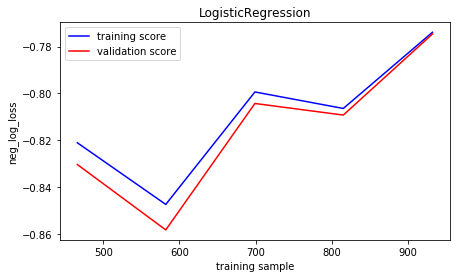

svm


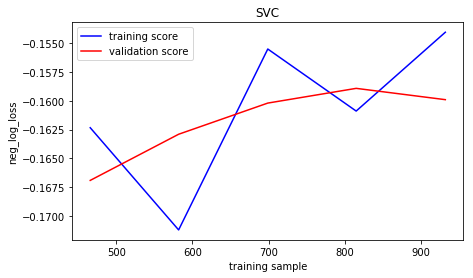

random_forest


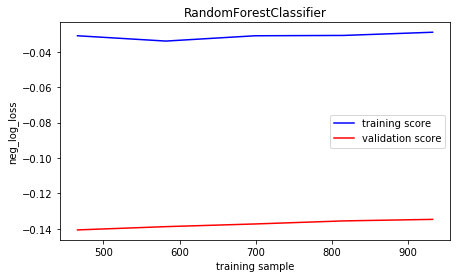

mlp


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations 

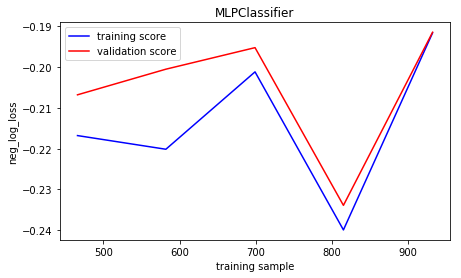

dnn
Tensor("IteratorGetNext:41", shape=(?,), dtype=float64)


NanLossDuringTrainingError: NaN loss during training.

In [9]:
#Cross-validation based model selection
score = 'neg_log_loss'
svm_params = {'C':0.01,'gamma':0.01}
mlp_params = {'alpha':100,'hidden_layer':(2000,1000,500) }
xgb_params = {'learning_rate':0.01,'lambda':100,'gamma':0.5}
log_params = {'C':0.01}
feature_num = train_x.shape[1]
model_select_weights = np.power(sample_weights_train,0.5) if dataset == 'RICHS' else np.power(sample_weights_train,1.5)
dnn_param = {
         'l2_reg': 0.01,                            
         'drop_out':0.5,
         'n_classes': len(train_label.unique()),
         'hidden_layers': [int(feature_num*50),int(feature_num*40),int(feature_num*30)],
         'steps':1000,
         'batch_size':30,
         'scoring':['precision'],
         'sample_weight':model_select_weights
         }
#class_weights = {0:1,1:30}
class_weights = None
select = MS.ModelSelection(scoring=score,class_weights={0:1,1:30},sample_weight=model_select_weights,
                           logistic_params=log_params,svm_params=svm_params,
                           mlp_params=mlp_params,xgboost_params=xgb_params,dnn_params=dnn_param)

model_scores = select.fit(train_x,train_label)
for name,estimator in select.estimators().items():
    print(name)
    learn_curve(estimator,train_x,train_label,scoring='neg_log_loss')

In [8]:
model_scores

{'LogisticRegression': -3.1792630191944715,
 'SVC': -0.16359364073944582,
 'RandomForestClassifier': -0.2775389956239192,
 'xgbooster': -0.7740347542000006,
 'MLPClassifier': -0.19227885849709064,
 'tensor_DNN': -0.9892064108147418}

In [4]:


#Model Hyperparameter tuning and Evaluation with GridSearch and RandomSearch
train_methods = ['LogisticRegression','RandomForestClassifier','SVC','xgbooster','tensor_DNN']
logger.info('Training ensemble model consists of: \n'+str(train_methods))
methods = get_train_models(models=train_methods)
params = get_search_params(methods=train_methods)
for key,param in params.items():
    param_cp = param[0].copy()
    if 'sample_weight' in param_cp:
        param_cp.pop('sample_weight')
    logger.info('%s searching hyperparameters: '+str(param_cp),key)
ensemble = search_hyperparameters(train_x,train_label,methods,params)
for key,best_param in ensemble.best_params_.items():
    logger.info('%s best parameters are: '+str(best_param),key)
pred = ensemble.predict(test_x)
print("predicted number of positives: {}".format((pred==1).sum()))
pred_probs = ensemble.predict_proba(test_x)
score = scores(test_label,pred,pred_probs[:,1])
logger.info('Ensemble prediction scores: '+str(score))
logger.info('The number of positive sample in test dataset: %d, in prediction: %d',(test_label==1).sum(),(pred==1).sum())



LogisticRegression
GridSearchCV
RandomForestClassifier
GridSearchCV


KeyboardInterrupt: 

In [ ]:
score

In [ ]:
search_model_probs = ensemble.model_probs()
test_methods = ['LogisticRegression']
test_model_probs = {method:prob for method,prob in search_model_probs.items() if method in test_methods}
pred_probs,pred = soft_voting(test_model_probs)
test_score = scores(test_label,pred,pred_probs[:,1])

In [ ]:
test_score

In [6]:
#Model hyperparameter tuning and evaluation with Hyperopt
methods = ['LogisticRegression','xgbooster']
params = get_hyperopt_params(methods,wtf_lo=wtf_lo,wtf_hi=wtf_hi)
ensemble_hyopt = eh.Ensemble(methods,params)
ensemble_hyopt.fit(train_x,train_label,sample_weight=sample_weights_train,max_iter=100)
pred = ensemble_hyopt.predict(test_x)
print("predicted number of positives: {}".format((pred==1).sum()))
pred_probs = ensemble_hyopt.predict_proba(test_x)
score = scores(test_label,pred,pred_probs[:,1])
logger.info('Hyperopt ensemble prediction scores: '+str(score))
logger.info('The number of positive sample in test dataset: %d, in prediction: %d',(test_label==1).sum(),(pred==1).sum())



0.09092042424441125
0.06754350665407668
0.05703260364051157
0.09478334078174716
0.09684664790179917
0.05782871770195679
0.05127913163264041
0.07519119644755279
0.07391839873840747
0.09513276014644932
0.07448898014825672
0.07769658030969967
0.0952924869977965
0.07235290054824976
0.06618348020197679
0.06777198809559425
0.05675144090673243
0.09653026166778608
0.07242239478114963
0.06806219708489883
0.08633400721885866
0.08775095633523822
0.08819764051945161
0.08202254713529042
0.0917348398141043
0.09964916520315181
0.09989619184003591
0.08104009620062955
0.09878225196752291
0.09908241515304436
0.09215566413856455
0.08502825748766198
0.09958075868658221
0.08990906949227165
0.0827848669279641
0.09315361260527595
0.061102261978066015
0.09859574665894974
0.050294605415349525
0.07945668831224993
0.08504078243220978
0.09038248872109164
0.08955543190669531
0.07692989647303794
0.09415269886299313
0.08977051109157909
0.08364530502602183
0.07983342276001777
0.09669683388549982
0.0717248153063632
0.

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08922226119159099
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.961883166611907, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1949, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.96716865406043, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.961883166611907, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1949, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.96716865406043, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.96188

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06760754142966728
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0342111583846547, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1595, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.15869671850695, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0342111583846547, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1595, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.15869671850695, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.034

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08133436318142215
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.94193619893878, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1610, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.73052791363534, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.94193619893878, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1610, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.73052791363534, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.941936198

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06806435479738841
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8214932725220008, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1824, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.12283653405634, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8214932725220008, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1824, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.12283653405634, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.821

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06876690137555574
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.45946855053054947, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 934, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.074175124460638, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.45946855053054947, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 934, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.074175124460638, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.459

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0512884754274628
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8620680299819696, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1641, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.898223807524104, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8620680299819696, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1641, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.898223807524104, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.86

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09158018053984635
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4516738108686618, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1453, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.47279828190232, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4516738108686618, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1453, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.47279828190232, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.45167

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0956619345960169
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6159552312618795, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1024, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.988368279257507, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6159552312618795, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1024, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.988368279257507, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6159

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.054959676732742824
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4280195665073535, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1516, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.663241732819856, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4280195665073535, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1516, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.663241732819856, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.42

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08744742027518121
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.293134755841201, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1493, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.99105270160838, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.293134755841201, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1493, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.99105270160838, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.29313

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07880570280713808
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.721337334769038, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1276, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.225433463206286, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.721337334769038, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1276, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.225433463206286, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.721

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05742088382215185
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.211001858874239, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1733, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.78856284226421, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.211001858874239, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1733, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.78856284226421, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.21100

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07449528593357352
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.40292106748656, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 640, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.88226655775892, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.40292106748656, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 640, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.88226655775892, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.40292106748

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08481678383130628
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.130955901610461, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 869, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.801238867388705, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.130955901610461, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 869, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.801238867388705, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.13095

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0792164124785385
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.015296044703353, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2398, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.5936145001448, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.015296044703353, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2398, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.5936145001448, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.0152960447

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07635006534406615
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.10591957635439, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2129, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.907213955278834, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.10591957635439, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2129, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.907213955278834, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.10591

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0688145873775196
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.17041834581586762, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1912, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.40470101549087, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.17041834581586762, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1912, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.40470101549087, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.17

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06735650516062341
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.733804578628575, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 727, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.59551193724391, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.733804578628575, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 727, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.59551193724391, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.7338045

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08661975726963272
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.060285285333309, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 708, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.190057905059476, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.060285285333309, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 708, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.190057905059476, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.06028

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.057175618770347984
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.30206196024173526, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1256, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.42523381622041, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.30206196024173526, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1256, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.42523381622041, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.30

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06087303080865298
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.773885145436532, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 919, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.37215656012096, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.773885145436532, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 919, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.37215656012096, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.7738851

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0506533290979386
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4118979384188124, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1516, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.89341289144943, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4118979384188124, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1516, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.89341289144943, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.411897

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06281148269285833
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2862239946273206, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 852, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.54971311759654, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2862239946273206, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 852, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.54971311759654, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.28622

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06256923566612413
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.65655317052406, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 852, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.70450535356406, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.65655317052406, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 852, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.70450535356406, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.656553170

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05490342532451143
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0048263438177436, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2198, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.348041603293257, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0048263438177436, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2198, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.348041603293257, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0634705136806521
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.076447995769981, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1997, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.88896427248127, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.076447995769981, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1997, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.88896427248127, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.07644799

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05399927213847679
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3951379278197518, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 636, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.142109027479446, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3951379278197518, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 636, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.142109027479446, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.395

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05819282299400913
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.129133927329799, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 822, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.24198729727454, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.129133927329799, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 822, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.24198729727454, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.129133927

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.051063385946438423
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.81329508537408, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1677, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.55278213499241, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.81329508537408, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1677, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.55278213499241, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.81329508

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0725928017113864
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.16008040882796498, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1096, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.13504900399309, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.16008040882796498, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1096, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.13504900399309, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.16

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0971723425090634
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9927632948599863, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1942, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.07748750927619, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9927632948599863, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1942, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.07748750927619, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9927

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07344528782026458
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.638644869179782, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1039, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.66318489908599, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.638644869179782, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1039, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.66318489908599, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.63864

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07164055139116897
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.369181654937377, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2193, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.60696340297729, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.369181654937377, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2193, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.60696340297729, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.36918

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08231329210313502
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.238460297348854, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1242, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.79434438765661, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.238460297348854, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1242, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.79434438765661, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.23846

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09242669055924543
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.907441653540545, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1854, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.36356683042338, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.907441653540545, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1854, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.36356683042338, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.90744

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06521300525371138
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.550214462311918, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1346, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.4992717483041, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.550214462311918, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1346, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.4992717483041, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5502144

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07237422417831516
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8151768153886372, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2031, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.532088693562386, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8151768153886372, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2031, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.532088693562386, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.815

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05383417279513235
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.157626046590879, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2167, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.96133124157598, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.157626046590879, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2167, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.96133124157598, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1576260

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0775881129723426
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8957971863957357, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1172, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.53232310680648, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8957971863957357, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1172, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.53232310680648, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8957

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09953956785487897
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5953759466049493, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2074, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.7325735961919, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5953759466049493, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2074, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.7325735961919, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5953759

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07031028858888969
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.10616103948363975, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2097, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.68511541093709, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.10616103948363975, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2097, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.68511541093709, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07033667606670636
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.533324522669738, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 594, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.51388444294638, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.533324522669738, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 594, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.51388444294638, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.5333245

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08066772405413997
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.455004877842069, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1264, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.245570486505066, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.455004877842069, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1264, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.245570486505066, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.455

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07582595983956247
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.7065611672800545, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1120, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.13832949374535, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.7065611672800545, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1120, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.13832949374535, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.706

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08308237815120785
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.194106542811084, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1849, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.526821421633755, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.194106542811084, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1849, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.526821421633755, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.194

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06570571663653889
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.11129608297405082, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 728, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.5164745808012, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.11129608297405082, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 728, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.5164745808012, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1112960

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09070002366301479
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.909841402017945, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2286, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.85644798276593, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.909841402017945, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2286, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.85644798276593, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.90984

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.059623132822358885
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7898051803045175, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 872, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.6744230316032, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7898051803045175, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 872, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.6744230316032, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.789805

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07052459596020574
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.979223438761966, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1759, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.52778970924502, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.979223438761966, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1759, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.52778970924502, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.97922

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06729172268118774
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8604661292612676, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2241, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.70944823818826, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8604661292612676, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2241, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.70944823818826, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.860

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08822260016331024
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1650082336535155, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2262, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.73239166751564, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1650082336535155, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2262, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.73239166751564, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.16500

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08531683650731997
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.638228310497519, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 671, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.397736250715276, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.638228310497519, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 671, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.397736250715276, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.63822

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07953569304534662
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8543652343845314, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 879, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.63413179054913, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8543652343845314, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 879, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.63413179054913, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8543652

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0756013113155904
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.714179458556658, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 693, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.1709988742437, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.714179458556658, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 693, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.1709988742437, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.7141794585

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07394810731871473
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.290181292515925, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1246, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.42504596703661, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.290181292515925, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1246, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.42504596703661, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.2901812

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07770620308733314
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4980840803660265, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1213, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.49922795480788, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4980840803660265, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1213, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.49922795480788, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.498

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06912572317366758
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.671385589026274, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 681, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.28827852303118, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.671385589026274, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 681, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.28827852303118, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.6713855

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06451239687314575
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5316002058197724, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1482, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.98567588246465, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5316002058197724, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1482, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.98567588246465, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.531

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08318228689590547
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3297943610516372, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 958, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.54033188231813, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3297943610516372, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 958, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.54033188231813, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.32979

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0937719025044442
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.378794075569021, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2030, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.56301056705576, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.378794075569021, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2030, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.56301056705576, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.378794

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05995204928748354
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1087769876442953, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1111, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.32797051676033, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1087769876442953, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1111, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.32797051676033, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.108

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06147519164236468
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.881549552613089, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1831, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.18211132440699, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.881549552613089, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1831, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.18211132440699, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.88154

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06688187026930792
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.264192683131823, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2422, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.89557325143932, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.264192683131823, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2422, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.89557325143932, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.26419

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05255115146750686
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.213417982654273, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 783, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.6984475854237, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.213417982654273, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 783, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.6984475854237, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.213417982

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.055629478516469245
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7352999848947555, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1777, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.06702259854424, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7352999848947555, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1777, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.06702259854424, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7352

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05673467376994985
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.43116745710866183, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1096, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.18974594853088, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.43116745710866183, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1096, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.18974594853088, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.431

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.058640142123293215
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2708542891217323, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1658, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.690654010655336, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2708542891217323, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1658, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.690654010655336, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.27

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06976334583888193
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2331909768602936, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2048, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.14053707828357, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2331909768602936, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2048, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.14053707828357, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.233

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07219687976941642
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1344484224269165, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 511, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.3195632651525, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1344484224269165, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 511, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.3195632651525, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.134448422

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07725492533115724
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9900834229691715, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1116, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.134768324092583, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9900834229691715, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1116, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.134768324092583, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06129050444521122
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1032770739821744, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1613, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.61517023398855, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1032770739821744, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1613, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.61517023398855, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.103

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06423928839063112
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.608761119666452, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1248, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.039384211384856, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.608761119666452, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1248, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.039384211384856, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.608

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06629506786679937
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5412292737538866, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1686, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.928712769646104, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5412292737538866, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1686, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.928712769646104, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06795782973819543
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6930318779742645, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1810, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.4837587420241, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6930318779742645, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1810, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.4837587420241, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.69303

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06200206534866655
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2747482150781292, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2480, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.92758029355275, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2747482150781292, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2480, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.92758029355275, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.27474

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07357568556284962
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.6383696468932, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1752, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.15133474941177, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.6383696468932, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1752, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.15133474941177, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.638369646

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.080870254053642
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.505621864541718, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2046, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.461801412853355, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.505621864541718, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2046, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.461801412853355, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.50562

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07900179627113303
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1272855650680251, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1507, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.08836318836812, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1272855650680251, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1507, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.08836318836812, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.12728

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07141570489996588
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8284421052072135, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2097, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.208751894920184, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8284421052072135, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2097, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.208751894920184, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06349314833869833
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.457509499253036, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1613, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.49279855023663, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.457509499253036, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1613, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.49279855023663, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.45750

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07510488673007384
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.856657340546763, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2282, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.46907924114667, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.856657340546763, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2282, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.46907924114667, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.85665

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05230037370346473
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.79966508379885, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 692, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.98495630776954, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.79966508379885, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 692, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.98495630776954, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.79966508379

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06855547199945414
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.11479755732029798, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 948, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.733747302540586, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.11479755732029798, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 948, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.733747302540586, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06071043081958332
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4689071903908546, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 598, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.953173381252164, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4689071903908546, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 598, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.953173381252164, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.468

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08494298705566944
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.699597730709847, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1055, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.620239753447805, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.699597730709847, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1055, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.620239753447805, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.699

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.056268923566834585
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0157941082931112, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2294, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.37607250463046, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0157941082931112, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2294, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.37607250463046, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.01

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05018599719205853
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.077544541012611, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 850, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.54871410222069, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.077544541012611, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 850, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.54871410222069, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.077544541

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07042230483903492
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5975880314579978, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 987, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.12347967686753, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5975880314579978, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 987, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.12347967686753, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.59758

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07284685183689955
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.539874068748215, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1822, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.27863065130298, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.539874068748215, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1822, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.27863065130298, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.53987

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07629327218700759
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.31701915111271, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2403, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.88723481220238, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.31701915111271, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2403, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.88723481220238, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3170191

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05824443747236125
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.11575273133640686, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 567, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.86393689571996, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.11575273133640686, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 567, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.86393689571996, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.11575

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06592895811238217
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.061390962488384, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 963, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.15900273647686, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.061390962488384, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 963, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.15900273647686, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.0613909

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07470885481717301
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4496078684813707, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1437, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.146573329529616, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4496078684813707, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1437, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.146573329529616, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.449

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06321811666345248
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8540278038661882, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2097, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.78470008965084, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8540278038661882, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2097, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.78470008965084, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.854

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06479410239930197
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.2909043535987434, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1515, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.20312110598732, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.2909043535987434, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1515, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.20312110598732, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.290

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05971756412040161
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.820599688053884, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 818, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.624459789485954, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.820599688053884, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 818, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.624459789485954, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.82059

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08203985593489475
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9115166367664993, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1651, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.68747444661019, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9115166367664993, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1651, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.68747444661019, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.911

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0871162437424871
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.433673228095291, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 802, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.12330420663707, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.433673228095291, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 802, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.12330420663707, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4336732280

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08001110840306638
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8783954508797127, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2236, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.29856681199998, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8783954508797127, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2236, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.29856681199998, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.878

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.1032770739821744, 'learning_rate': 0, 'max_depth': 8, 'n_estimators': 1113, 'reg_lambda': 53.61517023398855, 'weight_factor': 0.06129050444521122}
LogisticRegression,0.061832342058395814
xgbooster,0.06129050444521122
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1032770739821744, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1613, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.61517023398855, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'weight_factor': 0.06129050444521122}
predicted number of positives: 13


In [7]:
score

{'auc': 0.6439037153322869,
 'recall': 0.25,
 'precision': 0.5384615384615384,
 'accuracy': 0.9102990033222591,
 'f1': 0.3414634146341463}

In [33]:
score

{'auc': 0.6581632653061225,
 'recall': 0.14285714285714285,
 'precision': 1.0,
 'accuracy': 0.920265780730897,
 'f1': 0.25}

In [8]:
methods = ['LogisticRegression','xgbooster']
hyperopt_model_probs = ensemble_hyopt.model_probs()
comb_results = methods_combination_results(methods,hyperopt_model_probs,test_label)

LogisticRegression
[[0.39814132 0.60185868]
 [0.52627957 0.47372043]
 [0.37787075 0.62212925]
 [0.53353189 0.46646811]
 [0.51921893 0.48078107]
 [0.51771588 0.48228412]
 [0.37034216 0.62965784]
 [0.47032012 0.52967988]
 [0.54869716 0.45130284]
 [0.50676242 0.49323758]
 [0.49328748 0.50671252]
 [0.57055867 0.42944133]
 [0.3762133  0.6237867 ]
 [0.25571219 0.74428781]
 [0.41230214 0.58769786]
 [0.47168086 0.52831914]
 [0.4890662  0.5109338 ]
 [0.58192942 0.41807058]
 [0.36895305 0.63104695]
 [0.53453276 0.46546724]
 [0.49807669 0.50192331]
 [0.4019208  0.5980792 ]
 [0.44697319 0.55302681]
 [0.5572031  0.4427969 ]
 [0.47983502 0.52016498]
 [0.4904101  0.5095899 ]
 [0.53360223 0.46639777]
 [0.39579398 0.60420602]
 [0.38638142 0.61361858]
 [0.48221782 0.51778218]
 [0.43936758 0.56063242]
 [0.48148996 0.51851004]
 [0.54869235 0.45130765]
 [0.48021032 0.51978968]
 [0.34932051 0.65067949]
 [0.52302459 0.47697541]
 [0.44646215 0.55353785]
 [0.51953398 0.48046602]
 [0.49377063 0.50622937]
 [0.40

In [9]:
comb_results

{'LogisticRegression': {'auc': 0.6661433804290946,
  'recall': 0.8214285714285714,
  'precision': 0.12365591397849462,
  'accuracy': 0.4418604651162791,
  'f1': 0.21495327102803738},
 'xgbooster': {'auc': 0.6173469387755102,
  'recall': 0.21428571428571427,
  'precision': 0.6,
  'accuracy': 0.9136212624584718,
  'f1': 0.3157894736842105},
 'LogisticRegression-xgbooster': {'auc': 0.6439037153322869,
  'recall': 0.25,
  'precision': 0.5384615384615384,
  'accuracy': 0.9102990033222591,
  'f1': 0.3414634146341463}}

In [8]:
comb_results

{'LogisticRegression': {'auc': 0.6345321345321345,
  'recall': 0.18181818181818182,
  'precision': 0.4444444444444444,
  'accuracy': 0.9220338983050848,
  'f1': 0.2580645161290322},
 'RandomForestClassifier': {'auc': 0.647019647019647,
  'recall': 0.13636363636363635,
  'precision': 0.6,
  'accuracy': 0.9288135593220339,
  'f1': 0.22222222222222218},
 'SVC': {'auc': 0.7004662004662005,
  'recall': 0.09090909090909091,
  'precision': 0.6666666666666666,
  'accuracy': 0.9288135593220339,
  'f1': 0.16},
 'xgbooster': {'auc': 0.6003996003996004,
  'recall': 0.13636363636363635,
  'precision': 1.0,
  'accuracy': 0.9355932203389831,
  'f1': 0.24000000000000002},
 'LogisticRegression-RandomForestClassifier': {'auc': 0.6713286713286714,
  'recall': 0.13636363636363635,
  'precision': 1.0,
  'accuracy': 0.9355932203389831,
  'f1': 0.24000000000000002},
 'LogisticRegression-SVC': {'auc': 0.6436896436896438,
  'recall': 0.13636363636363635,
  'precision': 0.75,
  'accuracy': 0.9322033898305084,
 

In [74]:
test_score

{'auc': 0.8820709491850431,
 'recall': 0.42857142857142855,
 'precision': 0.75,
 'accuracy': 0.967948717948718,
 'f1': 0.5454545454545454}

In [10]:
for name,param in ensemble_hyopt.best_params().items():
    print (name)
    print(param)

LogisticRegression
{'C': 0.059523884841104824, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False, 'weight_factor': 0.061832342058395814}
xgbooster
{'gamma': 0.1032770739821744, 'learning_rate': 0.1, 'max_depth': 13, 'n_estimators': 1613, 'reg_lambda': 53.61517023398855, 'n_jobs': -1, 'weight_factor': 0.06129050444521122, 'objective': 'binary:logistic'}


Error analysis of  Ensemble


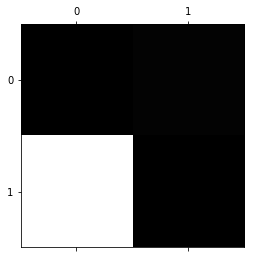

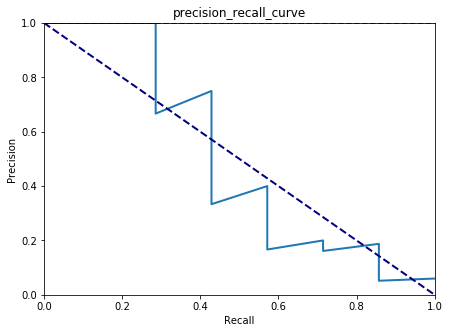

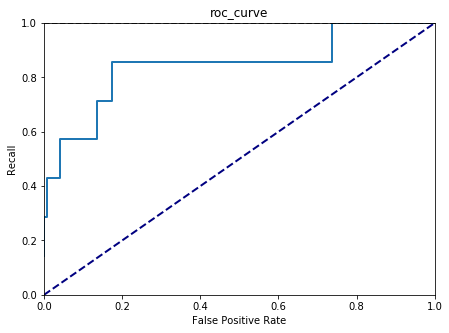

In [9]:
error_analysis(ensemble_hyopt,test_x,test_label,types=['roc_curve','precision_recall_curve','confusion_matrix'])

In [9]:
(test_label==1).sum()

28

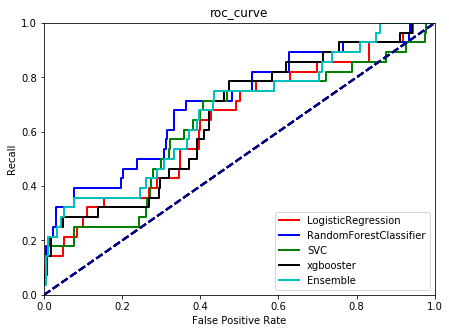

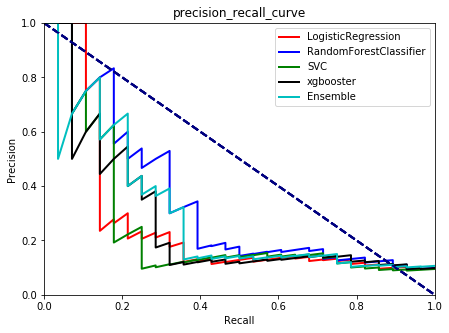

In [10]:
all_estimators = list(ensemble_hyopt.best_estimators_.values())
all_estimators.extend([ensemble_hyopt])
plot_curves(all_estimators,test_x,test_label,types='roc_curve')
plot_curves(all_estimators,test_x,test_label,types='precision_recall_curve')

Error analysis of  LogisticRegression


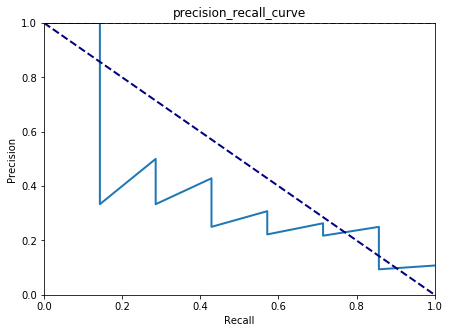

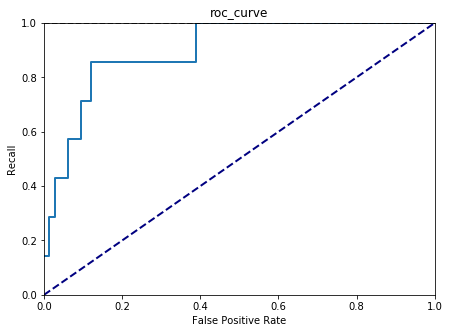

Error analysis of  RandomForestClassifier


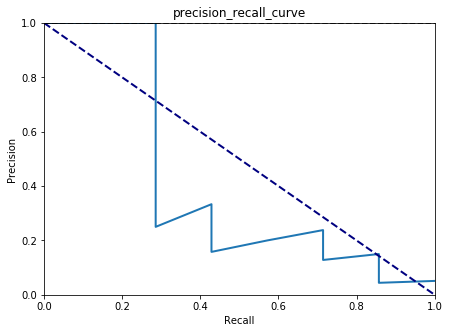

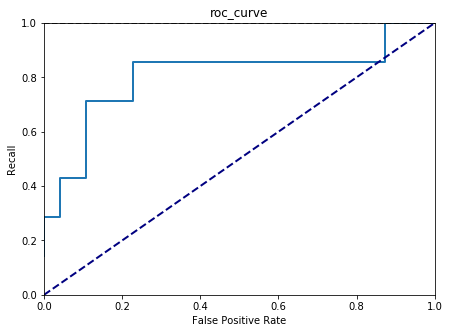

Error analysis of  SVC


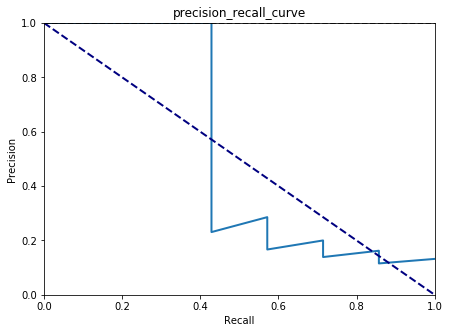

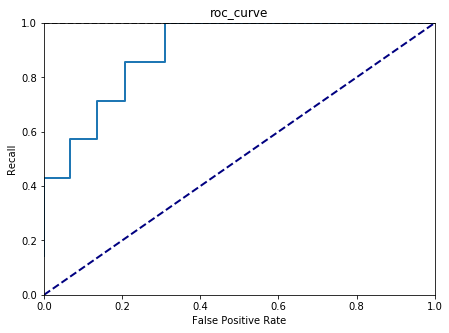

Error analysis of  xgbooster


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


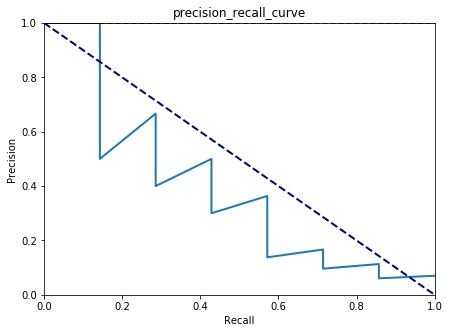

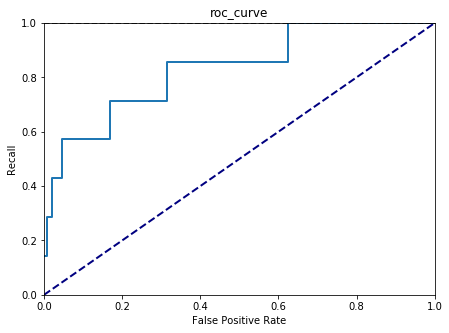

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [21]:
score_map={}
for name,estimator in ensemble_hyopt.best_estimators_.items():
    #learn_curve(estimator,train_x,train_label,scoring='precision')
    error_analysis(estimator,test_x,test_label,types=['roc_curve','precision_recall_curve'])
    estimator_preds = estimator.predict(test_x)
    estimator_pred_probs = estimator.predict_proba(test_x)
    score_map[name] = scores(test_label,estimator_preds,estimator_pred_probs)

In [22]:
for k in score_map:
    print('scores of '+k)
    print(score_map[k])

scores of LogisticRegression
{'auc': 0.861457334611697, 'recall': 0.8571428571428571, 'precision': 0.23076923076923078, 'accuracy': 0.8653846153846154, 'f1': 0.36363636363636365}
scores of RandomForestClassifier
{'auc': 0.6395014381591563, 'recall': 0.2857142857142857, 'precision': 0.6666666666666666, 'accuracy': 0.9615384615384616, 'f1': 0.4}
scores of SVC
{'auc': 0.700862895493768, 'recall': 0.42857142857142855, 'precision': 0.42857142857142855, 'accuracy': 0.9487179487179487, 'f1': 0.42857142857142855}
scores of xgbooster
{'auc': 0.6327900287631831, 'recall': 0.2857142857142857, 'precision': 0.4, 'accuracy': 0.9487179487179487, 'f1': 0.3333333333333333}


In [6]:
#10-fold test using the ensemble method
total_x = pd.concat([train_x,test_x],ignore_index=True)
total_label = pd.concat([train_label,test_label],ignore_index=True)
total_sample_weights = pd.concat([sample_weights_train,sample_weights_test],ignore_index=True)

In [7]:
total_sample_weights.max()/total_sample_weights.min()

10470.791144154728

0.06042516812025396
0.0932798472724047
0.058169312307150306
0.05219656259320792
0.06413045690846855
0.05115485333986807
0.0788915010415428
0.08006187819640444
0.06258567693461482
0.0983373035345614
0.05548419177609265
0.08689823449484313
0.07061502849322852
0.08184620447779359
0.08577786561286639
0.08583421722885246
0.07342285333937193
0.08488490405123861
0.09194015893484525
0.0866817084791294
0.06926931248028005
0.07613167693495573
0.07865003791612167
0.07544806253497906
0.06622442718055517
0.07479414384973791
0.06993142627753662
0.07530513708840543
0.09116384997897303
0.09673344912501654
0.06738691185821435
0.059417642223746236
0.07254874157923782
0.0768603785815953
0.08157067585876933
0.06297399803493041
0.05626471525140765
0.08886338422683725
0.06614494391540228
0.08281757813151142
0.0774798270046515
0.053621788817899696
0.07146597029079348
0.09468051836573435
0.06160017841972239
0.0832309193059463
0.06435287992835861
0.0796030423685162
0.09968046558086667
0.08880865102265302
0.075

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06663858284863704
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.166015961773609, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 691, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.38895647110068, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.166015961773609, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 691, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.38895647110068, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1660159

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09098107992135437
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.592578518332417, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2415, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.185848004481606, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.592578518332417, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2415, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.185848004481606, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.59257

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05761817969386834
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.87593611504947, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1200, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.15401326932339, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.87593611504947, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1200, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.15401326932339, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8759361

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07346156116627166
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1748452192139038, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1388, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.402778843916856, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1748452192139038, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1388, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.402778843916856, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07668245971963615
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.556441300520941, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 727, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.13856564435838, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.556441300520941, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 727, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.13856564435838, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.5564413

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08562351705677734
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1591746102662355, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1951, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.831684808137275, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1591746102662355, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1951, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.831684808137275, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09523839176088195
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.76546937175918, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 749, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.02301456394589, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.76546937175918, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 749, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.02301456394589, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.76546937175

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06667529762390938
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5855620620560105, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 620, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.294615885388545, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5855620620560105, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 620, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.294615885388545, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.585

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07607541239869864
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.386280076522229, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1993, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.804811931244167, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.386280076522229, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1993, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.804811931244167, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.38628

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0794363104023179
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.71116692301857, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1886, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.47269806533673, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.71116692301857, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1886, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.47269806533673, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.7111669230

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09017745992244999
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.428138241476753, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1534, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.62948536512776, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.428138241476753, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1534, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.62948536512776, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.42813

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07579266575758621
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.094684145618729, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1137, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.79114479704461, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.094684145618729, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1137, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.79114479704461, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.09468

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0894361677292472
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.936079048365114, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2243, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.11649935832439, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.936079048365114, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2243, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.11649935832439, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.93607904

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07140087919675417
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.791905042355734, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1838, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.72040894029061, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.791905042355734, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1838, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.72040894029061, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.79190

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07709436749294925
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.296239904109082, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 891, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.027961100515675, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.296239904109082, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 891, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.027961100515675, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2962399

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05548328049921214
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.069618090159378, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1596, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.80977835290032, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.069618090159378, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1596, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.80977835290032, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.0696180

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.060983906185055586
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.3816270408091, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 567, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.50442546314571, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.3816270408091, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 567, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.50442546314571, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.3816270408

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07440194866409504
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.040794436166354, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1989, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.51732809113036, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.040794436166354, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1989, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.51732809113036, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.04079

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05743336289151183
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.603776341942223, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2269, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.62632840414341, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.603776341942223, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2269, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.62632840414341, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.60377

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08378117559200256
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.24027637460261886, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2080, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.84171768602096, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.24027637460261886, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2080, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.84171768602096, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08284289244167417
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4740162308479223, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2080, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.15661790484923, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4740162308479223, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2080, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.15661790484923, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.474

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09916149759654203
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.322748969269033, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1828, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.08477079547816, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.322748969269033, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1828, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.08477079547816, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.32274

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0827847155812437
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07415167447023249, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2219, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.9290557294504, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07415167447023249, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2219, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.9290557294504, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0741

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0833890678891662
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.27546091296289527, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1954, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.96568878617305, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.27546091296289527, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1954, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.96568878617305, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2754

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09740757967709171
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.11185868906516505, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1873, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.10312830006767, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.11185868906516505, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1873, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.10312830006767, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09877536953233283
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7400290769568936, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1448, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.87446270965582, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7400290769568936, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1448, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.87446270965582, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.740

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09421444725680596
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.142818689331173, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2418, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.03864281050095, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.142818689331173, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2418, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.03864281050095, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.14281

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09624338998805992
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7626940755836495, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1328, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.1467273138633, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7626940755836495, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1328, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.1467273138633, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.76269

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08687254644783517
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.028370657264232, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1001, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.86844189679147, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.028370657264232, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1001, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.86844189679147, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.02837

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05039762592918355
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7070622549872518, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1076, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.04263764138386, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7070622549872518, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1076, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.04263764138386, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.707

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0683013644202157
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.265255379837935, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2401, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.96639847122834, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.265255379837935, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2401, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.96639847122834, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.265255

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07997922138730022
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.581719044177215, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2092, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.721788510281726, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.581719044177215, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2092, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.721788510281726, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.581

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06258956489463544
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.05163233884987, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1782, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.37426053739533, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.05163233884987, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1782, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.37426053739533, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.0516323

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09225550137599571
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.437826349106832, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 773, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.04406847911595, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.437826349106832, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 773, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.04406847911595, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4378263

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08844032919878804
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.291579322618845, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1715, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.650559814462355, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.291579322618845, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1715, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.650559814462355, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.29157

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09781995633737349
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01737378544403958, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1665, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.31597890098948, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01737378544403958, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1665, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.31597890098948, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09278715404057049
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.003082529885742, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2067, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.17757150194642, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.003082529885742, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2067, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.17757150194642, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.00308

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07984010227486024
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.286659938613354, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 606, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.29218806709619, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.286659938613354, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 606, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.29218806709619, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.2866599

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07062607492482775
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.716046404524489, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 693, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.92736508163254, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.716046404524489, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 693, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.92736508163254, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.716046404

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09979130296841875
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0665813544345366, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1965, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.80640073187776, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0665813544345366, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1965, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.80640073187776, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.06658

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08601202305994145
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.107702025550451, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1099, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.72061417572517, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.107702025550451, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1099, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.72061417572517, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.10770

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06506240366443526
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.011990690469395, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1093, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.24840954071063, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.011990690469395, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1093, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.24840954071063, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.01199

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07301936273123413
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6661617718619937, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2027, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.59011423240334, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6661617718619937, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2027, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.59011423240334, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.666

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.091624107100469
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7341058441249415, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1918, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.73170208025417, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7341058441249415, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1918, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.73170208025417, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7341058

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0814618919394825
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.702773450198666, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 706, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.67508079566474, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.702773450198666, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 706, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.67508079566474, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.70277345

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08886142739876696
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5461716538457044, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1554, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.71865458470154, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5461716538457044, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1554, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.71865458470154, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.546

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05156122242974943
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.902164574834932, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2341, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.6291995022552, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.902164574834932, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2341, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.6291995022552, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9021645

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0775455806201326
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.3050246807700185, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1284, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.76656518607162, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.3050246807700185, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1284, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.76656518607162, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.3050

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09481045213374639
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.5392202362059, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 899, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.957308290246274, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.5392202362059, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 899, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.957308290246274, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.53922023620

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06832895589223252
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.654282851514042, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 563, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.5525610320785, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.654282851514042, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 563, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.5525610320785, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.654282851

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08750807658861921
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03734443929154861, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 608, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.83926132658382, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03734443929154861, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 608, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.83926132658382, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03734

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08727519957114074
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.410655402655585, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1860, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.60501578329361, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.410655402655585, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1860, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.60501578329361, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4106554

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08518865118304643
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6973213560128754, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1955, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.47670850298797, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6973213560128754, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1955, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.47670850298797, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.69732

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09670177842086415
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.029661138743625, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 998, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.82510700930582, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.029661138743625, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 998, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.82510700930582, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.029661138

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08927843148668124
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4862109735142, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1430, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.38176764924877, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4862109735142, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1430, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.38176764924877, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.486210973

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09361096147956427
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.156645097881456, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1561, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.51132890449974, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.156645097881456, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1561, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.51132890449974, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1566450

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09804718828906998
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7419999716283305, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2222, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.02031206660826, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7419999716283305, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2222, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.02031206660826, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.741

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09058429767991097
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.53735309338997, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2018, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.85472519263877, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.53735309338997, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2018, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.85472519263877, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.537353093

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07860843206847117
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.195609907494067, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1302, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.06199962646747, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.195609907494067, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1302, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.06199962646747, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.19560

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0849852619906448
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.095634399777286, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1343, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.46182199377127, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.095634399777286, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1343, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.46182199377127, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.09563439

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07306849687679326
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8754118202849717, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2199, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.83631116691635, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8754118202849717, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2199, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.83631116691635, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.87541

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08192358347692866
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.423968337784926, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1728, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.52829390053938, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.423968337784926, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1728, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.52829390053938, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.42396

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09979234827703412
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5020611481714831, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 951, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.81137926131927, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5020611481714831, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 951, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.81137926131927, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.50206

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09548347050020066
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06397926906764972, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1385, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.04289489865417, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06397926906764972, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1385, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.04289489865417, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07491953257806477
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4144523254549739, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 608, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.538661765913, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4144523254549739, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 608, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.538661765913, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.414452325

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08073810311526908
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.957797430140087, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1680, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.0265481578656, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.957797430140087, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1680, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.0265481578656, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.957797430

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08403622516852756
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.039945172386015346, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 897, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.34030445809984, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.039945172386015346, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 897, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.34030445809984, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0876732272361134
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.468814168260902, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 856, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.70695729284635, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.468814168260902, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 856, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.70695729284635, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.46881416

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09097243180064754
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.031218316987203357, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 808, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.96543610474978, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.031218316987203357, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 808, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.96543610474978, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09018370256250141
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4562290320517284, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1540, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.44958350051331, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4562290320517284, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1540, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.44958350051331, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.456

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0844130778823349
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6453087723358617, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2320, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.70073599880295, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6453087723358617, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2320, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.70073599880295, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6453

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09320752952967234
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6208017815790519, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1657, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.35334002851368, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6208017815790519, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1657, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.35334002851368, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.620

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09128092175639013
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0490234592208894, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2061, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.2921656252738, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0490234592208894, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2061, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.2921656252738, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.04902

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09605439208226442
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1793027435531176, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 858, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.57367530530591, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1793027435531176, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 858, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.57367530530591, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.17930

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0983939919915693
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.022697892561387153, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 909, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.97324953575573, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.022697892561387153, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 909, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.97324953575573, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08628581163826003
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.074355654750282, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1309, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.88041375241946, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.074355654750282, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1309, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.88041375241946, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.07435

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07660551800538254
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8713428678381212, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1053, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.96369783938204, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8713428678381212, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1053, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.96369783938204, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.871

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08279896126026631
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8400333076734334, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 897, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.57866679329634, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8400333076734334, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 897, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.57866679329634, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8400333

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07838548928367166
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8496982982815393, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 637, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.51492419522998, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8496982982815393, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 637, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.51492419522998, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.84969

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09720015364516997
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.926403535384296, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 654, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.993430306591975, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.926403535384296, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 654, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.993430306591975, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.92640

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09451368301279671
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2552847516545625, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1665, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.1895970842366, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2552847516545625, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1665, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.1895970842366, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2552847

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09204217073037135
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2347743564117455, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 808, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.94730477349763, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2347743564117455, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 808, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.94730477349763, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.23477

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08417755812475242
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.259180853012084, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 621, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.88667675013245, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.259180853012084, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 621, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.88667675013245, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.259180853

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08817515753145866
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.245798101441473, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2445, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.27077490379942, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.245798101441473, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2445, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.27077490379942, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.2457981

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08930632872489638
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.03343554519662, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1881, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.17082906689116, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.03343554519662, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1881, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.17082906689116, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.0334355

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0717990604393226
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.541475320178513, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1752, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.949618036494314, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.541475320178513, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1752, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.949618036494314, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.5414

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06377353734306586
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.611447368832961, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1365, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.62672348026538, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.611447368832961, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1365, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.62672348026538, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.61144

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08157168315915017
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3829375161859647, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1355, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.79342491241016, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3829375161859647, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1355, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.79342491241016, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.382

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05949007498042261
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.699002726213667, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1138, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.58036184428635, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.699002726213667, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1138, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.58036184428635, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.69900

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06838473677489516
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.31748179668597626, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1547, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.342268509663256, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.31748179668597626, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1547, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.342268509663256, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09995606500752893
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9168580531436312, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 701, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.76832491009637, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9168580531436312, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 701, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.76832491009637, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.91685

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0938502820239687
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.594794122007644, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1725, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.36803443631, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.594794122007644, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1725, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.36803443631, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.59479412200764

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07564296170513227
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8914192410084671, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1444, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.82170846535817, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8914192410084671, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1444, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.82170846535817, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.891

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08655716642981162
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1316583280329753, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 961, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.267023274716593, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1316583280329753, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 961, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.267023274716593, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.13165

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.052926455234126785
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0107570816448872, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2272, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.99056628164706, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0107570816448872, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2272, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.99056628164706, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.056096283850100376
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4767370119243117, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2369, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.71352714249185, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4767370119243117, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2369, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.71352714249185, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.47

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05343059503638431
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2923573249764, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2038, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.916849330933815, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2923573249764, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2038, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.916849330933815, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2923573

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05990822229745644
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.207252139232785, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 805, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.11146323628721, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.207252139232785, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 805, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.11146323628721, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.2072521

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05007300010605434
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.747584441992823, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1369, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.91074323183048, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.747584441992823, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1369, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.91074323183048, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.74758

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.0107570816448872, 'learning_rate': 0, 'max_depth': 12, 'n_estimators': 1772, 'reg_lambda': 57.99056628164706, 'weight_factor': 0.052926455234126785}
LogisticRegression,0.07544806253497906
xgbooster,0.052926455234126785
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0107570816448872, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2272, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.99056628164706, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'weight_factor': 0.052926455234126785}


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

LogisticRegression
[[0.38114961 0.61885039]
 [0.56062469 0.43937531]
 [0.43715586 0.56284414]
 [0.3795986  0.6204014 ]
 [0.57815277 0.42184723]
 [0.37418341 0.62581659]
 [0.41726561 0.58273439]
 [0.35679829 0.64320171]
 [0.51798007 0.48201993]
 [0.56653105 0.43346895]
 [0.62292682 0.37707318]
 [0.90742892 0.09257108]
 [0.15765997 0.84234003]
 [0.29764502 0.70235498]
 [0.55561216 0.44438784]
 [0.44795768 0.55204232]
 [0.84189625 0.15810375]
 [0.49574911 0.50425089]
 [0.72534517 0.27465483]
 [0.41408548 0.58591452]
 [0.55693228 0.44306772]
 [0.46572744 0.53427256]
 [0.45730147 0.54269853]
 [0.45742864 0.54257136]
 [0.31902702 0.68097298]
 [0.51022364 0.48977636]
 [0.27212315 0.72787685]
 [0.54661404 0.45338596]
 [0.58167008 0.41832992]
 [0.59773864 0.40226136]
 [0.4508798  0.5491202 ]
 [0.32190065 0.67809935]
 [0.50112042 0.49887958]
 [0.55496394 0.44503606]
 [0.21299116 0.78700884]
 [0.75683724 0.24316276]
 [0.79475811 0.20524189]
 [0.56475351 0.43524649]
 [0.5826307  0.4173693 ]
 [0.40

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06201297642687689
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.640974291649876, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2195, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.7525607216402, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.640974291649876, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2195, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.7525607216402, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6409742

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06189020913776308
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3550196549468945, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2486, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.18197030294923, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3550196549468945, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2486, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.18197030294923, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.355

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07922655234485526
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.995460295496081, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1192, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.71269787416298, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.995460295496081, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1192, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.71269787416298, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.99546

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07671409958325462
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5035732544819879, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2044, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.012387136899726, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5035732544819879, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2044, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.012387136899726, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05827993900730452
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8479999802929125, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2474, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.33991290668287, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8479999802929125, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2474, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.33991290668287, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.84799

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06853085041497073
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6936461808675973, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 973, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.00504479565331, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6936461808675973, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 973, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.00504479565331, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.69364

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09978033311139928
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.819927245748511, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 853, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.56693523649066, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.819927245748511, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 853, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.56693523649066, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.819927245

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06748784003209699
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.906129090993082, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1909, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.8296555680237, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.906129090993082, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1909, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.8296555680237, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.906129090

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09806776504231095
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.255288854177121, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2149, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.30756564275808, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.255288854177121, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2149, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.30756564275808, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.25528

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07062163836471935
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.124709198069656, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1289, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.51015431835614, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.124709198069656, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1289, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.51015431835614, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.12470

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09532041733219636
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.69021101052945, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1493, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.07019828052464, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.69021101052945, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1493, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.07019828052464, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.6902110

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05857140174669375
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9463283672922531, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2326, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.5489766440163, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9463283672922531, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2326, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.5489766440163, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9463283

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05220462217804279
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.981519113812522, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1810, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.76578869787297, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.981519113812522, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1810, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.76578869787297, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.98151

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06025821253280497
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5686439555168065, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1016, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.11908287086224, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5686439555168065, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1016, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.11908287086224, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.56864

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06078216281165216
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.368399655686853, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1890, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.87805037581734, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.368399655686853, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1890, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.87805037581734, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.36839

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06586825038664473
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.623451175405142, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1533, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.011762277174164, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.623451175405142, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1533, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.011762277174164, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.623

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08519844053491912
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.380227185973208, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2140, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.78858285911299, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.380227185973208, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2140, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.78858285911299, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.3802271

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06045774025950501
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8683482336269992, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1174, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.137078068499314, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8683482336269992, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1174, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.137078068499314, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09172703089701259
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.378359582891231, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 592, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.979825802120345, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.378359582891231, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 592, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.979825802120345, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.37835

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07705676176354571
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8460840614695977, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1505, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.501403648582748, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8460840614695977, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1505, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.501403648582748, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05011889564565914
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9593203840082136, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1252, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.30076687121052, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9593203840082136, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1252, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.30076687121052, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.959

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08441377184896741
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1020189974501528, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1913, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.07766891855984, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1020189974501528, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1913, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.07766891855984, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.10201

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08360208836251591
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9725157558218678, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2039, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.98156243719076, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9725157558218678, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2039, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.98156243719076, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.97251

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0880763425659003
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.092262155112608, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2402, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.37368894302847, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.092262155112608, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2402, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.37368894302847, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.09226215

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08077536512911604
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.24146116306287446, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1550, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.2647549345498, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.24146116306287446, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1550, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.2647549345498, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.241

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0738100201015735
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7479282489985737, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 810, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.16814293027284, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7479282489985737, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 810, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.16814293027284, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.74792824

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08926400113257267
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07950949584496193, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1108, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.86927647672647, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07950949584496193, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1108, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.86927647672647, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09021475554583791
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.922228413947005, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2269, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.09051532567547, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.922228413947005, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2269, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.09051532567547, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.92222

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09409625316610405
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.82010517001281, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 979, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.75253729781657, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.82010517001281, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 979, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.75253729781657, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.820105170

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08646769583677802
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.08267829559953133, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 799, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.55771183484642, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.08267829559953133, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 799, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.55771183484642, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.082

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08776384541645879
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3728425566754585, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2353, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.00373472352055, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3728425566754585, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2353, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.00373472352055, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.372

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09670036536210774
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.448178820479909, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2018, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.97062274354481, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.448178820479909, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2018, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.97062274354481, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.44817

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09293208698707056
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5317591679837628, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1782, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.09413446577145, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5317591679837628, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1782, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.09413446577145, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.531

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08098773348009027
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4188895852445857, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2016, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.554011126871146, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4188895852445857, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2016, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.554011126871146, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0727672055883748
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03189465790850585, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1740, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.24819993912035, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03189465790850585, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1740, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.24819993912035, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07371410070026689
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.95467365658821, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2054, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.83331359480744, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.95467365658821, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2054, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.83331359480744, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.9546736

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07103638915708145
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9984166204179756, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 531, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.1776288670188, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9984166204179756, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 531, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.1776288670188, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9984166

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05523988368515627
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2095048323453463, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1587, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.14152654831511, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2095048323453463, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1587, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.14152654831511, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.209

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06372558147215751
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4020537449588346, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1443, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.17944346191292, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4020537449588346, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1443, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.17944346191292, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.40205

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0768394647689898
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02646706617333816, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1277, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.653396855794846, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02646706617333816, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1277, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.653396855794846, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07631868745365983
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.347709942088585, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2386, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.60105456348543, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.347709942088585, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2386, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.60105456348543, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.34770

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0647512745750304
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.758034772786656, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1598, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.50578942000897, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.758034772786656, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1598, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.50578942000897, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.758034

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07064542046787019
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.863084238045283, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2178, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.65770825546187, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.863084238045283, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2178, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.65770825546187, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.86308

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06903317764023247
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.277229955662253, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 989, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.71544025011636, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.277229955662253, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 989, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.71544025011636, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.2772299

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07844668914295364
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.46362885634688467, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 951, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.12232879145488, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.46362885634688467, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 951, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.12232879145488, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.46362

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08226443886926425
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6875828712268697, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1146, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.35808832067602, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6875828712268697, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1146, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.35808832067602, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.687

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07342060810716713
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4265750093724137, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1740, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.85965512786349, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4265750093724137, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1740, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.85965512786349, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.426

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.055962754142888135
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9778800519659012, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 879, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.91243458715812, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9778800519659012, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 879, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.91243458715812, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9778

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06638856765425294
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7228833639648631, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2332, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.51358261500499, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7228833639648631, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2332, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.51358261500499, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.72288

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06274004386076922
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9981945842845058, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1776, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.61180206473296, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9981945842845058, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1776, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.61180206473296, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.99819

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0788770565994366
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9531559395484734, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1324, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.88358104874963, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9531559395484734, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1324, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.88358104874963, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9531

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06838044869835028
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.615775564835692, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2241, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.860541119741114, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.615775564835692, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2241, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.860541119741114, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.615

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07566749475850187
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.778884712412578, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1692, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.27912071535708, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.778884712412578, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1692, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.27912071535708, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.7788847

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07154648208207291
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.490581812414512, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2362, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.91238126233375, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.490581812414512, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2362, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.91238126233375, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.49058

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05555887926187436
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.42027989130236143, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 813, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.40543980758068, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.42027989130236143, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 813, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.40543980758068, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.420

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08044090634105339
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.292129669711081, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1520, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.4544583451914, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.292129669711081, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1520, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.4544583451914, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2921296

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.057773484569346445
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.588490673812479, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1561, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.21280151029606, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.588490673812479, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1561, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.21280151029606, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.5884

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07257060905884838
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.625601693882746, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2328, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.73640915791641, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.625601693882746, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2328, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.73640915791641, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.62560

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08274299482716034
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.361717322991908, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1069, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.18608717422077, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.361717322991908, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1069, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.18608717422077, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.3617173

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09886111582909154
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.673259002967894, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1125, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.331798804066224, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.673259002967894, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1125, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.331798804066224, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.673

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.052054688981486935
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2688866923866038, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1366, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.38883720933079, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2688866923866038, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1366, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.38883720933079, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2688

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06728181202001203
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.13493454340377, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1930, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.92149437925879, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.13493454340377, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1930, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.92149437925879, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.1349345

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08603227166907282
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.682550295738442, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2436, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.9478376295721, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.682550295738442, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2436, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.9478376295721, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.682550295

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07769438965701986
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.50147626745596, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2041, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.67723496333537, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.50147626745596, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2041, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.67723496333537, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.5014762

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09105828514148595
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.21262871923180285, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 998, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.762054067054294, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.21262871923180285, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 998, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.762054067054294, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08630093699526634
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.010168083474624466, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1041, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.18819418220254, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.010168083474624466, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1041, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.18819418220254, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08433595557248874
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8646995785893828, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2021, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.210716541834174, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8646995785893828, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2021, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.210716541834174, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07515556647541544
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6356794821531166, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 567, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.425588198931266, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6356794821531166, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 567, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.425588198931266, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.63567

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08808423084339038
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1156041686469504, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2228, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.663265922183655, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1156041686469504, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2228, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.663265922183655, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08008564308276239
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5129066561780675, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2255, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.676303525252635, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5129066561780675, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2255, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.676303525252635, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09512261541097869
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.463163872913607, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1856, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.411197347619122, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.463163872913607, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1856, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.411197347619122, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.463

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08194527713426669
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.016204177290125705, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2309, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.76296809350023, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.016204177290125705, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2309, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.76296809350023, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06969259392224725
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.228109150556323, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 956, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.39231826351008, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.228109150556323, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 956, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.39231826351008, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2281091

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08649686910428901
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6698853819245735, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1725, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.86587421947955, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6698853819245735, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1725, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.86587421947955, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.669

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09303709699034345
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9978335419689888, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 583, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.462823484768286, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9978335419689888, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 583, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.462823484768286, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.997

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07707556057495447
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.214965614080726, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 760, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.92842029205275, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.214965614080726, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 760, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.92842029205275, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.2149656

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08945194967847926
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.35453348622582315, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1367, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.6579236351819, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.35453348622582315, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1367, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.6579236351819, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.354

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07468853889433932
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3398752929322426, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1419, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.34506698489595, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3398752929322426, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1419, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.34506698489595, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.339

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08379312265939723
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8414876559682096, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 933, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.960320434350564, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8414876559682096, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 933, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.960320434350564, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.841

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06553753829439377
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0049688338054157, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1767, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.41724973167314, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0049688338054157, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1767, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.41724973167314, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.00496

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07227537679573158
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.955989351685451, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1818, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.04427014332857, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.955989351685451, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1818, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.04427014332857, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.95598

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07937037676521737
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.143264383599746, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 914, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.43638166558145, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.143264383599746, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 914, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.43638166558145, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.143264383

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09681645282571431
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.894686830937953, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1122, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.37049836831571, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.894686830937953, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1122, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.37049836831571, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.8946868

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06169618696582603
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.023954474979113505, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1296, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.70992853348248, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.023954474979113505, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1296, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.70992853348248, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05919659162720174
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7693627972505609, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1903, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.73550233595416, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7693627972505609, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1903, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.73550233595416, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.769

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05201952557158911
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1208739871479727, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1981, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.26239668866957, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1208739871479727, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1981, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.26239668866957, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.120

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05356554545568982
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5485017123038785, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2313, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.44598979619846, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5485017123038785, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2313, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.44598979619846, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.548

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.061599130133885974
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.767766443209838, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 959, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.45409651743029, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.767766443209838, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 959, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.45409651743029, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.767766

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05745392630428436
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4933824819389534, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 655, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.41086500583702, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4933824819389534, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 655, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.41086500583702, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.49338

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08540666747846717
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.019640626325818377, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2084, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.303650404376505, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.019640626325818377, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2084, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.303650404376505, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06284734650069115
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.24984527349241237, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2170, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.59074351596119, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.24984527349241237, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2170, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.59074351596119, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06425979646297633
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1346759170766303, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2361, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.63096288612739, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1346759170766303, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2361, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.63096288612739, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.134

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0811801624490747
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.281650981382185, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2190, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.78236753472966, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.281650981382185, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2190, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.78236753472966, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.28165098

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09180841130565612
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7990024814453496, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1570, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.49107791519049, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7990024814453496, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1570, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.49107791519049, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.799

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06971321168458183
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5783222694295554, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1284, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.2516719694829, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5783222694295554, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1284, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.2516719694829, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.57832

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08757073634998737
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7607627266587658, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1529, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.538630479366663, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7607627266587658, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1529, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.538630479366663, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09993426196432179
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.03787351546252, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 824, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.77535391119524, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.03787351546252, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 824, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.77535391119524, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.037873515

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06708177178355035
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.134999387863852, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2126, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.575320529325186, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.134999387863852, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2126, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.575320529325186, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.134

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05088758709873184
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.129823175395652, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 728, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.833528471784305, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.129823175395652, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 728, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.833528471784305, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.12982

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.02646706617333816, 'learning_rate': 0, 'max_depth': 13, 'n_estimators': 777, 'reg_lambda': 63.653396855794846, 'weight_factor': 0.0768394647689898}
LogisticRegression,0.09809631888471342
xgbooster,0.0768394647689898
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02646706617333816, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1277, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.653396855794846, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'weight_factor': 0.0768394647689898}


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

LogisticRegression
[[0.43424614 0.56575386]
 [0.49505711 0.50494289]
 [0.26394953 0.73605047]
 [0.67486803 0.32513197]
 [0.38993811 0.61006189]
 [0.11645379 0.88354621]
 [0.49702055 0.50297945]
 [0.12531349 0.87468651]
 [0.34740727 0.65259273]
 [0.40993136 0.59006864]
 [0.52175534 0.47824466]
 [0.45175806 0.54824194]
 [0.41376988 0.58623012]
 [0.47360435 0.52639565]
 [0.51547342 0.48452658]
 [0.18616584 0.81383416]
 [0.56888228 0.43111772]
 [0.50616588 0.49383412]
 [0.32850603 0.67149397]
 [0.29563558 0.70436442]
 [0.20729773 0.79270227]
 [0.28472427 0.71527573]
 [0.55314901 0.44685099]
 [0.36268729 0.63731271]
 [0.30848229 0.69151771]
 [0.11962778 0.88037222]
 [0.58213374 0.41786626]
 [0.56272314 0.43727686]
 [0.54969417 0.45030583]
 [0.53267363 0.46732637]
 [0.36988215 0.63011785]
 [0.62854903 0.37145097]
 [0.49310505 0.50689495]
 [0.40004103 0.59995897]
 [0.60270136 0.39729864]
 [0.42350417 0.57649583]
 [0.24761495 0.75238505]
 [0.06866911 0.93133089]
 [0.57756823 0.42243177]
 [0.57

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09992223359354226
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4061891649566227, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1132, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.68545549238917, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4061891649566227, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1132, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.68545549238917, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.40618

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06805968949009916
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.238882604430963, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1034, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.28736117263004, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.238882604430963, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1034, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.28736117263004, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.23888

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05182795876157245
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4377532213162711, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1515, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.74549713474691, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4377532213162711, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1515, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.74549713474691, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.43775

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05919741996127167
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.4958581856486255, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2486, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.44294294334999, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.4958581856486255, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2486, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.44294294334999, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.495

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.054250624185222134
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.623128590899306, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1219, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.97558120734795, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.623128590899306, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1219, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.97558120734795, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.6231

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06050459347182236
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.80172659797309, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1919, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.10987882552756, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.80172659797309, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1919, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.10987882552756, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.8017265

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08792177530288652
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.731298615838938, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1670, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.03014268069961, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.731298615838938, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1670, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.03014268069961, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.7312986

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09507212915163772
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.408322722958998, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 803, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.5975034121649, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.408322722958998, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 803, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.5975034121649, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.408322722

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05609908377885887
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.43482301566686, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2245, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.49661863135162, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.43482301566686, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2245, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.49661863135162, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.4348230

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07972887276136972
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.332584437801378, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1563, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.35593045113833, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.332584437801378, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1563, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.35593045113833, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.33258

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08734897616105111
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.429776085721466, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1651, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.94738257343077, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.429776085721466, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1651, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.94738257343077, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.42977

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07497013224505625
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0623410388988521, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 868, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.78087479292526, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0623410388988521, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 868, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.78087479292526, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.06234

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06894332838455197
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0322744993576265, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 661, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.708062944104263, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0322744993576265, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 661, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.708062944104263, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.032

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06330083146746573
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7902065041092907, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1575, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.21022820061938, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7902065041092907, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1575, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.21022820061938, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.790

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09353085266514023
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.534267142564236, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1928, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.26847579290859, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.534267142564236, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1928, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.26847579290859, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.5342671

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08850854733427177
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.713048601506298, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1970, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.70302468052577, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.713048601506298, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1970, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.70302468052577, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.71304

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07452376894390994
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3001674381695989, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1373, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.02727786894879, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3001674381695989, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1373, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.02727786894879, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.300

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.057967337490566595
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.621109172856429, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2048, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.18532800113114, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.621109172856429, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2048, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.18532800113114, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.6211

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08464259077493877
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.131418864271305, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2339, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.446403171905665, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.131418864271305, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2339, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.446403171905665, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.13141

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.050061269641274275
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.988232212372366, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 595, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.20363412558089, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.988232212372366, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 595, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.20363412558089, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.988232

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06635521365519507
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8376044018359208, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 632, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.266636495780475, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8376044018359208, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 632, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.266636495780475, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.837

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07007881010047821
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.968789765192258, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1878, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.02435279487118, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.968789765192258, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1878, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.02435279487118, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.96878

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05193937043161505
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2667561041923001, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1772, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.118005372834936, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2667561041923001, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1772, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.118005372834936, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.266

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08152915410773885
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.939882048701417, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 964, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.6998974412466, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.939882048701417, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 964, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.6998974412466, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.93988204870

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06395078292000372
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.856286116459383, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 565, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.50493632436868, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.856286116459383, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 565, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.50493632436868, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.856286116

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07074959004828395
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1601521703881628, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2404, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.13394534388232, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1601521703881628, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2404, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.13394534388232, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.160

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05046665754915832
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.054932567325479326, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2318, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.36987654817819, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.054932567325479326, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2318, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.36987654817819, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0636049534461895
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0948635553776043, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2304, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.350022086070375, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0948635553776043, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2304, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.350022086070375, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.09

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07795957876445145
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.810219720484769, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 713, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.84945187690485, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.810219720484769, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 713, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.84945187690485, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8102197

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07242090916999973
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03804234759554656, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2403, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.73573120329351, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03804234759554656, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2403, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.73573120329351, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09284252453719433
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.23965562179817818, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2146, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.288037916185456, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.23965562179817818, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2146, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.288037916185456, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07208638615243064
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.613268614931626, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1217, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.68888024303531, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.613268614931626, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1217, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.68888024303531, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.61326

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09708723452637366
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8234822673589779, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1664, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.09428974886088, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8234822673589779, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1664, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.09428974886088, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.823

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.053607227176678776
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6461015309261526, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1010, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.50398970243843, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6461015309261526, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1010, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.50398970243843, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6461

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08339293875840098
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.486232515197497, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1785, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.602540326038245, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.486232515197497, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1785, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.602540326038245, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.48623

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09874772888677312
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.044549409866184386, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1355, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.92028571506306, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.044549409866184386, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1355, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.92028571506306, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06158275032024877
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.695330219973858, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2110, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.60622638866932, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.695330219973858, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2110, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.60622638866932, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.69533

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06683766917940989
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4577058256890956, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 984, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.24434812773805, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4577058256890956, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 984, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.24434812773805, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.45770

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05719764724170716
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5699361595339127, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1592, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.431235172945314, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5699361595339127, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1592, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.431235172945314, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07654136752496432
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.063896106754612, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1547, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.04288538756445, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.063896106754612, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1547, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.04288538756445, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.06389

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09069234817241774
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.252678462739592, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2217, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.52450808145774, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.252678462739592, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2217, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.52450808145774, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.2526784

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05531222370619119
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.111180323035906, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2413, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.52587049556865, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.111180323035906, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2413, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.52587049556865, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.11118

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07305312993865476
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5112249991646485, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1060, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.61420671441113, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5112249991646485, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1060, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.61420671441113, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.511

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05013190210577807
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3185805444748953, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1885, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.00026502532728, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3185805444748953, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1885, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.00026502532728, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.31858

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.060099912840306906
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04732255699555707, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1694, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.59185066711906, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04732255699555707, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1694, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.59185066711906, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07913026209389433
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.190109358431921, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1005, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.00475263809787, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.190109358431921, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1005, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.00475263809787, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.19010

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05322336427771011
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.519380895433404, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2460, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.95906035364112, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.519380895433404, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2460, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.95906035364112, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.51938

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08574685928891733
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8852747711819977, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 666, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.262147826887237, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8852747711819977, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 666, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.262147826887237, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.885

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06574977078897695
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.409915518490045, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1505, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.449289971761125, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.409915518490045, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1505, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.449289971761125, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.409

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08101734218363066
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.100765163775575, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2312, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.74548255031388, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.100765163775575, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2312, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.74548255031388, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.10076

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05898473517800497
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9257846881134852, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 690, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.6592864313693, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9257846881134852, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 690, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.6592864313693, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9257846

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06226554115393938
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.36372606249522865, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2403, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.25175516199731, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.36372606249522865, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2403, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.25175516199731, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.363

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09017121439129558
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6620169020928244, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2185, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.51694724491526, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6620169020928244, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2185, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.51694724491526, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.662

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06840323283747046
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.744471414321534, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 875, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.80300273162322, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.744471414321534, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 875, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.80300273162322, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.7444714

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0765731819659356
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7521022655285092, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1261, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.301769140882854, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7521022655285092, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1261, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.301769140882854, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.75

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05547245441002242
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3012012334291005, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 815, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.108084127316985, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3012012334291005, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 815, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.108084127316985, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.30120

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05050314286158475
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4046211250505447, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1583, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.20054805711335, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4046211250505447, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1583, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.20054805711335, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.404

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08257676866878752
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.2387607720352065, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1827, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.96779769816017, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.2387607720352065, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1827, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.96779769816017, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.23876

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06500311053642706
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.383101298196622, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 836, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.2866707189654, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.383101298196622, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 836, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.2866707189654, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.383101298

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07353595299920676
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.329524261418712, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2318, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.183908987323825, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.329524261418712, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2318, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.183908987323825, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.329

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08594351240033363
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5436171879614125, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2244, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.87377341897853, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5436171879614125, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2244, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.87377341897853, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.54361

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07032428541931049
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5322445056323891, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1180, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.237163839390682, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5322445056323891, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1180, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.237163839390682, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.532

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09989923841912608
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.213761193242352, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2489, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.90835333368624, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.213761193242352, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2489, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.90835333368624, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.21376

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.051760365453085634
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.001145029521966, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 664, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.09591925004041, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.001145029521966, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 664, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.09591925004041, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.001145

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05988648296041294
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06161572522425173, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2030, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.262898731415135, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06161572522425173, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2030, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.262898731415135, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06116257277174081
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.10701206513734106, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1901, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.55274849735547, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.10701206513734106, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1901, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.55274849735547, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.057962086777598204
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2072704512089012, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 936, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.44016248844464, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2072704512089012, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 936, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.44016248844464, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2072

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0679898894441651
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.020026713899743, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 667, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.786371194508014, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.020026713899743, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 667, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.786371194508014, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.020026

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05635012830906704
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.011152430667489634, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2395, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.09914344337949, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.011152430667489634, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2395, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.09914344337949, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.056201788328404
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9111983012169079, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 528, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.075857776284224, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9111983012169079, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 528, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.075857776284224, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.91119

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05228667471886343
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.45593388441981675, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1940, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.14455441670171, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.45593388441981675, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1940, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.14455441670171, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.455

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05409756940666709
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1086029043941394, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1041, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.586646843068316, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1086029043941394, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1041, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.586646843068316, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06299548472817296
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6388957701734896, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 658, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.74028346924294, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6388957701734896, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 658, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.74028346924294, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.63889

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.064865028522918
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7683480032483285, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2395, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.98384398158129, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7683480032483285, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2395, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.98384398158129, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.76834

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07598417948369687
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.359146668708701, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2334, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.91163052762859, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.359146668708701, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2334, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.91163052762859, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.35914

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07209873559764698
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.933870582801104, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2402, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.58943293075087, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.933870582801104, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2402, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.58943293075087, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.9338705

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05717010285725817
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3170330361151596, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1504, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.81698878675485, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3170330361151596, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1504, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.81698878675485, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.317

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.050004221684431326
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8917914021752478, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2091, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.84260801040267, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8917914021752478, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2091, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.84260801040267, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.89

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06708719699756914
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0155578537827836, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 787, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.943229942853854, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0155578537827836, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 787, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.943229942853854, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.01555

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07844500290865068
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5972632734865793, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 941, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.43340488778234, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5972632734865793, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 941, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.43340488778234, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.59726

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09489724585430177
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.257154638997953, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1770, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.734374381136696, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.257154638997953, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1770, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.734374381136696, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.25715

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.051460037297995975
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.14246087482478, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1072, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.51935658644413, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.14246087482478, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1072, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.51935658644413, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.142460

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06953765833495165
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.749391323830307, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 852, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.62388476199521, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.749391323830307, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 852, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.62388476199521, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.7493913

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05865097006875597
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7320962996094929, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2176, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.651418585802396, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7320962996094929, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2176, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.651418585802396, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.732

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05522422991737741
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.187645775239788, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1082, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.310220225440325, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.187645775239788, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1082, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.310220225440325, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.187

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07186370229117095
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6631246052233606, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2485, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.93700506801991, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6631246052233606, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2485, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.93700506801991, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.663

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08013039449274402
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.94410095241737, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1106, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.484722829466385, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.94410095241737, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1106, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.484722829466385, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.94410

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.061500244108359955
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8610896998955007, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 672, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.67544136895343, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8610896998955007, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 672, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.67544136895343, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.861089

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05325355422992497
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.427067131291204, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 953, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.87794706632739, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.427067131291204, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 953, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.87794706632739, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4270671

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09066612674960035
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.183007468314482, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1413, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.15321499068591, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.183007468314482, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1413, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.15321499068591, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.18300

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08913821239585878
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7652890406890247, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1478, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.27201587247889, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7652890406890247, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1478, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.27201587247889, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.765

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07401925769031793
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.020094404116506915, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1649, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.748186643452556, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.020094404116506915, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1649, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.748186643452556, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma':

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09220711398014411
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.96553086084747, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1957, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.833712414981633, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.96553086084747, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1957, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.833712414981633, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.96553

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07507000616523377
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6055436820057625, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1273, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.069649793652523, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6055436820057625, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1273, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.069649793652523, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0870487727335289
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4931774020920052, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1637, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.81164889677797, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4931774020920052, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1637, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.81164889677797, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4931

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.056545428099394404
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.818518154910181, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 520, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.416466540878588, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.818518154910181, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 520, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.416466540878588, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.8185

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06422654215303093
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.20660110453446012, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1116, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.328333027510606, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.20660110453446012, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1116, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.328333027510606, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08339700420073315
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.216040646973546, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1192, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.971174405606238, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.216040646973546, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1192, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.971174405606238, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.216

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05995182660872085
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.603778382929758, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 734, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.38212032899139, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.603778382929758, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 734, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.38212032899139, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.603778382

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.020094404116506915, 'learning_rate': 0, 'max_depth': 11, 'n_estimators': 1149, 'reg_lambda': 27.748186643452556, 'weight_factor': 0.07401925769031793}
LogisticRegression,0.09825363031279226
xgbooster,0.07401925769031793
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.020094404116506915, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1649, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.748186643452556, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'weight_factor': 0.07401925769031793}


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

LogisticRegression
[[0.2815637  0.7184363 ]
 [0.49124241 0.50875759]
 [0.43452861 0.56547139]
 [0.21413532 0.78586468]
 [0.41026198 0.58973802]
 [0.32754493 0.67245507]
 [0.24641543 0.75358457]
 [0.1434569  0.8565431 ]
 [0.07252117 0.92747883]
 [0.37331971 0.62668029]
 [0.24886141 0.75113859]
 [0.26318298 0.73681702]
 [0.41559764 0.58440236]
 [0.78016385 0.21983615]
 [0.17031271 0.82968729]
 [0.24886141 0.75113859]
 [0.28303891 0.71696109]
 [0.6460928  0.3539072 ]
 [0.57465796 0.42534204]
 [0.57302083 0.42697917]
 [0.20067864 0.79932136]
 [0.3280628  0.6719372 ]
 [0.62968874 0.37031126]
 [0.47739093 0.52260907]
 [0.18693833 0.81306167]
 [0.53550252 0.46449748]
 [0.11139399 0.88860601]
 [0.59215909 0.40784091]
 [0.47707138 0.52292862]
 [0.29725972 0.70274028]
 [0.46158537 0.53841463]
 [0.62611899 0.37388101]
 [0.55672952 0.44327048]
 [0.52011485 0.47988515]
 [0.55058085 0.44941915]
 [0.54150247 0.45849753]
 [0.4283976  0.5716024 ]
 [0.50313468 0.49686532]
 [0.41715376 0.58284624]
 [0.60

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09054371916816584
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.771848215936958, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2118, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.77003482737442, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.771848215936958, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2118, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.77003482737442, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.77184

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0856020400488569
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5291568887559253, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 621, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.2412317046607, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5291568887559253, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 621, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.2412317046607, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5291568887

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08544667699260333
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.144814247670704, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1761, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.51670367863265, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.144814247670704, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1761, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.51670367863265, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.14481

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06037451977157733
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.834743619764005, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 574, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.858366237211584, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.834743619764005, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 574, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.858366237211584, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.83474

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05319942918371747
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2943767397326404, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1716, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.48948532558876, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2943767397326404, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1716, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.48948532558876, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.294

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09026579708522958
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.213932354497599, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1734, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.58416900865542, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.213932354497599, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1734, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.58416900865542, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.21393

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08529026569990139
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.67998708200655, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1385, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.37803857799149, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.67998708200655, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1385, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.37803857799149, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.6799870

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05648071814231937
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4791590975551696, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2424, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.06864421202067, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4791590975551696, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2424, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.06864421202067, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.47915

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09433934408923668
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1130781757291053, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2469, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.80610089212067, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1130781757291053, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2469, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.80610089212067, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.113

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05241623557585265
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3221867642969634, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 923, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.45975428254617, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3221867642969634, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 923, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.45975428254617, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3221867

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09445752421296782
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.965155498221632, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1208, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.41696736519146, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.965155498221632, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1208, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.41696736519146, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.9651554

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0790754928222625
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1155956748835325, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 620, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.01853899067352, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1155956748835325, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 620, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.01853899067352, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.11559567

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07386058142625908
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.899978550028008, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 591, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.99385514894021, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.899978550028008, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 591, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.99385514894021, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.8999785

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05730104930075955
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0497618442580188, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1481, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.63097723031096, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0497618442580188, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1481, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.63097723031096, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.049

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05265083706721123
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.33686839879238983, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1199, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.482503152567816, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.33686839879238983, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1199, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.482503152567816, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08047794333061384
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.18073147550310387, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1349, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.885637837832554, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.18073147550310387, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1349, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.885637837832554, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06080739114080039
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.795539611050892, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2347, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.43209678352888, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.795539611050892, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2347, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.43209678352888, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.79553

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08289642899361731
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.883744754138073, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2104, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.05962056961802, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.883744754138073, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2104, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.05962056961802, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.88374

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.062237679965131805
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.005225541336567, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1321, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.684341994148298, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.005225541336567, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1321, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.684341994148298, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.00

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06957132092098237
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.528811002198629, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2372, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.088537457747883, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.528811002198629, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2372, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.088537457747883, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.528

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06957455943712838
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.16681427460088954, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 539, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.9550413791601, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.16681427460088954, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 539, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.9550413791601, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.16681

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06900447285643342
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.384478121008613, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1161, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.082910122821804, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.384478121008613, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1161, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.082910122821804, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.384

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06764171659937611
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.03242604021704, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2127, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.07436581882409, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.03242604021704, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2127, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.07436581882409, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0324260

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07280159150058164
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.15145834829469446, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2241, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.596993752801946, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.15145834829469446, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2241, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.596993752801946, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07485588701353235
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.830122507720363, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1240, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.856966090958974, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.830122507720363, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1240, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.856966090958974, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.830

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06554216055010659
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.08161927852875, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2254, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.3271113628192, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.08161927852875, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2254, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.3271113628192, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.08161927852

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07139074805055728
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.190020475544608, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 539, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.218215326501554, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.190020475544608, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 539, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.218215326501554, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.19002

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07852964623593772
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.061652337279888, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1634, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.785210164448074, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.061652337279888, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1634, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.785210164448074, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.061

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.064409852734959
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.268141742925811, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 565, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.000317491041272, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.268141742925811, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 565, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.000317491041272, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2681417

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0990450071713351
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07251470650320749, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2092, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.94458147779364, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07251470650320749, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2092, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.94458147779364, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07385573374063807
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.045579691345733, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1966, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.59161210539586, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.045579691345733, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1966, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.59161210539586, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.04557

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07717267574826153
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.000134973183221, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1147, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.9036111761771, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.000134973183221, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1147, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.9036111761771, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.0001349

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06459652186656897
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8949978198609476, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1842, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.119743665880975, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8949978198609476, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1842, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.119743665880975, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.894

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0725813024790064
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8205999769137573, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1951, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.017280021219953, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8205999769137573, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1951, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.017280021219953, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.82

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08248619499650633
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.033761818436646066, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1720, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.929379961500626, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.033761818436646066, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1720, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.929379961500626, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08877381695233165
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.6614344120424205, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 830, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.48241469079444, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.6614344120424205, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 830, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.48241469079444, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.6614344

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08335549087595764
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8336589352862325, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 541, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.09395586316612, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8336589352862325, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 541, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.09395586316612, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8336589

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08159595818836361
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4129822694066556, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 739, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.1946800544343, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4129822694066556, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 739, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.1946800544343, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.412982269

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09669670793623446
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6350454624921855, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1447, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.72919797106744, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6350454624921855, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1447, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.72919797106744, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.635

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08792030264016844
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.063365147211427, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1992, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.1933803493216, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.063365147211427, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1992, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.1933803493216, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0633651

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07717808718380349
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.33510625916192, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2316, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.652657558436154, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.33510625916192, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2316, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.652657558436154, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.33510

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09273464569749074
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6908907120108614, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1833, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.87538536451312, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6908907120108614, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1833, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.87538536451312, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.69089

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05830469040120914
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.635025139640272, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1788, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.78138755943125, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.635025139640272, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1788, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.78138755943125, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6350251

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08750200836294343
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.485797850772646, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2182, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.69572965194756, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.485797850772646, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2182, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.69572965194756, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.48579

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09110651374480548
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5239860392461475, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 539, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.38065276126957, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5239860392461475, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 539, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.38065276126957, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.52398

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05012925541080723
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.368547894341383, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1647, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.223491657448335, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.368547894341383, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1647, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.223491657448335, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.36854

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08445753972980496
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.843403166738199, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 618, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.02986524132054, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.843403166738199, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 618, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.02986524132054, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.8434031

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07657872359144369
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.565412896690404, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2195, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.27740151272901, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.565412896690404, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2195, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.27740151272901, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.56541

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.054468125881323826
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.80290131279939, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1463, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.845797712351725, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.80290131279939, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1463, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.845797712351725, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.8029

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09966375387220225
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.023031827103804626, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1561, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.3170484479212, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.023031827103804626, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1561, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.3170484479212, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09976170285864995
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.48955354200853, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1484, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.67816246363144, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.48955354200853, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1484, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.67816246363144, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.4895535

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05901570315977138
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.583680033576187, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2431, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.03084556562297, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.583680033576187, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2431, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.03084556562297, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.58368

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06707495306531197
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.364235082908452, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1415, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.399621803612526, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.364235082908452, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1415, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.399621803612526, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.364

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06227106177910692
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.105374945456003, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1525, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.40967228141668, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.105374945456003, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1525, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.40967228141668, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.1053749

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09638414022198277
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6838052999484616, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1755, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.667915929442074, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6838052999484616, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1755, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.667915929442074, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.683

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05510838691487821
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.513767950809975, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2493, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.63095845193877, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.513767950809975, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2493, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.63095845193877, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.51376

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07004037716367065
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4518288213357611, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2045, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.54695812866363, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4518288213357611, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2045, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.54695812866363, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.45182

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07999737277937352
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.221167419380983, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 652, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.467453219064495, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.221167419380983, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 652, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.467453219064495, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.22116

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06745132648723565
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9466037081574745, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1804, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.71202706099638, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9466037081574745, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1804, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.71202706099638, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.946

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06151782837786653
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.929992814262746, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1219, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.95867384193524, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.929992814262746, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1219, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.95867384193524, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.92999

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08630540561447166
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.517202559359899, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1860, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.84837338864526, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.517202559359899, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1860, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.84837338864526, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.51720

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05027322725342108
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7533660655909225, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 819, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.756961140799845, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7533660655909225, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 819, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.756961140799845, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.753

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0638806067220157
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.043094745898321, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 662, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.08706825156934, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.043094745898321, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 662, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.08706825156934, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.0430947458

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0720221177618451
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.21095996244227, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1865, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.73631792370842, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.21095996244227, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1865, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.73631792370842, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.21095996

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09820990516698974
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06995697134525712, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2189, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.2148785718387, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06995697134525712, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2189, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.2148785718387, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06995

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09322114860204793
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3135797107360936, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1848, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.264710282224332, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3135797107360936, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1848, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.264710282224332, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07499743484112309
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2577457045437865, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 632, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.661471940836826, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2577457045437865, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 632, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.661471940836826, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.257

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08080262864567661
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0787325690901855, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1356, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.629066487264467, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0787325690901855, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1356, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.629066487264467, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.078

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07063159753504031
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9987351922321686, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 938, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.280537912066784, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9987351922321686, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 938, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.280537912066784, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.99873

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09031245977759411
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4537953067876548, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2230, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.17214695838409, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4537953067876548, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2230, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.17214695838409, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.453

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08263903441261139
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1117714964904537, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1753, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.08066019160772, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1117714964904537, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1753, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.08066019160772, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.111

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07850767119487508
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5629389514451318, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2476, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.75383410782133, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5629389514451318, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2476, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.75383410782133, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.562

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06835483379951443
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.97211680992856, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1677, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.546561222459175, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.97211680992856, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1677, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.546561222459175, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.97211

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09683758399361239
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.765942819446352, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 894, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.81739605858218, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.765942819446352, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 894, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.81739605858218, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7659428

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07359119062507291
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.012264952057123921, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 954, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.843266136236515, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.012264952057123921, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 954, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.843266136236515, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07624608193368065
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.824197011532224, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 751, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.03901566716601, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.824197011532224, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 751, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.03901566716601, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.824197011

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08522986897106302
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4761093516964332, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1601, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.86669756460879, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4761093516964332, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1601, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.86669756460879, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.47610

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06018071679551401
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.81321954873428, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1107, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.26532074615446, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.81321954873428, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1107, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.26532074615446, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.813219548

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06560829611465946
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3887295840860453, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 753, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.80624714445571, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3887295840860453, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 753, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.80624714445571, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.38872

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08874765811200805
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.473332003773721, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1585, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.56953588453641, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.473332003773721, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1585, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.56953588453641, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.47333

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09470741563408054
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3823758003826088, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 719, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.211871434458693, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3823758003826088, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 719, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.211871434458693, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.382

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09214795932103881
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6678155089421045, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2062, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.84791134105771, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6678155089421045, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2062, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.84791134105771, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.667

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06289235739602739
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9154213953413715, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2101, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.70756389386545, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9154213953413715, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2101, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.70756389386545, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.91542

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08355119735574043
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.253667753929904, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2068, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.11870808730411, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.253667753929904, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2068, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.11870808730411, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.25366

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0865378261230245
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.678697899220814, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1955, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.55796545272108, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.678697899220814, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1955, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.55796545272108, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.678697

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07918019327614145
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2785176563876356, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 843, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.215155334748516, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2785176563876356, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 843, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.215155334748516, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.278

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06636536432842478
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7684472781370728, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1561, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.53395086777161, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7684472781370728, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1561, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.53395086777161, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.768

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.057626673743550405
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0117970812817, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1868, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.267351507035286, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0117970812817, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1868, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.267351507035286, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.01179708

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06908636083937696
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.461722275914795, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 692, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.61399095634641, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.461722275914795, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 692, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.61399095634641, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.4617222

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0709902745347452
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.870170652981822, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1145, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.38567917419337, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.870170652981822, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1145, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.38567917419337, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.870170

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09546976006182392
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.145293482996203, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2449, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.31955812547559, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.145293482996203, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2449, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.31955812547559, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.14529

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.051622314694344223
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.55411913666525, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 686, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.51110361728266, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.55411913666525, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 686, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.51110361728266, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.5541191366

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05544578489077169
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.358953820388832, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 892, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.805918553099097, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.358953820388832, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 892, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.805918553099097, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.35895

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0754616053974903
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2342338781670943, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1887, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.00938788414891, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2342338781670943, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1887, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.00938788414891, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.234233

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08925454344416785
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.199496655012045, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2277, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.67815839690317, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.199496655012045, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2277, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.67815839690317, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.1994966

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08154297644893382
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.633559815236673, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 750, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.000124062449316, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.633559815236673, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 750, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.000124062449316, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.63355

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07789925761650934
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3708886969473242, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2328, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.63283563997723, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3708886969473242, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2328, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.63283563997723, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.370

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07370068950689986
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.292493911257196, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1200, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.99405117808321, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.292493911257196, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1200, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.99405117808321, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.2924939

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09871226638546476
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.012864149199876107, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1236, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.03747583150106, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.012864149199876107, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1236, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.03747583150106, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.023031827103804626, 'learning_rate': 0, 'max_depth': 7, 'n_estimators': 1061, 'reg_lambda': 30.3170484479212, 'weight_factor': 0.09966375387220225}
LogisticRegression,0.08851476536338673
xgbooster,0.09966375387220225
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.023031827103804626, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1561, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.3170484479212, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'weight_factor': 0.09966375387220225}


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

LogisticRegression
[[0.37941061 0.62058939]
 [0.42754844 0.57245156]
 [0.16972984 0.83027016]
 [0.20529301 0.79470699]
 [0.47332836 0.52667164]
 [0.19892323 0.80107677]
 [0.30475792 0.69524208]
 [0.55758738 0.44241262]
 [0.26556437 0.73443563]
 [0.28061209 0.71938791]
 [0.47585307 0.52414693]
 [0.47050334 0.52949666]
 [0.50940605 0.49059395]
 [0.18543451 0.81456549]
 [0.46262636 0.53737364]
 [0.39171635 0.60828365]
 [0.37286009 0.62713991]
 [0.48377116 0.51622884]
 [0.28370732 0.71629268]
 [0.18732176 0.81267824]
 [0.34721339 0.65278661]
 [0.29299216 0.70700784]
 [0.14960353 0.85039647]
 [0.74357655 0.25642345]
 [0.5705742  0.4294258 ]
 [0.26968532 0.73031468]
 [0.25482121 0.74517879]
 [0.33729395 0.66270605]
 [0.34635571 0.65364429]
 [0.44107082 0.55892918]
 [0.40751759 0.59248241]
 [0.28393253 0.71606747]
 [0.5458295  0.4541705 ]
 [0.49040745 0.50959255]
 [0.41074047 0.58925953]
 [0.30292923 0.69707077]
 [0.48997343 0.51002657]
 [0.47189182 0.52810818]
 [0.61533563 0.38466437]
 [0.50

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.050133834536176744
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.228030591726221, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2438, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.016194118517106, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.228030591726221, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2438, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.016194118517106, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.2280

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05642922704982335
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.735236026951032, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1161, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.11499867162673, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.735236026951032, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1161, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.11499867162673, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.73523

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09498560473771944
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8725202454375007, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1028, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.279976044032544, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8725202454375007, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1028, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.279976044032544, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.872

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07443222209881048
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.007161400937243, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 570, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.79522088683795, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.007161400937243, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 570, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.79522088683795, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.007161400

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09053523202191738
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.787034878885713, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1186, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.73506190322675, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.787034878885713, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1186, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.73506190322675, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.7870348

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0740975227950106
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.328504367229639, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1454, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.850214552896176, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.328504367229639, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1454, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.850214552896176, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3285

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06666594903890447
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.970497157066206, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1447, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.470301650816268, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.970497157066206, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1447, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.470301650816268, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.97049

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.053323435929987666
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.212965222525056, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1723, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.78041355184107, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.212965222525056, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1723, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.78041355184107, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2129

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05234302972578799
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3399543322434067, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1911, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.13715239736163, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3399543322434067, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1911, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.13715239736163, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.33995

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0946145075312346
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.912127538376779, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2257, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.15672318609118, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.912127538376779, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2257, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.15672318609118, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.912127

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08638219681817767
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.90644608880283, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1373, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.57956196234564, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.90644608880283, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1373, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.57956196234564, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.906446088

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08949987106694379
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.158504800348357, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1148, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.58960479418664, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.158504800348357, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1148, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.58960479418664, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.15850

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.059833698776009886
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3553240916201101, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 801, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.974277670542236, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3553240916201101, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 801, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.974277670542236, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.35

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0568616961464344
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.200199351249296, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2173, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.47806950768603, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.200199351249296, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2173, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.47806950768603, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.200199

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0825692105265009
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.070938332836775, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1803, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.577415280039045, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.070938332836775, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1803, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.577415280039045, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.070938

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05209674782145973
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.699257020437406, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 806, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.10770176744471, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.699257020437406, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 806, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.10770176744471, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.6992570

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08168194986068252
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.922889709298219, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2017, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.25126780459867, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.922889709298219, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2017, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.25126780459867, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.92288

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06569080133185816
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.942121959255731, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1899, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.55692111285092, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.942121959255731, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1899, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.55692111285092, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.9421219

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07702015643751475
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.072077147332818, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2397, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.37878944206575, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.072077147332818, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2397, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.37878944206575, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.07207

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06528711608444018
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.29242220255665163, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2268, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.54624666199881, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.29242220255665163, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2268, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.54624666199881, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06855920547128071
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3522933573961387, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2232, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.79482784386292, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3522933573961387, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2232, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.79482784386292, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.352

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0667946344184333
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0382209457814815, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2232, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.48043046200584, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0382209457814815, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2232, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.48043046200584, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0382

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06345373827962497
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.17378161881171234, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2268, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.48156550115698, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.17378161881171234, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2268, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.48156550115698, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06171231638261619
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.057166105032675496, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 542, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.14695274173154, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.057166105032675496, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 542, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.14695274173154, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06968351985014126
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5963068445528097, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1529, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.65376769896466, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5963068445528097, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1529, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.65376769896466, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.596

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0602323471880878
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9242491904975803, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2008, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.44296007661465, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9242491904975803, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2008, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.44296007661465, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9242

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07109779196850619
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0957758270474652, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 571, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.38077419843762, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0957758270474652, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 571, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.38077419843762, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.09577

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07893397787101641
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1118921208672237, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1612, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.8863913234575, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1118921208672237, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1612, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.8863913234575, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.11189

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06085045275237041
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6873442047144063, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1675, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.712886846758884, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6873442047144063, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1675, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.712886846758884, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07100836837422629
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.785608933564298, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1252, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.45235659865253, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.785608933564298, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1252, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.45235659865253, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.78560

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.056132409149133096
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.259211000185168, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2430, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.2239965353071, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.259211000185168, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2430, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.2239965353071, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.25921100

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06260655646916838
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.226957797889428, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2295, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.75827350939483, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.226957797889428, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2295, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.75827350939483, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.22695

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.057592986483444575
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.391371777835554, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1925, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.50567789256562, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.391371777835554, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1925, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.50567789256562, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3913

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07464072356279061
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5719058330737714, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 901, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.0408623943767, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5719058330737714, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 901, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.0408623943767, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5719058

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05028318902315332
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7599152016862313, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2256, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.673228507907666, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7599152016862313, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2256, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.673228507907666, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09885635809258252
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.053018324921671, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1081, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.3093639697681, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.053018324921671, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1081, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.3093639697681, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.053018324

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07319459844539279
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.049251600353198303, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1355, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.7703110009531, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.049251600353198303, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1355, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.7703110009531, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07893280849478508
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0430472002439815, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2229, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.61413407751641, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0430472002439815, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2229, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.61413407751641, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.043

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07256612146951714
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.008061567109509, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1554, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.14961042427288, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.008061567109509, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1554, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.14961042427288, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.00806

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.085640022403117
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.939349982674581, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 757, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.76529415978911, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.939349982674581, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 757, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.76529415978911, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.939349982

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06795163939005623
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.837652646806167, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1318, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.77783998961738, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.837652646806167, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1318, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.77783998961738, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.83765

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07683124738179381
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.558954597366128, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1499, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.5286427657845, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.558954597366128, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1499, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.5286427657845, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5589545

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07988486594012086
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.515790405333861, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1624, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.89165035016012, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.515790405333861, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1624, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.89165035016012, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5157904

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09042174952090609
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.615780702882385, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1995, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.786302283223264, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.615780702882385, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1995, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.786302283223264, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.61578

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09367663800467738
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.6414182049706385, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 765, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.474142968542864, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.6414182049706385, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 765, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.474142968542864, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.64141

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08791208395879264
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.153010963751008, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1910, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.40577573949908, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.153010963751008, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1910, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.40577573949908, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.1530109

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.054598065316593974
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0972910926550585, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1273, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.327722192927155, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0972910926550585, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1273, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.327722192927155, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08386072993265957
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.625290439095125, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1194, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.81979157139457, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.625290439095125, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1194, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.81979157139457, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.6252904

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07297761677851373
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5576896673645098, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1319, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.70184438317392, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5576896673645098, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1319, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.70184438317392, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.557

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06493271335159738
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2578790375362563, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2090, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.662900832960787, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2578790375362563, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2090, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.662900832960787, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06721416137855342
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.756189503669514, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1355, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.87401593969378, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.756189503669514, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1355, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.87401593969378, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.75618

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07636168234613114
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.4282574595652076, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 655, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.530679485846704, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.4282574595652076, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 655, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.530679485846704, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.428

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.058508989987178926
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6357703646466342, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2375, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.9083907802368, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6357703646466342, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2375, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.9083907802368, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.635770

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08028304119203217
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.50703596821817, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1996, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.54432531931545, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.50703596821817, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1996, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.54432531931545, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5070359

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06391624263275004
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.88714774324542, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2166, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.25407665293497, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.88714774324542, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2166, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.25407665293497, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.887147743

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0692935998332661
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.353553740595529, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1321, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.84247457364381, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.353553740595529, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1321, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.84247457364381, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.353553

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09283427062578711
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.94688603023086, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1270, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.78174617044109, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.94688603023086, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1270, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.78174617044109, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.9468860

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09781489794565601
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05389083295072954, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2431, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.53344156670573, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05389083295072954, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2431, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.53344156670573, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09993216007687661
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.221161713338853, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1645, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.196572352899295, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.221161713338853, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1645, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.196572352899295, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.221

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08771014625410538
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8437189772808544, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 975, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.84597348162548, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8437189772808544, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 975, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.84597348162548, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.84371

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09562330598978738
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.123051834471223, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1271, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.53406888965151, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.123051834471223, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1271, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.53406888965151, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.12305

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09811297420044136
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.453582363631017, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1132, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.767554512099125, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.453582363631017, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1132, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.767554512099125, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.453

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08263334436938091
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7851660503838203, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1486, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.46925486000906, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7851660503838203, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1486, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.46925486000906, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.785

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09673893198738619
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.37286983701308696, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1094, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.94527495621702, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.37286983701308696, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1094, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.94527495621702, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.372

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07348772090331679
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05382138321050283, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1013, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.36613421834639, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05382138321050283, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1013, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.36613421834639, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0756828927197677
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8780652247343841, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1394, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.113348810532074, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8780652247343841, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1394, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.113348810532074, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.87

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07800242097782932
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05058863403025615, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1076, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.80818957038541, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05058863403025615, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1076, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.80818957038541, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07122445596184572
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6080282689466039, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1800, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.415886234986985, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6080282689466039, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1800, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.415886234986985, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08138268581969951
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1681649359543238, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2196, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.03228785829305, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1681649359543238, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2196, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.03228785829305, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.168

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07303999887239869
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2479987958894756, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1941, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.46213101190924, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2479987958894756, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1941, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.46213101190924, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.24799

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08496615083557991
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0237658994327838, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 514, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.43381858506906, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0237658994327838, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 514, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.43381858506906, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0237658

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07039356305692734
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6254964724942504, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2444, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.740350078576306, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6254964724942504, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2444, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.740350078576306, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07378336012860087
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.753815039900085, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1939, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.11818524164217, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.753815039900085, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1939, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.11818524164217, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.75381

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08386859161466116
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4351761724496424, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1378, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.407660126079634, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4351761724496424, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1378, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.407660126079634, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07488665136252438
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2916413216809492, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 956, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.43105544766262, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2916413216809492, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 956, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.43105544766262, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.29164

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0661159742124628
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8361794913624596, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1044, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.81698617656533, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8361794913624596, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1044, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.81698617656533, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8361

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09196128738173738
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1060750954905165, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 699, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.8964756892217, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1060750954905165, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 699, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.8964756892217, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1060750

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08806204148252311
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.381716103690231, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 749, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.417671306871085, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.381716103690231, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 749, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.417671306871085, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.38171

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0717408796869025
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.375259310520611, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2431, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.5223838622685, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.375259310520611, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2431, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.5223838622685, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.37525931

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.061861389868425716
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9124306247193499, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1098, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.751064163671714, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9124306247193499, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1098, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.751064163671714, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.91

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06846968419375936
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.890514510756444, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1236, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.73708729839416, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.890514510756444, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1236, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.73708729839416, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.89051

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07761113095661604
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3754471208359458, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 568, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.17530469380109, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3754471208359458, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 568, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.17530469380109, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3754471

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08190791292985129
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5145663891069993, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1680, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.75305130928197, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5145663891069993, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1680, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.75305130928197, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.514

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07903366771751337
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.020354548353831, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2074, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.65655067041456, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.020354548353831, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2074, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.65655067041456, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0203545

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08621885393364068
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2830494206908874, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1429, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.29256523271319, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2830494206908874, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1429, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.29256523271319, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.283

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07576710546612742
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.793482864041302, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 710, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.41844527940076, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.793482864041302, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 710, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.41844527940076, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.793482864

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06391931058509405
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.45837909655988, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1192, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.83081530399488, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.45837909655988, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1192, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.83081530399488, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.4583790

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06945230599588466
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1534101918446256, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1763, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.9358111966453, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1534101918446256, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1763, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.9358111966453, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.15341

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0552840802501227
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6428398248830131, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2094, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.038737262396396, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6428398248830131, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2094, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.038737262396396, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.64

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08039202258978681
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7467242172349335, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2443, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.73646990674632, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7467242172349335, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2443, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.73646990674632, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.746

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05202005714585174
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.646226652588142, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1232, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.97708778405737, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.646226652588142, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1232, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.97708778405737, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.6462266

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05862251055020268
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.486492514284239, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1040, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.75776586188827, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.486492514284239, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1040, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.75776586188827, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.48649

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08930827288141965
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.194339079330504, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1343, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.62367421779274, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.194339079330504, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1343, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.62367421779274, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.19433

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07217700042739396
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.591939129336325, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1304, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.32321035144933, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.591939129336325, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1304, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.32321035144933, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5919391

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08287817601200538
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.428752394088338, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1355, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.79678809286132, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.428752394088338, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1355, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.79678809286132, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.42875

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06697060464209856
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8039023886294125, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1164, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.48894544647964, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8039023886294125, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1164, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.48894544647964, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.803

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07383766841354406
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.056783270228302, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1200, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.8487101337433, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.056783270228302, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1200, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.8487101337433, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.0567832

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06788715483960639
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0368788958021181, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1121, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.678961824173804, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0368788958021181, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1121, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.678961824173804, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06467542533796485
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2786058005915801, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1305, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.180328566762235, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2786058005915801, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1305, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.180328566762235, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.0368788958021181, 'learning_rate': 0, 'max_depth': 13, 'n_estimators': 621, 'reg_lambda': 39.678961824173804, 'weight_factor': 0.06788715483960639}
LogisticRegression,0.09185903069998527
xgbooster,0.06788715483960639
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0368788958021181, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1121, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.678961824173804, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'weight_factor': 0.06788715483960639}


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

LogisticRegression
[[0.37712867 0.62287133]
 [0.71913862 0.28086138]
 [0.24624841 0.75375159]
 [0.47144397 0.52855603]
 [0.5881507  0.4118493 ]
 [0.50112473 0.49887527]
 [0.37760274 0.62239726]
 [0.47997727 0.52002273]
 [0.38239284 0.61760716]
 [0.3801812  0.6198188 ]
 [0.48248834 0.51751166]
 [0.13994934 0.86005066]
 [0.35147788 0.64852212]
 [0.48174652 0.51825348]
 [0.14154239 0.85845761]
 [0.1417326  0.8582674 ]
 [0.01061234 0.98938766]
 [0.24445512 0.75554488]
 [0.65316759 0.34683241]
 [0.18730834 0.81269166]
 [0.58973421 0.41026579]
 [0.3513929  0.6486071 ]
 [0.36186751 0.63813249]
 [0.53293654 0.46706346]
 [0.26234416 0.73765584]
 [0.37014397 0.62985603]
 [0.27206916 0.72793084]
 [0.43073425 0.56926575]
 [0.06392033 0.93607967]
 [0.33587877 0.66412123]
 [0.5591914  0.4408086 ]
 [0.48469787 0.51530213]
 [0.36448786 0.63551214]
 [0.59207465 0.40792535]
 [0.5389842  0.4610158 ]
 [0.27495903 0.72504097]
 [0.39069255 0.60930745]
 [0.56419739 0.43580261]
 [0.55811561 0.44188439]
 [0.24

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0806519697990206
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.478060633179949, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1103, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.92935137183184, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.478060633179949, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1103, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.92935137183184, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.478060

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06718471109889355
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.717895269772589, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1917, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.62056381842137, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.717895269772589, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1917, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.62056381842137, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.7178952

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05561773908504131
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.933665578471581, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2255, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.76023979637802, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.933665578471581, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2255, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.76023979637802, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.9336655

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08313442061093429
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.054437031138032, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1702, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.11000961744406, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.054437031138032, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1702, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.11000961744406, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.05443

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0554525297744548
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.207817102711949, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1910, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.801766558583054, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.207817102711949, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1910, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.801766558583054, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.207817

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08046338295729626
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.210487144529143, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 953, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.62060344333695, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.210487144529143, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 953, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.62060344333695, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.2104871

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06891101062456217
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.136889595795607, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1475, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.6800657785968, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.136889595795607, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1475, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.6800657785968, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.136889595

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08817751202459172
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3947001235370355, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1766, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.54434794798856, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3947001235370355, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1766, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.54434794798856, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.394

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07929252265068232
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.939610587826482, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2477, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.19994427254801, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.939610587826482, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2477, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.19994427254801, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.9396105

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06419317757529575
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.956608684237503, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1712, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.593439029770195, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.956608684237503, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1712, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.593439029770195, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.95660

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09788079263876917
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.682198902333795, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1087, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.92939705599677, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.682198902333795, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1087, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.92939705599677, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.68219

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05106426144240376
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.580985017767365, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1644, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.11358647024494, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.580985017767365, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1644, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.11358647024494, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.58098

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0879068720651052
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.6169223113027105, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 883, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.55185859382638, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.6169223113027105, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 883, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.55185859382638, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.61692231

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09419507533409807
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.8126622290246965, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 610, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.78391208129861, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.8126622290246965, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 610, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.78391208129861, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.81266

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07758019800683519
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.0094812246749205, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1126, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.54792680575841, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.0094812246749205, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1126, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.54792680575841, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.009

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09756125452060013
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.513102650081443, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1489, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.00256583076538, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.513102650081443, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1489, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.00256583076538, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.51310

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0671268466116329
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6283506336434264, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 841, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.32058169183001, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6283506336434264, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 841, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.32058169183001, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.628350

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08509181638574319
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3676947202465306, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2438, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.5736639831208, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3676947202465306, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2438, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.5736639831208, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.36769

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09322842508143775
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.04992785841454, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1366, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.05659239320781, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.04992785841454, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1366, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.05659239320781, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.0499278

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07279846724834729
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.41190195144721964, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2489, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.10317143372418, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.41190195144721964, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2489, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.10317143372418, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07327668287275697
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3470694894057481, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2371, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.950225130589295, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3470694894057481, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2371, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.950225130589295, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0736137371073262
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2772150057122856, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1632, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.072902876337917, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2772150057122856, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1632, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.072902876337917, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.27

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07324610292366265
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.15653355683152598, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 566, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.31943685269463, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.15653355683152598, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 566, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.31943685269463, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.156

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06160741694337091
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.246196793729157, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2147, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.524163625813987, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.246196793729157, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2147, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.524163625813987, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.246

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07169109851575253
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8427666085868077, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2490, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.655692932319226, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8427666085868077, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2490, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.655692932319226, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06116604162946367
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9985506772017607, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1530, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.10516500599078, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9985506772017607, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1530, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.10516500599078, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.998

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07705887632663411
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2634819772778568, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 566, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.699752872755305, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2634819772778568, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 566, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.699752872755305, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.263

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07557221812621802
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.035562838032415, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1169, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.28745627788168, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.035562838032415, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1169, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.28745627788168, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.03556

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.059376111963147876
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3440550781611398, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 912, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.44400282774814, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3440550781611398, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 912, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.44400282774814, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.344055

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07058504936070681
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.0050809405737064, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1823, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.176537163154617, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.0050809405737064, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1823, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.176537163154617, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.005

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0839441400210465
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.982338438719428, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2146, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.94013545341964, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.982338438719428, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2146, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.94013545341964, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.982338

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.065814185252121
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8275135887570106, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1442, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.26612439974805, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8275135887570106, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1442, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.26612439974805, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.82751

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09138207223322853
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8092618292759994, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1643, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.95130979541969, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8092618292759994, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1643, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.95130979541969, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.80926

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05840253311454324
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5203379725772903, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 870, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.22880642957096, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5203379725772903, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 870, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.22880642957096, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.52033

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05176268209598046
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.14329279109454923, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 785, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.50418615981063, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.14329279109454923, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 785, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.50418615981063, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.143

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08201067432675574
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.875391434739617, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2268, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.414234388747204, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.875391434739617, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2268, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.414234388747204, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.87539

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06366218203997301
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.753492336017622, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1973, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.36793067156545, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.753492336017622, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1973, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.36793067156545, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7534923

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0696435704805733
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.003294144980844, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1488, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.129090978122676, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.003294144980844, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1488, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.129090978122676, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0032

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07972665461139815
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.908047643337689, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1760, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.11920162594111, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.908047643337689, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1760, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.11920162594111, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.90804

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08576297967489015
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7651188330054723, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2191, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.30554448023808, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7651188330054723, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2191, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.30554448023808, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.765

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.055842980635466624
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.166344310116663, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2371, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.97430058915066, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.166344310116663, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2371, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.97430058915066, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.1663

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07673713895450081
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.622815726650532, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 833, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.733772303859237, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.622815726650532, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 833, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.733772303859237, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.62281

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06784669838117428
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.08529232952253, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1787, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.522582239177936, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.08529232952253, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1787, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.522582239177936, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.0852923

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07481214784965491
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.614120299739642, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1552, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.99665518395839, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.614120299739642, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1552, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.99665518395839, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.61412

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06478451909739995
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.567293360209465, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1281, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.019272594617995, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.567293360209465, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1281, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.019272594617995, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.567

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08234019978270808
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8753642321798056, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1734, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.60740528155813, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8753642321798056, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1734, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.60740528155813, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.87536

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.052929858241040476
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.273828328686472, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1362, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.02108035359588, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.273828328686472, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1362, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.02108035359588, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.273828

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08942126051379412
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.4263195819412, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2482, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.8356305576917, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.4263195819412, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2482, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.8356305576917, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.42631958194

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0782986992514982
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.07272913154185, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 855, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.65881788536207, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.07272913154185, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 855, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.65881788536207, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.0727291315

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0996471655447101
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03847661474422015, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1230, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.15922648612474, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03847661474422015, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1230, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.15922648612474, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07233324476678285
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.312316361416262, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2305, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.81885444698338, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.312316361416262, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2305, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.81885444698338, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.31231

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08668340716423074
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0671742534892394, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1723, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.970720136045756, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0671742534892394, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1723, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.970720136045756, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.067

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08134064628467115
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5009432656910962, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1374, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.334659755374375, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5009432656910962, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1374, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.334659755374375, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06290262326071072
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.571945728297461, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1263, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.483418799824445, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.571945728297461, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1263, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.483418799824445, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.571

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05692208567388349
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.436372172855518, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1730, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.335517077598524, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.436372172855518, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1730, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.335517077598524, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.436

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06649639733599545
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2807368148743452, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2328, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.4370454662931, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2807368148743452, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2328, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.4370454662931, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2807368

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06825136131574037
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.854657923017978, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2404, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.492798950763486, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.854657923017978, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2404, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.492798950763486, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.854

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07540497067791617
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3066451729126936, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1765, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.631879771550516, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3066451729126936, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1765, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.631879771550516, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07422068351146069
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6581464203511862, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1747, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.33891708060008, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6581464203511862, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1747, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.33891708060008, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.658

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07064966105057141
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04160544896858792, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 631, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.10535576614461, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04160544896858792, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 631, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.10535576614461, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04160

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09532570539680754
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4034961524933283, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2020, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.382114183047946, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4034961524933283, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2020, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.382114183047946, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.403

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08424670802964852
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.742223912382139, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2256, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.34218298291103, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.742223912382139, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2256, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.34218298291103, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.74222

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09020741867936034
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.05775061510338, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1032, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.41319544626449, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.05775061510338, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1032, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.41319544626449, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0577506

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.060575055166015024
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5579087941457235, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2139, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.24129193943644, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5579087941457235, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2139, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.24129193943644, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.55

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06248228146465995
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9676844806373741, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 889, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.87458934618431, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9676844806373741, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 889, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.87458934618431, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.96768

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07849050498321716
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.10388665619385931, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1961, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.02823047119792, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.10388665619385931, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1961, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.02823047119792, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07861511963404536
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.32443758886487106, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1218, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.055703159102915, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.32443758886487106, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1218, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.055703159102915, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08012237221665079
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4761451016690068, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 973, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.959861016935736, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4761451016690068, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 973, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.959861016935736, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.476

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07310492651668958
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0763188356408522, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1822, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.921416850515484, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0763188356408522, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1822, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.921416850515484, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0764614488624817
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.054913157848506894, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 694, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.784192930768064, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.054913157848506894, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 694, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.784192930768064, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08757054505752399
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.010740913729204243, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1037, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.729736224501025, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.010740913729204243, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1037, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.729736224501025, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0920736973102882
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7591639471579404, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1912, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.60077366936549, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7591639471579404, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1912, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.60077366936549, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.759163

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08755285636536542
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2120189962213104, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 863, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.41837992241425, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2120189962213104, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 863, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.41837992241425, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.21201

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09431386952367925
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5727163547058695, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1149, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.819312721741657, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5727163547058695, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1149, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.819312721741657, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.572

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09772112970162286
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.791208917470768, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2238, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.16016631461176, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.791208917470768, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2238, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.16016631461176, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.79120

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07644147777526485
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.166892591208306, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1843, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.94953530487099, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.166892591208306, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1843, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.94953530487099, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.1668925

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07117137093040427
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.827040651020158, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1168, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.22205421514291, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.827040651020158, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1168, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.22205421514291, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8270406

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08903361434654466
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0828882757786014, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1298, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.9981354428638, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0828882757786014, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1298, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.9981354428638, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.08288

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0833541411444901
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.031280916270277855, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2347, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.56302951839848, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.031280916270277855, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2347, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.56302951839848, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06942586315356945
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.536285527721331, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1165, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.118947404683706, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.536285527721331, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1165, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.118947404683706, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.536

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0996555394144335
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.566623772570704, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2291, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.080738900710486, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.566623772570704, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2291, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.080738900710486, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.5666

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08098849353975161
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.5337814608597125, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1013, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.157115831406784, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.5337814608597125, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1013, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.157115831406784, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.5

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0961884728615633
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4193226014517757, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 913, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.06035560992848, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4193226014517757, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 913, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.06035560992848, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.41932260

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08466229060327332
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6247621679800219, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1121, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.215034990314116, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6247621679800219, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1121, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.215034990314116, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08575465704184893
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.439659267458873, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 725, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.734636745328825, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.439659267458873, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 725, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.734636745328825, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.4396592

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09203051388364457
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1763961085533428, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2025, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.739361936403878, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1763961085533428, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2025, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.739361936403878, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06585346270301873
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6063044225891145, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1901, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.495922436270284, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6063044225891145, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1901, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.495922436270284, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.606

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08232154173057847
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.558661049356038, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2181, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.52276381200822, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.558661049356038, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2181, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.52276381200822, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.5586610

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08732957381853901
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8655245160520217, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1034, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.7989177567851, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8655245160520217, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1034, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.7989177567851, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.86552

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07642031819316189
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9439557801770606, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 694, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.43872418985752, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9439557801770606, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 694, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.43872418985752, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9439557

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09081771121991201
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3160282987731048, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2136, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.391701970301693, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3160282987731048, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2136, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.391701970301693, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06472698641759843
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.858703321370524, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2424, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.02068563819587, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.858703321370524, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2424, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.02068563819587, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.85870

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07421561512129045
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9840042528121248, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 724, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.25129974585233, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9840042528121248, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 724, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.25129974585233, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.98400

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06745393297539423
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1566703248245487, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2003, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.41021562707662, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1566703248245487, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2003, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.41021562707662, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.156

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07740121435892292
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.200455149852393, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2387, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.262061646197004, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.200455149852393, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2387, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.262061646197004, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.20045

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06999180729665289
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.3085975870536215, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2416, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.059852797140103, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.3085975870536215, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2416, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.059852797140103, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.308

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06842252215251163
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.34445851054576, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1658, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.62996263292892, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.34445851054576, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1658, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.62996263292892, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3444585

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05422265917233311
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7343765258595664, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1947, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.2151284324911, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7343765258595664, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1947, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.2151284324911, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.73437

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07197185602299278
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.17818051681665806, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2391, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.130021570539768, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.17818051681665806, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2391, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.130021570539768, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.010740913729204243, 'learning_rate': 0, 'max_depth': 4, 'n_estimators': 537, 'reg_lambda': 29.729736224501025, 'weight_factor': 0.08757054505752399}
LogisticRegression,0.0986492753740916
xgbooster,0.08757054505752399
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.010740913729204243, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1037, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.729736224501025, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'weight_factor': 0.08757054505752399}


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

LogisticRegression
[[0.55113468 0.44886532]
 [0.17759008 0.82240992]
 [0.13373116 0.86626884]
 [0.62653529 0.37346471]
 [0.28262333 0.71737667]
 [0.30261997 0.69738003]
 [0.32150245 0.67849755]
 [0.50139595 0.49860405]
 [0.42946876 0.57053124]
 [0.56624228 0.43375772]
 [0.33797708 0.66202292]
 [0.41023002 0.58976998]
 [0.5542436  0.4457564 ]
 [0.18936761 0.81063239]
 [0.17526336 0.82473664]
 [0.45128912 0.54871088]
 [0.15597826 0.84402174]
 [0.19436067 0.80563933]
 [0.57375668 0.42624332]
 [0.4135489  0.5864511 ]
 [0.30044704 0.69955296]
 [0.11155633 0.88844367]
 [0.54527084 0.45472916]
 [0.62994673 0.37005327]
 [0.62191885 0.37808115]
 [0.81719151 0.18280849]
 [0.6050094  0.3949906 ]
 [0.37976839 0.62023161]
 [0.32039214 0.67960786]
 [0.5522237  0.4477763 ]
 [0.60639119 0.39360881]
 [0.64512605 0.35487395]
 [0.3211681  0.6788319 ]
 [0.27439394 0.72560606]
 [0.49996025 0.50003975]
 [0.70274118 0.29725882]
 [0.52862718 0.47137282]
 [0.75028158 0.24971842]
 [0.44313367 0.55686633]
 [0.80

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06256662502931624
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.710683712185073, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2283, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.75014798229566, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.710683712185073, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2283, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.75014798229566, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.71068

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06296721845912806
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.288633384890682, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2070, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.7159081107361, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.288633384890682, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2070, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.7159081107361, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.2886333

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08953781949209141
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2104428178711009, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1095, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.044869695546, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2104428178711009, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1095, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.044869695546, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.210442817

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06551509226885346
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.869100647118095, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1364, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.78719791430818, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.869100647118095, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1364, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.78719791430818, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.86910

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06490184006295699
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2617819916555026, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2235, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.02637789736403, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2617819916555026, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2235, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.02637789736403, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.261

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.052229051522894705
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.008645194373394, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2431, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.52028258524246, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.008645194373394, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2431, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.52028258524246, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.008645

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07607794620596445
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.859732731964348, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 523, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.99679858599558, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.859732731964348, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 523, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.99679858599558, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.859732731

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09785317618488854
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.370730315642109, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2452, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.84645158376297, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.370730315642109, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2452, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.84645158376297, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.37073

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0593208614283087
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.379142311234027, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 679, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.97996661289292, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.379142311234027, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 679, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.97996661289292, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.37914231

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05910387156738661
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.532555932937216, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 769, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.927466203645125, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.532555932937216, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 769, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.927466203645125, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.53255

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.052721941724683336
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.7931139037664785, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1050, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.71094405578505, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.7931139037664785, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1050, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.71094405578505, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.79

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06516356971353554
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.810474414528366, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 780, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.6554424636258, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.810474414528366, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 780, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.6554424636258, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.810474414

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06018081878642631
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1706668924037698, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 665, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.52680551499037, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1706668924037698, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 665, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.52680551499037, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.17066

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06804862557959536
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.02393071567539, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1088, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.05972750778486, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.02393071567539, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1088, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.05972750778486, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.023930715

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06902811607510642
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.145804979814714, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1266, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.8539197147349, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.145804979814714, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1266, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.8539197147349, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.1458049

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09923238964444304
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.365095137133411, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 737, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.34972109201934, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.365095137133411, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 737, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.34972109201934, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.3650951

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09336037726817602
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.374680900066803, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1878, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.22060476475804, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.374680900066803, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1878, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.22060476475804, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.37468

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07443177263576747
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.594539598657917, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1066, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.90678501688483, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.594539598657917, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1066, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.90678501688483, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.59453

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07951537882377796
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.1688401269448425, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2448, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.44486633001108, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.1688401269448425, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2448, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.44486633001108, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.168

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08838245157101017
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5557019340944341, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 761, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.447304548523245, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5557019340944341, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 761, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.447304548523245, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.55570

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08716091681114053
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.08476715495429721, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2230, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.39195442406444, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.08476715495429721, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2230, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.39195442406444, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.084

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08583843355050164
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1915618149517226, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1872, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.386371550054662, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1915618149517226, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1872, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.386371550054662, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.191

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08523687271565533
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.19994406026400027, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2434, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.80611281179273, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.19994406026400027, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2434, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.80611281179273, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.199

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08315279617947335
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1227185745138601, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1736, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.66944468096405, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1227185745138601, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1736, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.66944468096405, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.12271

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09358343510496916
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1651820954236033, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2071, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.98362292564058, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1651820954236033, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2071, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.98362292564058, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.165

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09378037910891271
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.801816100663073, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2092, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.897687583138506, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.801816100663073, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2092, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.897687583138506, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.801

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09273405519712781
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4851401235532995, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 874, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.811849022603184, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4851401235532995, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 874, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.811849022603184, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.485

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08114783720708153
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.443055521153127, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1711, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.56091796802584, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.443055521153127, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1711, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.56091796802584, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.44305

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09717156127609126
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8842289631178737, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 815, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.55815594341315, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8842289631178737, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 815, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.55815594341315, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.88422

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07724189368184968
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03933697241316114, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1006, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.625036234707615, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03933697241316114, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1006, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.625036234707615, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07290342882046999
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.757579500363647, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1040, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.886330619341855, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.757579500363647, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1040, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.886330619341855, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.75757

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0771774557522297
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.90760130305952, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1394, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.953952561792157, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.90760130305952, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1394, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.953952561792157, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.90760130

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.071274998195012
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7143366969710638, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1872, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.53628617336635, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7143366969710638, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1872, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.53628617336635, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.71433

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08347429569390742
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.369102367614513, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1228, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.69736886775142, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.369102367614513, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1228, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.69736886775142, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.36910

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07959202161520576
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.616065868434447, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 931, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.850212542582867, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.616065868434447, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 931, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.850212542582867, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.61606

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09107447610217154
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8426292005668286, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2366, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.286991053020955, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8426292005668286, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2366, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.286991053020955, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.842

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08626215239694046
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.2972299793999085, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2287, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.13197343342945, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.2972299793999085, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2287, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.13197343342945, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.29722

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07674043307651202
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.014280268729798706, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1946, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.4930249672491, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.014280268729798706, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1946, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.4930249672491, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05572722146815469
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.077975850596721, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 619, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.78097467264964, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.077975850596721, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 619, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.78097467264964, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0779758

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07170701329042393
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.99807654738464, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 671, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.7685204781022, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.99807654738464, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 671, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.7685204781022, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.99807654738

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06867302393303004
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.704503889209407, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1871, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.69710805874638, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.704503889209407, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1871, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.69710805874638, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.70450

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0624727725526924
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5229030128356382, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1499, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.37116575566877, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5229030128356382, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1499, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.37116575566877, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5229

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0781993071630691
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.3918407289734045, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2394, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.600038997201114, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.3918407289734045, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2394, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.600038997201114, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.3918

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08157806678009012
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.915636322811053, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1346, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.69855634834715, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.915636322811053, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1346, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.69855634834715, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.91563

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0747554753379755
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1603781110531863, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 832, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.36650610391133, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1603781110531863, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 832, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.36650610391133, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.160378

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06674330513826394
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.460124678432316, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1847, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.873983619155375, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.460124678432316, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1847, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.873983619155375, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.460

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06287924233934984
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7432543022174729, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1786, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.64312223857658, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7432543022174729, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1786, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.64312223857658, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.743

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.054812686680622266
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1635729580411684, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1229, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.69521704066545, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1635729580411684, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1229, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.69521704066545, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1635

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07651547238940785
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.450879499773663, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1418, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.18962006651498, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.450879499773663, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1418, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.18962006651498, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.45087

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0704554168384945
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.47726912623133416, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 777, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.23025129655234, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.47726912623133416, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 777, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.23025129655234, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.477269

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07399684486367121
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.4666453026121244, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1946, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.62644553193394, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.4666453026121244, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1946, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.62644553193394, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.466

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0897717848046763
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.865172720001223, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1246, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.4032878859693, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.865172720001223, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1246, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.4032878859693, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.86517272

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.060939044950442375
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5953313684043646, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 928, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.707546547035996, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5953313684043646, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 928, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.707546547035996, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5953

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06493111048697484
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2234322202788475, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1520, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.816156885315138, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2234322202788475, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1520, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.816156885315138, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05794626425148139
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4101567070268659, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1306, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.635727999087464, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4101567070268659, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1306, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.635727999087464, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08392417248811855
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.094184560280517, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 979, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.97778249289138, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.094184560280517, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 979, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.97778249289138, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.0941845

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09651419739806975
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.125912985238268, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1216, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.83102549477442, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.125912985238268, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1216, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.83102549477442, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.12591

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07981432597264844
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.012659899648336562, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 509, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.85106314087715, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.012659899648336562, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 509, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.85106314087715, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06648924571878419
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8957425619122714, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1030, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.15020980292192, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8957425619122714, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1030, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.15020980292192, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.895

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08802377813544694
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.929439974684396, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 934, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.232406298295906, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.929439974684396, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 934, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.232406298295906, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.92943

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06987633489271569
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.270619685304065, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2084, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.79536445351749, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.270619685304065, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2084, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.79536445351749, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.27061

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07283676320211765
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0388898766235728, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1247, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.62005477455568, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0388898766235728, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1247, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.62005477455568, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.03888

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.051242622871438326
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.969573521575253, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 751, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.71280121289509, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.969573521575253, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 751, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.71280121289509, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.969573

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08096547098531603
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5818678376056448, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1140, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.926265592927706, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5818678376056448, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1140, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.926265592927706, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0782025759083468
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.014677310080986102, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 985, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.22352332753502, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.014677310080986102, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 985, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.22352332753502, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07572736266505149
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.025386957857854865, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2376, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.329223803428064, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.025386957857854865, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2376, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.329223803428064, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma':

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08216075150870514
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4089802721509875, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 593, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.46360993872776, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4089802721509875, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 593, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.46360993872776, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.40898

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07758206249571742
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.276706346681225, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1156, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.727206288761295, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.276706346681225, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1156, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.727206288761295, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.276

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08521081569987946
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3501828608647621, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 985, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.11630334674965, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3501828608647621, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 985, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.11630334674965, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.35018

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06747813740318467
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6114660613283329, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 919, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.39487392867337, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6114660613283329, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 919, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.39487392867337, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6114660

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07325529466679884
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9643931668161797, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1762, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.35398487813484, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9643931668161797, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1762, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.35398487813484, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.964

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09108755624339246
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.062022716917603, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 881, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.65869447428798, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.062022716917603, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 881, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.65869447428798, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.0620227

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07868395877311232
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9552986942909827, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1698, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.78138290250739, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9552986942909827, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1698, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.78138290250739, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.95529

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07576410736869925
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.311420476791592, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2418, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.19561503472606, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.311420476791592, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2418, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.19561503472606, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3114204

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06944307634239494
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9088075313580974, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1107, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.795446122562836, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9088075313580974, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1107, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.795446122562836, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08039164350162828
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.491153222653044, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 794, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.6091081088793, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.491153222653044, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 794, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.6091081088793, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.491153222

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07157757622831833
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7328608517860795, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1781, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.889350098402694, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7328608517860795, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1781, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.889350098402694, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08473039126977608
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.772924852172281, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1341, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.730713395422484, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.772924852172281, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1341, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.730713395422484, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.772

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09562372897082368
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.531088633794621, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 506, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.98279176280182, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.531088633794621, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 506, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.98279176280182, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.531088633

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08263278300321195
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.619576439652251, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 527, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.62569670109926, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.619576439652251, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 527, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.62569670109926, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.6195764

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08773670343428586
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5219088776758547, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 893, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.22547640350525, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5219088776758547, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 893, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.22547640350525, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.52190

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08681379486968237
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.010419183638524641, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 514, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.699135622938698, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.010419183638524641, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 514, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.699135622938698, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08919442582423974
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0410132347574845, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1663, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.330319736082757, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0410132347574845, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1663, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.330319736082757, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09863480132797167
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.703481066230886, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1519, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.678627914397307, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.703481066230886, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1519, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.678627914397307, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.703

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08617517776670482
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.118848269388226, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1785, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.186596041830015, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.118848269388226, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1785, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.186596041830015, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.118

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.092562441296684
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.18777790579694953, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1530, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.25858893479283, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.18777790579694953, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1530, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.25858893479283, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.187

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07866039746027774
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.236864890120477, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 916, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.009907837144596, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.236864890120477, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 916, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.009907837144596, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2368648

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09128482651575624
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.302639214079365, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 684, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.258584161703354, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.302639214079365, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 684, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.258584161703354, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.30263

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08700267155209183
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.6042295447315, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 511, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.55631841356345, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.6042295447315, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 511, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.55631841356345, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.6042295447315

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09439922053951819
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5994724687149909, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1687, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.86675474657755, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5994724687149909, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1687, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.86675474657755, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.599

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08344521860233671
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.677855024045667, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1619, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.495654069909214, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.677855024045667, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1619, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.495654069909214, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.677

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08429780788120271
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1968134030474595, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1963, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.39914154207457, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1968134030474595, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1963, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.39914154207457, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.19681

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0899035165261409
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6209696636956736, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1018, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.055746952916422, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6209696636956736, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1018, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.055746952916422, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.62

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07383916222336721
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8237068860019809, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 586, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.23597645130297, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8237068860019809, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 586, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.23597645130297, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.82370

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09998818134617787
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.102043790460978, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 590, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.09691881278606, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.102043790460978, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 590, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.09691881278606, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.102043790

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07057194588414015
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3718157999817993, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1282, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.687342706472315, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3718157999817993, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1282, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.687342706472315, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06436236185003245
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.023815378644278684, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1510, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.13860197665442, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.023815378644278684, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1510, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.13860197665442, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07784556442697571
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.25182465539500093, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1274, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.20009998105953, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.25182465539500093, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1274, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.20009998105953, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0817778685474579
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.618030529785985, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1219, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.39860429216228, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.618030529785985, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1219, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.39860429216228, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.618030

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.010419183638524641, 'learning_rate': 0, 'max_depth': 14, 'n_estimators': 14, 'reg_lambda': 22.699135622938698, 'weight_factor': 0.08681379486968237}
LogisticRegression,0.09620513795288148
xgbooster,0.08681379486968237
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.010419183638524641, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 514, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.699135622938698, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'weight_factor': 0.08681379486968237}


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

LogisticRegression
[[0.80441573 0.19558427]
 [0.55318493 0.44681507]
 [0.77116021 0.22883979]
 [0.5658291  0.4341709 ]
 [0.22959575 0.77040425]
 [0.19732384 0.80267616]
 [0.38487671 0.61512329]
 [0.49211195 0.50788805]
 [0.38868005 0.61131995]
 [0.53098025 0.46901975]
 [0.29579839 0.70420161]
 [0.12502723 0.87497277]
 [0.04568379 0.95431621]
 [0.45953714 0.54046286]
 [0.36977454 0.63022546]
 [0.32458988 0.67541012]
 [0.4235823  0.5764177 ]
 [0.52069842 0.47930158]
 [0.38989232 0.61010768]
 [0.72526873 0.27473127]
 [0.47789867 0.52210133]
 [0.18670495 0.81329505]
 [0.54265499 0.45734501]
 [0.34065057 0.65934943]
 [0.09816178 0.90183822]
 [0.52450573 0.47549427]
 [0.3465043  0.6534957 ]
 [0.19155315 0.80844685]
 [0.28534972 0.71465028]
 [0.89372028 0.10627972]
 [0.45799153 0.54200847]
 [0.59961241 0.40038759]
 [0.14258836 0.85741164]
 [0.51771559 0.48228441]
 [0.3089047  0.6910953 ]
 [0.66003602 0.33996398]
 [0.8179964  0.1820036 ]
 [0.45416128 0.54583872]
 [0.65119745 0.34880255]
 [0.44

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09759353597877088
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.557258615438555, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1139, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.97990584587172, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.557258615438555, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1139, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.97990584587172, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.5572586

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08869105052584375
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.13698748450208786, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 837, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.343256590588666, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.13698748450208786, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 837, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.343256590588666, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.136

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09581387640717828
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.069541269633504, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2251, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.22414652663122, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.069541269633504, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2251, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.22414652663122, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.0695412

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0955559968186404
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.5524286246669785, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 909, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.843943786727007, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.5524286246669785, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 909, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.843943786727007, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.5524

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.057643594465111844
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0078618436500717, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1742, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.736826060041594, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0078618436500717, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1742, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.736826060041594, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05063212821398512
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.9276556792725605, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1371, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.71475147050628, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.9276556792725605, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1371, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.71475147050628, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.927

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07275675011817505
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.746070422196962, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1770, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.39326838361221, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.746070422196962, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1770, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.39326838361221, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.74607

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07994720400417037
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.704049378794947, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2367, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.80161593263854, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.704049378794947, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2367, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.80161593263854, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.70404

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08744387935668269
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4755782396058583, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1752, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.6043113818593, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4755782396058583, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1752, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.6043113818593, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.47557

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09376409889181897
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.843147054192115, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1065, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.05818091045728, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.843147054192115, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1065, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.05818091045728, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.8431470

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.068451895857772
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.704959780831218, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1545, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.96169654600393, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.704959780831218, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1545, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.96169654600393, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.7049597

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07552959003375069
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.23402503455651, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 978, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.06747039727036, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.23402503455651, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 978, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.06747039727036, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.23402503455

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0860135773606876
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.47239335631865, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1090, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.34142006911327, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.47239335631865, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1090, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.34142006911327, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.47239335

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05504908548670473
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.47409638375358, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 568, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.735125775605944, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.47409638375358, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 568, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.735125775605944, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.4740963

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05273868976564965
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.204851633857895, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 970, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.39447936008557, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.204851633857895, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 970, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.39447936008557, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.2048516

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05677764690475727
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.248819795979658, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1532, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.67709723311641, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.248819795979658, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1532, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.67709723311641, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.24881

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08560373187273321
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.307153934497211, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1942, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.6502624543226, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.307153934497211, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1942, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.6502624543226, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.307153934

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0818535003622197
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07246293111876657, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1781, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.04938351805569, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07246293111876657, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1781, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.04938351805569, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.07

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06665487667886212
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1743877094321187, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1337, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.397805376751386, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1743877094321187, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1337, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.397805376751386, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.174

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08069081563042607
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04052940378577025, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2197, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.19425183179891, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04052940378577025, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2197, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.19425183179891, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08045081511566997
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3105952907587106, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 910, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.80566179275695, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3105952907587106, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 910, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.80566179275695, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.31059

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07977330970630399
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.749691733856218, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1125, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.43637699166521, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.749691733856218, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1125, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.43637699166521, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.74969

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07246877496232353
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1493712158521822, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1739, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.29254880052724, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1493712158521822, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1739, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.29254880052724, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.149

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09187205396436549
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.79906248497448, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1056, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.93038859453878, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.79906248497448, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1056, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.93038859453878, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.799062484

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0832358610217886
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0303375629847835, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1329, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.9718177389287, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0303375629847835, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1329, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.9718177389287, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.030337

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07595840092310963
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.22231982308994452, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1035, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.0112454872954, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.22231982308994452, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1035, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.0112454872954, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.222

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09014847641330613
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6300685891399116, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2064, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.37410060433555, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6300685891399116, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2064, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.37410060433555, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.630

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09968781722723541
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7298730770474964, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1667, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.52250672131957, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7298730770474964, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1667, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.52250672131957, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.729

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.061920610485759905
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.901548665722292, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 769, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.22301582282705, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.901548665722292, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 769, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.22301582282705, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.901548

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06805012288763217
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.91880290860019, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2442, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.99946499748629, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.91880290860019, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2442, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.99946499748629, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9188029

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08323715195372852
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.507238727147005, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1824, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.93607810487846, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.507238727147005, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1824, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.93607810487846, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.50723

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07705833726735421
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.3802294508407575, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 865, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.34280886334602, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.3802294508407575, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 865, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.34280886334602, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.38022

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07130928636869643
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.434995476167923, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2488, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.449453803495594, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.434995476167923, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2488, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.449453803495594, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.43499

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.061607272221770426
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6457216570032276, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2449, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.62265665108829, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6457216570032276, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2449, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.62265665108829, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.64

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09997912878404698
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.639762796027868, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 613, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.534236643845986, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.639762796027868, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 613, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.534236643845986, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6397627

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08417767359178917
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2156532667342376, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 675, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.49109152908049, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2156532667342376, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 675, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.49109152908049, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.21565

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0896405126841464
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1364705055709663, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2298, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.27975255737576, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1364705055709663, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2298, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.27975255737576, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.136470

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09699958024522776
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.696215805180284, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1706, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.05424076328042, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.696215805180284, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1706, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.05424076328042, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.69621

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06479866329639525
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2141412541725956, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2192, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.47720105002954, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2141412541725956, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2192, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.47720105002954, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.214

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09388542365011683
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5048046488068962, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1905, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.54310264505102, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5048046488068962, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1905, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.54310264505102, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.50480

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07894491321570074
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7580873380112325, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2351, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.39704466754344, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7580873380112325, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2351, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.39704466754344, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.758

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07051783223364569
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6303266686466348, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 723, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.15763243272763, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6303266686466348, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 723, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.15763243272763, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.63032

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08133992464271234
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.324232911317697, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1792, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.31945552798021, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.324232911317697, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1792, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.31945552798021, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.32423

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07381015784121901
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3391516936836876, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2035, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.97031207839157, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3391516936836876, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2035, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.97031207839157, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.33915

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07745518408705716
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.466513068786177, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2007, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.181265905613195, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.466513068786177, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2007, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.181265905613195, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.466

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0865180588552372
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9805659106060274, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1405, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.18165298053798, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9805659106060274, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1405, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.18165298053798, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.980565

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0886397358621977
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5647298327587712, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2197, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.63290647663512, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5647298327587712, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2197, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.63290647663512, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5647

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.059040076963528046
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.958413796949873, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1166, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.21690558852005, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.958413796949873, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1166, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.21690558852005, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.958413

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09167891313280711
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.020038749064857347, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2094, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.72509445241329, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.020038749064857347, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2094, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 92.72509445241329, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07471045575162838
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.973740472458258, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1368, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.09689366671137, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.973740472458258, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1368, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.09689366671137, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.97374

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08178723666398362
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.637466356780494, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 983, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.85951262950672, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.637466356780494, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 983, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.85951262950672, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6374663

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06968923148937572
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.021212018901461, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1027, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.14064811458334, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.021212018901461, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1027, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.14064811458334, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.02121

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07831034781620638
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0938087500514366, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1639, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.53855802348171, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.0938087500514366, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1639, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.53855802348171, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.09380

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06433092195523675
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2679101808925393, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2421, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.24232337368271, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2679101808925393, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2421, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.24232337368271, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.267

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08483165073283006
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.399868720270208, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1214, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.59390795683411, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.399868720270208, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1214, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.59390795683411, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.3998687

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09585756441250537
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4282356065892237, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 528, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.9108383329895, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4282356065892237, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 528, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.9108383329895, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4282356

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0874678522450679
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.43196959320818895, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 819, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.27678614063082, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.43196959320818895, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 819, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.27678614063082, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4319

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09213822678794396
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.899405615642612, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1531, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.94549434997407, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.899405615642612, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1531, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.94549434997407, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.89940

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09831943394097921
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8788250991861203, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2163, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.41429679764528, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8788250991861203, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2163, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.41429679764528, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.878

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07593860221337029
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1976431376121983, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1370, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.49001086050103, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1976431376121983, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1370, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.49001086050103, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.197

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0823205417822206
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.728404631967032, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2079, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.61691059859153, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.728404631967032, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2079, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.61691059859153, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.728404

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07317413918001313
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.019282698987348, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 881, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.36139842159379, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.019282698987348, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 881, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.36139842159379, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.019282698

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0669057364721804
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4445761205789986, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2403, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.27101437915596, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4445761205789986, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2403, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.27101437915596, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.444576

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0878346071229842
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.676497561382245, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2159, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.18721376013933, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.676497561382245, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2159, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.18721376013933, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.676497

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09087527220158859
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.09285388999443432, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2244, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.26358478450011, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.09285388999443432, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2244, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.26358478450011, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09367255605947057
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06664588948871761, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1781, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.66639639045198, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.06664588948871761, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1781, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.66639639045198, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09352913592593488
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8770631050173409, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2063, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.00824135830555, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8770631050173409, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2063, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.00824135830555, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.877

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08526177744342889
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3703228987747053, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1627, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.15995306659015, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3703228987747053, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1627, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 96.15995306659015, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.370

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09481321982959433
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4670203230157086, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 642, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.88033652504289, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4670203230157086, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 642, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 86.88033652504289, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.46702

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08012990986440235
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02775672596781332, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2174, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.75510870151972, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02775672596781332, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2174, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.75510870151972, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07899013846745782
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1714515285089449, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1501, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.84967324745182, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1714515285089449, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1501, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.84967324745182, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.171

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08384031276291569
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6393029355965516, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1015, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.105993949167306, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6393029355965516, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1015, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.105993949167306, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07693828059263073
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9860831890608819, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2174, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.97206402804203, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9860831890608819, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2174, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.97206402804203, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.98608

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07194895140593338
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9194361409435058, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1597, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.65867433799872, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9194361409435058, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1597, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.65867433799872, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.91943

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.080419041638938
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3348369590765094, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1554, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.7665459525235, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3348369590765094, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1554, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.7665459525235, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3348369

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07418137169318421
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8117018518232624, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 628, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.49063989711945, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.8117018518232624, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 628, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 77.49063989711945, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.81170

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05076098781072419
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5001373405400888, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1128, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.09267029968623, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5001373405400888, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1128, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.09267029968623, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.50013

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08641645638849507
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.044942051456234, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2197, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.62170500654408, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.044942051456234, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2197, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.62170500654408, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.04494

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06923695472927494
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7090585864254143, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1651, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.72391417525972, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7090585864254143, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1651, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.72391417525972, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.709

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08237415005231222
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.951563913279662, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 691, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.33110019435352, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.951563913279662, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 691, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.33110019435352, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.9515639

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08967815991161021
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.209443796383273, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1613, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.73830984624169, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.209443796383273, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1613, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.73830984624169, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.20944

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07525045402479633
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4430136943020937, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1082, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.201255083275896, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4430136943020937, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1082, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.201255083275896, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08064384368313647
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.045570355906038015, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 649, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.67688499446236, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.045570355906038015, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 649, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.67688499446236, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07726802641191548
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0890799571315812, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1937, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.35858040869652, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0890799571315812, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1937, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.35858040869652, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.089

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08849834932409066
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.063556793942327, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1983, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.391404844125695, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.063556793942327, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1983, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 60.391404844125695, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.06355

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07097062174582237
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8125142222238608, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1154, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.12729378344161, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8125142222238608, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1154, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.12729378344161, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.812

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07926782525375135
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.43329464907811754, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1459, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.03880056284223, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.43329464907811754, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1459, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.03880056284223, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.433

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06420971938125555
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7213787458498886, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2342, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.63722791863004, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7213787458498886, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2342, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.63722791863004, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.72137

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05987276555165218
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6159301393108167, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1175, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.871473674929, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6159301393108167, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1175, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.871473674929, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6159301

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08315007826553979
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3873683930886196, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1629, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.597185495309844, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3873683930886196, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1629, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.597185495309844, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06749996849186167
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6686568957964732, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1723, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.39189822217824, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6686568957964732, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1723, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.39189822217824, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.66865

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05484120703631809
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.8086610054367185, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 608, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.09431563178012, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.8086610054367185, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 608, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.09431563178012, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.80866

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0844587738891174
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.249094827231296, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2168, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.94657857827426, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.249094827231296, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2168, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.94657857827426, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.249094

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06587706811287578
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.411945308382711, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2293, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.23533536733832, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.411945308382711, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2293, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 74.23533536733832, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.4119453

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08611182543351466
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.24394323484458488, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1781, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.100635014670715, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.24394323484458488, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1781, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.100635014670715, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07822207841203371
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0949297790053736, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1663, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.81266456958697, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0949297790053736, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1663, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.81266456958697, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.094

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0732924537268757
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.165699657499101, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 575, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.65492596806376, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.165699657499101, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 575, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.65492596806376, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.16569965

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0988973956438801
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3551176816240207, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1817, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.4800202859241, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3551176816240207, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1817, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 80.4800202859241, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.355117

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07609361207136432
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5475971298313781, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 534, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.49352583962651, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5475971298313781, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 534, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.49352583962651, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.54759

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.04052940378577025, 'learning_rate': 0, 'max_depth': 8, 'n_estimators': 1697, 'reg_lambda': 68.19425183179891, 'weight_factor': 0.08069081563042607}
LogisticRegression,0.09751389601663472
xgbooster,0.08069081563042607
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04052940378577025, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2197, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.19425183179891, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'weight_factor': 0.08069081563042607}


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

LogisticRegression
[[0.22282546 0.77717454]
 [0.39467833 0.60532167]
 [0.34752637 0.65247363]
 [0.22979568 0.77020432]
 [0.35954023 0.64045977]
 [0.13269898 0.86730102]
 [0.52090785 0.47909215]
 [0.60488663 0.39511337]
 [0.23792231 0.76207769]
 [0.41723127 0.58276873]
 [0.29184179 0.70815821]
 [0.41909888 0.58090112]
 [0.61868335 0.38131665]
 [0.53400172 0.46599828]
 [0.04244605 0.95755395]
 [0.58395525 0.41604475]
 [0.51222384 0.48777616]
 [0.66997667 0.33002333]
 [0.3674903  0.6325097 ]
 [0.67907643 0.32092357]
 [0.57264982 0.42735018]
 [0.28901704 0.71098296]
 [0.34629347 0.65370653]
 [0.53489587 0.46510413]
 [0.20187152 0.79812848]
 [0.61098513 0.38901487]
 [0.1453144  0.8546856 ]
 [0.49871192 0.50128808]
 [0.87530327 0.12469673]
 [0.52313336 0.47686664]
 [0.49960737 0.50039263]
 [0.40580787 0.59419213]
 [0.41097729 0.58902271]
 [0.46189059 0.53810941]
 [0.40212103 0.59787897]
 [0.34095362 0.65904638]
 [0.47252664 0.52747336]
 [0.47985333 0.52014667]
 [0.25993499 0.74006501]
 [0.68

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06631405954855214
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.641416521383076, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 899, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.426891278416726, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.641416521383076, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 899, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.426891278416726, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.64141

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0796321118376071
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8069745169208777, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1614, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.42093649923524, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8069745169208777, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1614, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.42093649923524, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8069

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05967544230902358
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.619571620806825, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2261, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.95912643328467, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.619571620806825, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2261, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.95912643328467, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.61957

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0534304859777174
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.210327030177883, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1964, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.59298084741851, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.210327030177883, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1964, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.59298084741851, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.21032703

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07846633572391573
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.873241126134569, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1756, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.74690984146974, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.873241126134569, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1756, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.74690984146974, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.87324

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05528249078895035
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4531995648245606, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1664, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.489478624850456, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4531995648245606, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1664, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.489478624850456, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.453

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07117185574720847
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.357450115252149, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1810, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.49024119698148, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.357450115252149, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1810, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.49024119698148, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.35745

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09187368838763721
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.355314559641866, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1089, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.21124673804113, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.355314559641866, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1089, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.21124673804113, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3553145

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06178314008673397
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.620598619446541, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1759, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.53483918434758, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.620598619446541, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1759, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 63.53483918434758, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.62059

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0532424620482937
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9025423697825483, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 916, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.206486907946758, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9025423697825483, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 916, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.206486907946758, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9025

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06469218331575921
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7322793936857444, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 999, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.1329944978475, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7322793936857444, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 999, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.1329944978475, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7322793

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.059066472601473144
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.191990855899009, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2418, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.08581427950987, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.191990855899009, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2418, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.08581427950987, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.191990

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08137707119490298
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8636420632826334, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2007, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.872856012531354, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8636420632826334, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2007, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.872856012531354, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.863

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06744666547899422
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.463823546969949, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1057, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.60492053041479, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.463823546969949, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1057, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.60492053041479, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.46382

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07253854389037584
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.960449141330766, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1976, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.81303876197741, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.960449141330766, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1976, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 94.81303876197741, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.96044

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.050899993808571596
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.1604191445902075, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1225, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.74811849253439, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.1604191445902075, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1225, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.74811849253439, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.1604

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05081488961180439
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.9019695070901275, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 985, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.97079646609279, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.9019695070901275, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 985, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 81.97079646609279, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.90196

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06211956805341007
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.78844792445283, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1105, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.77504247577512, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.78844792445283, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1105, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.77504247577512, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7884479

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08273552997015277
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3118991451188526, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1399, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.84443871591839, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3118991451188526, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1399, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.84443871591839, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.311

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08977305589188665
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.08076852742108875, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1949, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.62537725689643, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.08076852742108875, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1949, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.62537725689643, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09786696299547294
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.40419352304574535, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1928, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.65900247086648, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.40419352304574535, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1928, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.65900247086648, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08742687670910652
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05419069496361295, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1402, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.41449973663963, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05419069496361295, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1402, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.41449973663963, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08907679790400116
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.11081414206125406, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1805, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.393709836039505, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.11081414206125406, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1805, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.393709836039505, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09688743174008416
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04519446531392972, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 730, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.440656966361615, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.04519446531392972, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 730, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.440656966361615, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0970383048967368
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.352932662835851, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 875, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.83451452101573, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.352932662835851, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 875, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.83451452101573, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.35293266

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09390151189894297
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4238209491423937, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2461, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.86298802193515, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4238209491423937, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2461, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.86298802193515, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.423

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08547629418688112
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.121411575438765, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1378, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.07995250382797, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.121411575438765, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1378, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.07995250382797, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.12141

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09923186890444113
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7076007084024315, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1617, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.09813438494315, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7076007084024315, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1617, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.09813438494315, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.707

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07593447458765758
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.961574821967133, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1748, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.17341907133461, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.961574821967133, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1748, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.17341907133461, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.96157

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08585812681703683
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.556805366461663, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1478, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.10912909048249, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.556805366461663, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1478, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.10912909048249, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.55680

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09416449769151587
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.11495347976975541, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1696, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.71388549517169, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.11495347976975541, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1696, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.71388549517169, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.114

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08702829046856295
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9529705211009265, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1333, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.88718167514111, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.9529705211009265, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1333, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 64.88718167514111, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.952

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09532794424638553
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9647369941034821, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 923, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.22554937812812, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9647369941034821, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 923, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.22554937812812, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.96473

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.075622097233645
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.077874717526624, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2443, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.027201835196987, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.077874717526624, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2443, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.027201835196987, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0778747

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08372078504706185
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.991618526502221, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1074, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.92682936048067, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.991618526502221, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1074, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 68.92682936048067, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.99161

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09994414551004109
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.242633799665171, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 546, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.567098719816855, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.242633799665171, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 546, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.567098719816855, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.24263

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09085149239492082
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.772758159229749, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 932, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.56779185521403, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.772758159229749, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 932, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.56779185521403, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.772758159

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08016365296412756
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7419943184438713, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1208, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.381131135914856, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7419943184438713, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1208, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.381131135914856, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07711985436991156
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5087564562134844, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 819, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.18503009198919, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5087564562134844, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 819, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.18503009198919, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.50875

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08711518836590304
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.70019839252216, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1101, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.13634117500215, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.70019839252216, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1101, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.13634117500215, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.7001983

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09307406511241367
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.339051304672304, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 658, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.55141843558328, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.339051304672304, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 658, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.55141843558328, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.3390513

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09664902151799899
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05335574248059957, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2469, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.815435902571195, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05335574248059957, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2469, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.815435902571195, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07240519660112865
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.312826868735509, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 887, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.70421476436667, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.312826868735509, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 887, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.70421476436667, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3128268

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0782205424285111
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2778078616499413, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1063, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.55729396875307, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2778078616499413, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1063, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 76.55729396875307, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.277807

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0698605049190397
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6245283432120983, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 566, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.698346943389666, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6245283432120983, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 566, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.698346943389666, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.624528

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08852988864567779
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.813382889500386, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 584, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.008918459692424, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.813382889500386, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 584, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.008918459692424, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.81338

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09201271987997635
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.933797384483777, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 854, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.73736842556653, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.933797384483777, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 854, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 98.73736842556653, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.9337973

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0835816781488591
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0863943663119868, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1337, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.400917697995865, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0863943663119868, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1337, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.400917697995865, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.08

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09956671101152455
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7284652698158425, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 524, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.44637850496179, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.7284652698158425, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 524, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.44637850496179, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.72846

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0805835440594516
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.617378029239969, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1432, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.194061442733, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.617378029239969, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1432, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.194061442733, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.617378029239

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07363834264484798
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.904174054536691, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2004, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.16108224149482, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.904174054536691, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2004, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 89.16108224149482, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.90417

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09129183735847966
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5742542254541335, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 712, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.985406626645823, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5742542254541335, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 712, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.985406626645823, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.57425

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09642454587479908
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8792865796905314, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 618, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.07479301240474, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8792865796905314, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 618, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.07479301240474, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.87928

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08488014487666035
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.492441221860774, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 759, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.053736942876093, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.492441221860774, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 759, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.053736942876093, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.49244

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08190306064114328
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.110728240623338, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1885, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.459015697975126, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.110728240623338, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1885, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.459015697975126, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.110

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06881104415116565
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4307145558224283, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1398, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.03386964232927, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4307145558224283, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1398, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.03386964232927, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.430

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0644901153617718
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5027702697259797, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 661, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.70641673412014, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5027702697259797, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 661, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 71.70641673412014, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.50277026

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08758546911645677
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.733965230661044, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 822, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.61918791755319, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.733965230661044, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 822, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.61918791755319, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.7339652

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05919511552660131
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.269363134722462, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1846, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.12749312021783, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.269363134722462, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1846, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.12749312021783, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.26936

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09846445214929987
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.31685064612257197, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1972, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.0513511489909, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.31685064612257197, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1972, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.0513511489909, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.316

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09495459410599584
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.207044987115896, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2323, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.24157962052715, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.207044987115896, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2323, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 55.24157962052715, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.2070449

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0561955590301358
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8157128128922834, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1921, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.75293856039579, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8157128128922834, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1921, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.75293856039579, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.815712

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09037613422946189
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.0078274064552355, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1487, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.19808313959605, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.0078274064552355, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1487, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.19808313959605, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.007

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07757703557496437
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.522862208084155, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 541, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.93635211253032, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.522862208084155, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 541, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.93635211253032, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5228622

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08915806364971332
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.025192159536500554, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 792, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.66916641265787, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.025192159536500554, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 792, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 87.66916641265787, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08919604312910345
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03523725642709245, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1402, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.53609744412493, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03523725642709245, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1402, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 90.53609744412493, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07962047277900873
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0884912854301574, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1311, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.03395718245066, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0884912854301574, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1311, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.03395718245066, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.088

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09238694660681386
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0283521064727603, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2485, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.82692380798028, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0283521064727603, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2485, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.82692380798028, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.028

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08604483097928745
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.36000593577771556, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1747, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.36072175317225, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.36000593577771556, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1747, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.36072175317225, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09799585635828795
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.859230311408386, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2242, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.58448272311577, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.859230311408386, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2242, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.58448272311577, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.85923

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09343269541112613
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4614260040400169, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2338, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.79488402977382, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4614260040400169, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2338, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.79488402977382, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.46142

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08813911008857825
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5673981822145173, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1562, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.87553765696414, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5673981822145173, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1562, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.87553765696414, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.567

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09555562818023586
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8233689373801626, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 945, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.08582889441016, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8233689373801626, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 945, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 73.08582889441016, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.82336

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08190681882850066
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2122066710113294, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1918, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.79123302267003, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2122066710113294, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1918, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.79123302267003, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.212

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08449088878972778
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.273237680796733, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 550, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.619478705828584, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.273237680796733, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 550, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.619478705828584, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.2732376

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09018515064408866
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.215596800704703, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1402, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.19261054336049, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.215596800704703, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1402, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.19261054336049, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.21559

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09993722369776462
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.087350186238516, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1142, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.866315186174056, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.087350186238516, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1142, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.866315186174056, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.08735

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07420619834482976
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5875364744191354, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1566, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.92380221217839, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.5875364744191354, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1566, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 67.92380221217839, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.587

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.079440323203322
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6545794224498613, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1924, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.94884416652982, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6545794224498613, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1924, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 51.94884416652982, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.65457

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08294896904163068
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9421068646421769, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1181, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.39087196354387, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9421068646421769, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1181, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.39087196354387, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.942

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0860909878616345
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.028325897557104688, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 705, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.38228476833962, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.028325897557104688, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 705, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.38228476833962, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07610944809850284
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2390307806409084, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 613, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.22077085100703, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.2390307806409084, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 613, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.22077085100703, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.23903

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09191785111643087
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7401175928825641, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2211, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.080113346050844, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7401175928825641, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2211, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.080113346050844, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09405218801842839
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.156495905077126, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1905, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.374405195171505, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.156495905077126, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1905, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.374405195171505, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.156

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09495057465962681
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.407110244647014, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1700, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.43293628721266, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.407110244647014, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1700, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.43293628721266, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.40711

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09702021516482856
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.175193204086041, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 651, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.308855888776456, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.175193204086041, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 651, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.308855888776456, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.17519

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08946624616133415
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4955075919480043, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1853, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.679679896081886, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4955075919480043, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1853, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.679679896081886, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08608584568431923
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.187131478559216, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 563, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.95489799878507, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.187131478559216, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 563, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 93.95489799878507, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.187131478

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07088645840232193
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.982107335464203, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2467, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.457210946251536, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.982107335464203, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2467, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.457210946251536, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.98210

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08090456505497058
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6702962223892992, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1552, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.61248533312309, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6702962223892992, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1552, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.61248533312309, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.67029

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09887536881052299
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.014708659651483366, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1585, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.590161690525264, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.014708659651483366, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1585, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.590161690525264, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma':

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09827203050968257
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3186740278883464, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1129, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.22584959227234, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3186740278883464, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1129, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.22584959227234, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.318

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0926756013741502
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.43906788475805675, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2348, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.26851350185902, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.43906788475805675, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2348, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.26851350185902, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.43

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09587008339235803
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.313593916987501, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2165, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.67842248870524, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.313593916987501, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2165, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.67842248870524, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.31359

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0663701647200243
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.636056133265087, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 705, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.529448219740523, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.636056133265087, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 705, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.529448219740523, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.636056

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09905147542931196
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.6693685055949, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1221, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.08541624499575, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.6693685055949, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1221, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.08541624499575, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.669368505

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09105461932816662
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5592531453887144, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 706, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.81240950518999, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5592531453887144, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 706, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.81240950518999, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.55925

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08666581811105488
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.22204595553643136, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2053, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.11565547107896, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.22204595553643136, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2053, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.11565547107896, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.2

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0943865747874956
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8222600011705472, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2106, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.326510141090964, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8222600011705472, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2106, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.326510141090964, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.82

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.014708659651483366, 'learning_rate': 0, 'max_depth': 9, 'n_estimators': 1085, 'reg_lambda': 24.590161690525264, 'weight_factor': 0.09887536881052299}
LogisticRegression,0.09926067559313527
xgbooster,0.09887536881052299
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.014708659651483366, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1585, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.590161690525264, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'weight_factor': 0.09887536881052299}


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

LogisticRegression
[[0.108763   0.891237  ]
 [0.30000324 0.69999676]
 [0.15914176 0.84085824]
 [0.43457017 0.56542983]
 [0.34692194 0.65307806]
 [0.08657958 0.91342042]
 [0.27059066 0.72940934]
 [0.30672483 0.69327517]
 [0.39397479 0.60602521]
 [0.45192049 0.54807951]
 [0.43840629 0.56159371]
 [0.33256036 0.66743964]
 [0.44846013 0.55153987]
 [0.51826396 0.48173604]
 [0.27850704 0.72149296]
 [0.26114951 0.73885049]
 [0.2417776  0.7582224 ]
 [0.56608924 0.43391076]
 [0.4333949  0.5666051 ]
 [0.39538679 0.60461321]
 [0.44621289 0.55378711]
 [0.3209706  0.6790294 ]
 [0.37246723 0.62753277]
 [0.55107796 0.44892204]
 [0.56375121 0.43624879]
 [0.51309506 0.48690494]
 [0.14491846 0.85508154]
 [0.60089274 0.39910726]
 [0.54753851 0.45246149]
 [0.55049347 0.44950653]
 [0.3837898  0.6162102 ]
 [0.52775759 0.47224241]
 [0.58094688 0.41905312]
 [0.60475979 0.39524021]
 [0.42034219 0.57965781]
 [0.42816996 0.57183004]
 [0.48135485 0.51864515]
 [0.40110126 0.59889874]
 [0.48305042 0.51694958]
 [0.34

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09190194870401913
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5072894239645405, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 585, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.096826235407, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.5072894239645405, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 585, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 49.096826235407, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.507289423

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09347853082445731
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.768541372708523, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2087, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.06372530327701, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.768541372708523, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2087, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.06372530327701, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.76854

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06354368089700314
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.050741265906199, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2272, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.11822066646741, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.050741265906199, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2272, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 84.11822066646741, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.0507412

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07952155715566828
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.058958840552568, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1811, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.43566682708928, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.058958840552568, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1811, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 75.43566682708928, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.05895

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09526220388313653
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.706236975130034, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2243, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.99179806767887, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.706236975130034, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2243, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.99179806767887, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.70623

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08201126969871336
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.885628821189853, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2053, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.2773414180887, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.885628821189853, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2053, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 85.2773414180887, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.8856288

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07319104669656971
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.527502787079417, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1575, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.787070560380585, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.527502787079417, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1575, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 57.787070560380585, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.527

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09932994991850022
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7393675112409201, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1537, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.12035114994518, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.7393675112409201, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1537, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.12035114994518, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.73936

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07999457922427289
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.616157020194652, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1071, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.428022167664125, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.616157020194652, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1071, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.428022167664125, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.616

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09829427221423764
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.087051666445445, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1884, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.17810866890115, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.087051666445445, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1884, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.17810866890115, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.0870516

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08076492682128691
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8207501132402477, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1203, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.97752513155197, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8207501132402477, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1203, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 66.97752513155197, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.820

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08406271359987616
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.169449594418253, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1708, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.305282323681865, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.169449594418253, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1708, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.305282323681865, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.169

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07537632182474512
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05956382788640831, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1993, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.46611556421877, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.05956382788640831, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1993, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 38.46611556421877, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.059

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07999873159459289
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.971989179282916, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1186, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.53493603702358, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.971989179282916, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1186, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.53493603702358, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.9719891

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09784486654733385
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.557245032064362, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2233, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.6330840455382, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.557245032064362, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2233, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 82.6330840455382, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.557245032

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08397969683159828
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.5698589633169, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2284, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.18199593572902, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.5698589633169, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2284, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 97.18199593572902, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.569858963

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05833061767554698
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0305085717010172, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1986, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.86776262344226, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0305085717010172, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1986, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.86776262344226, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.030

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09666590545215209
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.315285288678714, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1157, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.43886146065114, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.315285288678714, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1157, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.43886146065114, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.31528

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07403566234667687
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.339585055680997, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 649, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.56978589818775, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.339585055680997, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 649, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 83.56978589818775, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.3395850

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.050902435978399364
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01543823350268185, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2142, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.36446037920921, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.01543823350268185, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2142, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.36446037920921, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05171475583856796
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.19805580571151787, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1147, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.718998939272772, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.19805580571151787, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1147, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.718998939272772, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05158891092976224
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1615731711561218, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1280, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.182969988968182, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1615731711561218, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1280, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.182969988968182, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05021703574837985
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6700753618403015, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2028, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.354919428758446, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6700753618403015, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2028, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.354919428758446, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05724789624243156
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6139179318177608, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 826, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.85369695739183, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6139179318177608, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 826, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.85369695739183, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.61391

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06498571656356857
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6382539861639707, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1164, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.97325739792659, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.6382539861639707, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1164, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.97325739792659, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.638

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05389544863851853
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7615715455905314, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2496, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.253988222242572, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.7615715455905314, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2496, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 30.253988222242572, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.761

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06437764539749002
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6283445980020222, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1225, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.010584227765293, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6283445980020222, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1225, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.010584227765293, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.6

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06850048115733533
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.387475829498496, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2486, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.50901953885064, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.387475829498496, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2486, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.50901953885064, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.38747

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05805265401715194
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1916466391036753, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 770, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.530752871994988, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1916466391036753, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 770, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 21.530752871994988, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.191

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.054908355973392026
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3830451602648395, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1231, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.82501216681813, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.3830451602648395, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1231, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 53.82501216681813, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.38

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06099092381990775
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.261692762342541, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 701, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.433233576229696, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.261692762342541, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 701, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 42.433233576229696, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.26169

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06896719374660865
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.851115455039618, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1466, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.58775124400876, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.851115455039618, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1466, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.58775124400876, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.8511154

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05173750509103628
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.14108679498019328, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2158, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.742838257074, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.14108679498019328, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2158, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.742838257074, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.14108

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09081017689931457
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7341281028795414, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2167, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.249123494246465, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7341281028795414, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2167, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.249123494246465, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.061630690257749976
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.439480008252909, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2489, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.97240974548735, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.439480008252909, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2489, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 72.97240974548735, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.4394

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0888421247209713
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3557422699548667, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1560, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.48871968115911, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.3557422699548667, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1560, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 59.48871968115911, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.355742

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06855721767577283
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.291239925866165, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1060, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.22513403395041, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.291239925866165, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1060, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.22513403395041, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.2912399

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05465473995357465
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.506830836251623, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1965, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.85602048942398, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.506830836251623, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1965, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.85602048942398, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.50683

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05028521117676769
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0102036298669343, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1520, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.24202446070903, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.0102036298669343, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1520, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 32.24202446070903, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.010

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06639899543627026
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.079043135585108, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1093, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.80021284152425, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.079043135585108, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1093, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 40.80021284152425, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0790431

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0714251663264938
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.263747228950821, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2396, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.93493042605307, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.263747228950821, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2396, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.93493042605307, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.263747

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.061627331032559435
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.692348382732068, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 869, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.52618793581172, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.692348382732068, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 869, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 99.52618793581172, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.692348

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05634022828114271
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9332401869514788, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 765, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.33766934714022, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.9332401869514788, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 765, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 70.33766934714022, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.93324

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05979318722570012
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.11998804856576, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2142, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.50906525229911, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.11998804856576, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2142, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.50906525229911, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.119988048

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.052610284207703834
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.321262568676427, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2061, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.80281374076232, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.321262568676427, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2061, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 91.80281374076232, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.3212

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07729760179351547
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.0484521569173, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1351, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.77229218591573, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.0484521569173, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1351, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.77229218591573, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.04845215691

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08784969363706886
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.222035685884807, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1545, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.22339507455045, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.222035685884807, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1545, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 79.22339507455045, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.2220356

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0631533317294819
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.372618449537835, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1778, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.41842071383682, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.372618449537835, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1778, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.41842071383682, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.372618

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07752283662997829
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4214461766032394, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1209, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.7016936684869, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4214461766032394, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1209, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 48.7016936684869, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.42144

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.050228428624744886
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9110484056835695, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 815, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.03632908217739, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9110484056835695, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 815, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.03632908217739, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9110

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07036097305444212
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1320310093277377, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1253, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.97698570500074, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.1320310093277377, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1253, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.97698570500074, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.132

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06673649691434497
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2366010524174524, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 552, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.875930288208934, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2366010524174524, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 552, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.875930288208934, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.236

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05968969963181605
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.949749037726495, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1957, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.76063736585246, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.949749037726495, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1957, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 62.76063736585246, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.94974

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08350648835367752
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6067950427269015, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1442, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.21484956204515, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.6067950427269015, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1442, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 88.21484956204515, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.606

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.055359550568813976
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.646777048704014, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1700, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.08103502136513, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.646777048704014, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1700, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.08103502136513, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.6467

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07152324072959357
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.838998686392749, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 937, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.36360905183254, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.838998686392749, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 937, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.36360905183254, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 9.838998686

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09397863936776221
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6494607394990393, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1248, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.59443232908248, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6494607394990393, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1248, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 52.59443232908248, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.649

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.052434633860848484
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.885218968920953, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1586, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.17837212825364, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.885218968920953, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1586, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.17837212825364, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.885218

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0863750752504172
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.844586022766781, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1191, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.78380260653741, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.844586022766781, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1191, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 25.78380260653741, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 5.84458602

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.058654361811400386
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4482936273226425, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2464, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.5238875865929, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4482936273226425, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2464, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 29.5238875865929, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.4482

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06342770724314863
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.294378255959178, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2417, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.828073222190724, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.294378255959178, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2417, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.828073222190724, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.294

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07597551716457203
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.001782905399271, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2090, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.50939040895637, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.001782905399271, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2090, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 34.50939040895637, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.00178

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05630137707612051
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.9673573882364375, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2359, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.52877934211867, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.9673573882364375, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2359, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 47.52877934211867, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.967

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06599401641436822
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.686058858527492, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1684, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.1059358008613, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.686058858527492, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1684, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.1059358008613, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.686058858

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.053417835455290205
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.47605238175747966, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1215, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.142780030748813, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.47605238175747966, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1215, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.142780030748813, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05117812740994142
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.81231270452842, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1280, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.436551950647896, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.81231270452842, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1280, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.436551950647896, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.81231

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05693431992556202
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03899896274595608, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1961, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.89858875919517, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.03899896274595608, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1961, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.89858875919517, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05907228165955136
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4662900802468462, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1391, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.371507635760437, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4662900802468462, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1391, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.371507635760437, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05750538727864171
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02366925586331313, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1741, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.96116942905413, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.02366925586331313, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1741, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.96116942905413, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.023

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05008738220689881
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1615971436212793, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 927, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.532074677016446, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.1615971436212793, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 927, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.532074677016446, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.161

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0608429367753276
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9704891814396461, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 944, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.796454494895976, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9704891814396461, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 944, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 24.796454494895976, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.9704

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05374495248865623
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1787194662142565, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2278, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.880151530645694, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1787194662142565, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 19, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2278, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 26.880151530645694, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.1

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06272831056335713
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5649583512111125, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2302, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.15686883269364, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5649583512111125, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2302, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 22.15686883269364, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.564

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05623558720045932
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6960179759132124, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 929, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.092517830215314, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.6960179759132124, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 929, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 54.092517830215314, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.696

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05159706404400518
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.249874401830684, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 549, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.51562051202356, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.249874401830684, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 549, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 50.51562051202356, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.2498744

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07302031351295726
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7334592188170626, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 809, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.50055464953084, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.7334592188170626, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 809, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 37.50055464953084, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.73345

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06474961728114204
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3385224884127528, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1024, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.20623485535013, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.3385224884127528, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1024, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 45.20623485535013, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.33852

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05465580129621095
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.868139983206571, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1736, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.97656898370089, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.868139983206571, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1736, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.97656898370089, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.86813

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05728252538027092
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.022903683539223937, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 832, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.030186137721955, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.022903683539223937, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 832, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 20.030186137721955, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06714416376575551
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4450065787790947, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1890, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.97875315659817, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.4450065787790947, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1890, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 28.97875315659817, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.445

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.08131466375585522
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.164010598498597, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1206, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.8972898811003, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.164010598498597, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1206, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 69.8972898811003, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1640105

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06025091815427358
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.080115637133268, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2316, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.22278531150693, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.080115637133268, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2316, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 78.22278531150693, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.08011

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.061533819739771525
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.011118202202101825, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1362, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.317481164942432, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.011118202202101825, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1362, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.317481164942432, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma'

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0743422794109359
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5684874807142277, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1478, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.77205927613309, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5684874807142277, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1478, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 58.77205927613309, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.5684

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06224478779474218
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0126013770116862, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1817, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.29969637140245, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.0126013770116862, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1817, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.29969637140245, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.01260

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06953303816612356
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5953762842591395, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1944, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.56304501795033, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.5953762842591395, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1944, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 61.56304501795033, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.595

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06543676396579405
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4185273864798797, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2347, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.146620803164346, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.4185273864798797, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2347, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 35.146620803164346, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.418

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.0639978758557753
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8192205855450663, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 964, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.21365292366997, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.8192205855450663, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 964, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 56.21365292366997, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.81922058

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.052882566657877994
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.9990468229204374, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1857, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.0740549083884, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.9990468229204374, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1857, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 43.0740549083884, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.9990

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07286505244377509
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.538451687140135, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 753, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.955236814231235, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.538451687140135, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 753, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 46.955236814231235, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 8.53845

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.056061428676781135
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2127379225516555, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2142, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.01976721514089, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2127379225516555, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2142, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 33.01976721514089, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 1.2127

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05812003023734152
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.876235002502271, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 855, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.080048415076796, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.876235002502271, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 18, 'min_child_weight': 1, 'missing': None, 'n_estimators': 855, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 41.080048415076796, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 6.87623

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.06756725600988905
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.94043256342109, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2377, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.87120116616592, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.94043256342109, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 11, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2377, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 95.87120116616592, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 3.9404325

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07820243656211782
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.27095958906791745, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2460, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.293251397666424, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.27095958906791745, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2460, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 39.293251397666424, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.061313860633469754
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4671333119057666, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1799, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.0700230385879, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4671333119057666, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 17, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1799, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 36.0700230385879, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4671

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.07135637119389693
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.285288909454009, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1981, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.585751161365998, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.285288909454009, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 16, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1981, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 23.585751161365998, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 4.285

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.058950547484013315
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8015151857575448, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1177, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.46889640957084, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.8015151857575448, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1177, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 27.46889640957084, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.80

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.09937671301535198
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1274996027395017, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 897, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.31811723168387, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1274996027395017, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 1, 'missing': None, 'n_estimators': 897, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 44.31811723168387, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.1274996

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

0.05077432977811612
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.4599265220644755, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1961, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.13958846426108, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.4599265220644755, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 14, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1961, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 65.13958846426108, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 7.459

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

{'gamma': 0.011118202202101825, 'learning_rate': 0, 'max_depth': 7, 'n_estimators': 862, 'reg_lambda': 31.317481164942432, 'weight_factor': 0.061533819739771525}
LogisticRegression,0.0953928820197959
xgbooster,0.061533819739771525
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.011118202202101825, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 12, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1362, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.317481164942432, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'weight_factor': 0.061533819739771525}


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: Deprec

LogisticRegression
[[0.42081016 0.57918984]
 [0.56557765 0.43442235]
 [0.44602493 0.55397507]
 [0.27400143 0.72599857]
 [0.42181798 0.57818202]
 [0.79082206 0.20917794]
 [0.29828336 0.70171664]
 [0.5570273  0.4429727 ]
 [0.00823316 0.99176684]
 [0.09733912 0.90266088]
 [0.67711979 0.32288021]
 [0.47790938 0.52209062]
 [0.50472154 0.49527846]
 [0.36357684 0.63642316]
 [0.32374004 0.67625996]
 [0.50961935 0.49038065]
 [0.05788291 0.94211709]
 [0.14835821 0.85164179]
 [0.53876872 0.46123128]
 [0.46419965 0.53580035]
 [0.3288813  0.6711187 ]
 [0.3030612  0.6969388 ]
 [0.53804092 0.46195908]
 [0.59042341 0.40957659]
 [0.17142959 0.82857041]
 [0.39268318 0.60731682]
 [0.47243757 0.52756243]
 [0.62097775 0.37902225]
 [0.47012028 0.52987972]
 [0.6511713  0.3488287 ]
 [0.35202377 0.64797623]
 [0.3993838  0.6006162 ]
 [0.58301073 0.41698927]
 [0.44686587 0.55313413]
 [0.57023817 0.42976183]
 [0.35570751 0.64429249]
 [0.43338526 0.56661474]
 [0.30172817 0.69827183]
 [0.50373965 0.49626035]
 [0.35

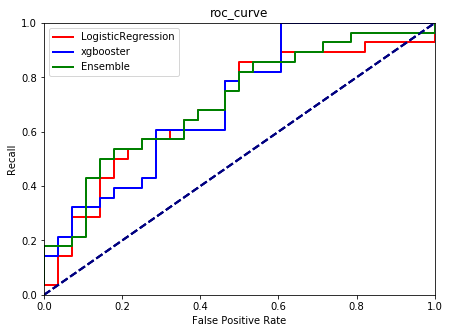

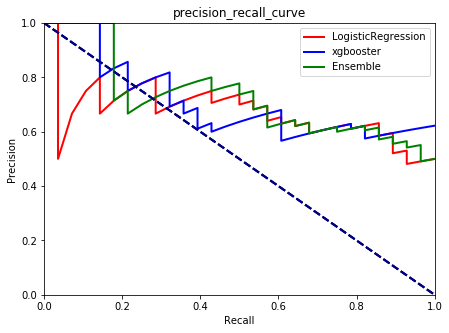

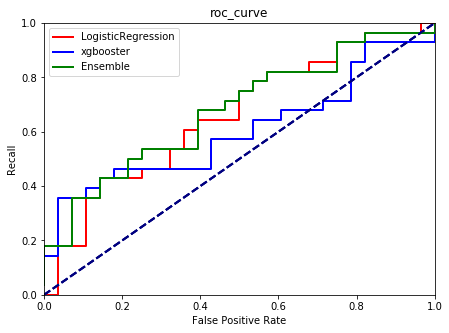

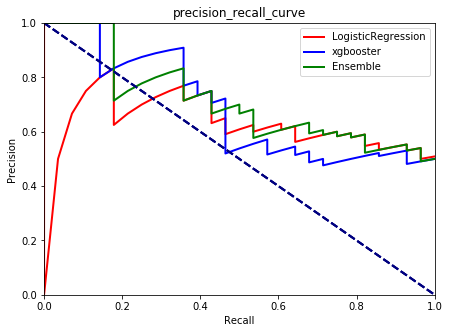

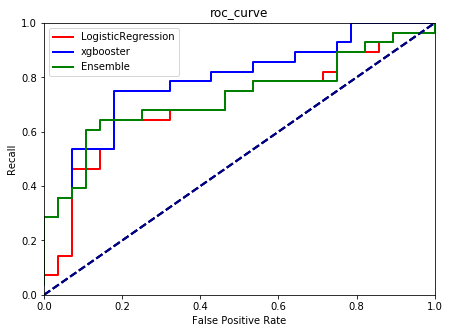

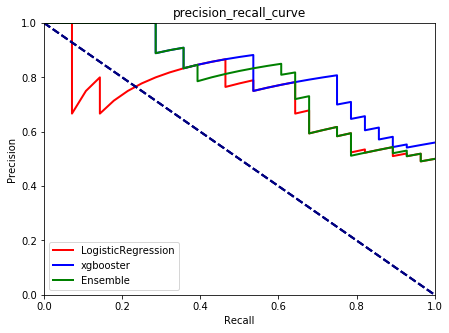

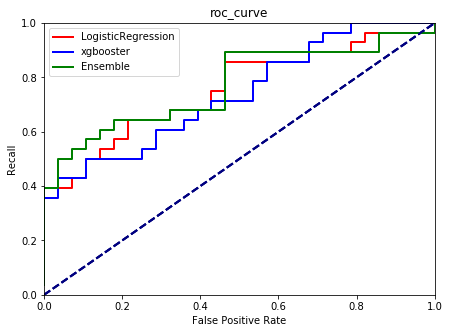

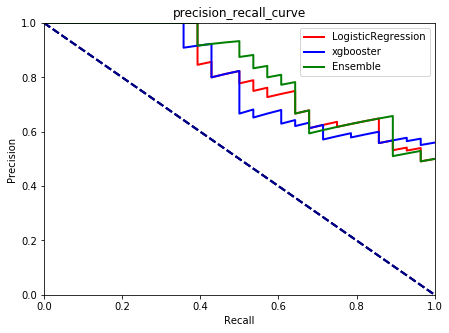

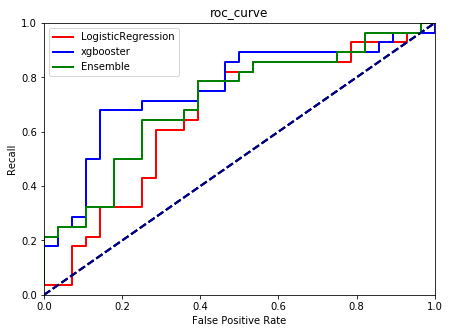

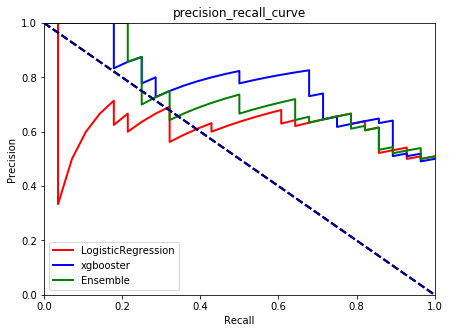

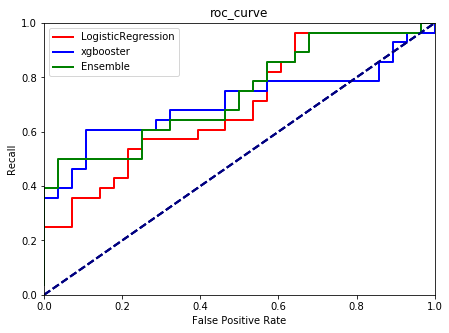

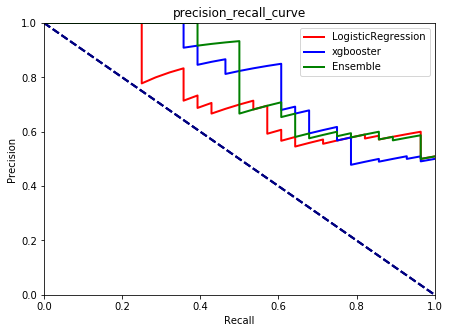

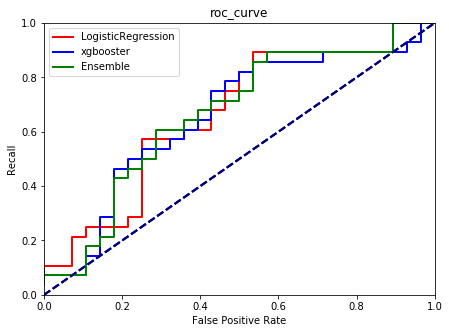

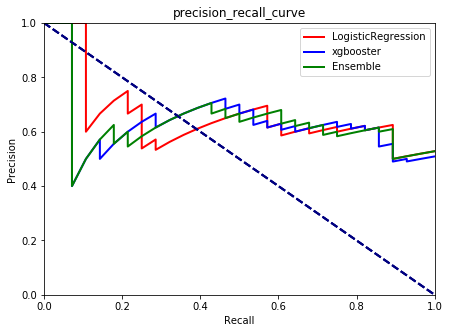

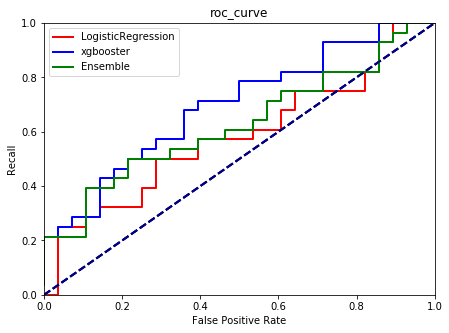

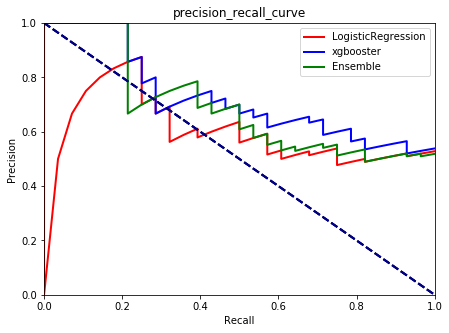

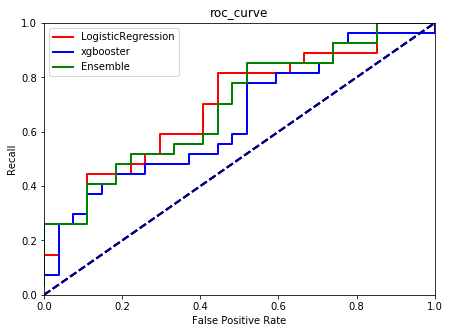

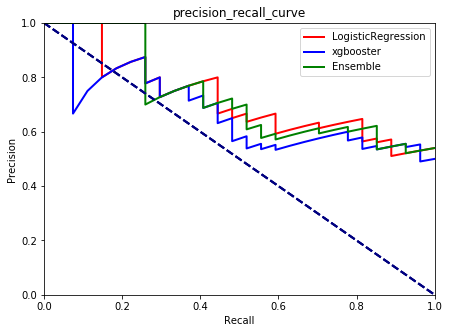

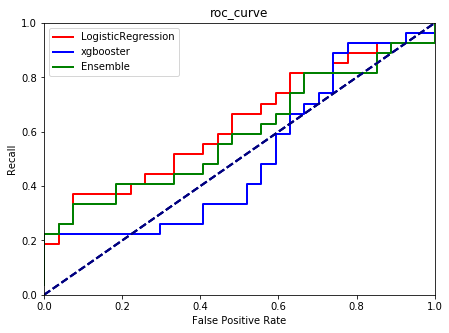

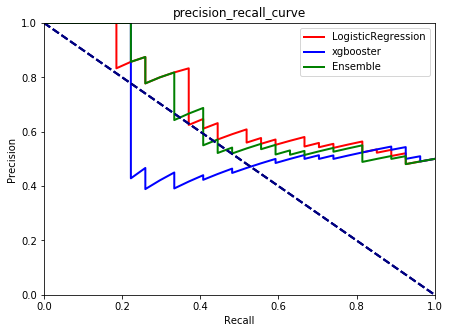

In [15]:
methods_cv = ['LogisticRegression','xgbooster']
if_hyperopt = True
if if_hyperopt:
    params_cv = get_hyperopt_params(methods_cv,wtf_lo=wtf_lo,wtf_hi=wtf_hi)
else:
    params_cv = get_search_params(methods=methods_cv)
tenfold_crossval_scores,model_combine_scores_cv,model_scores_cv,best_params_cv,pred_probs_cv,predicts_cv = cross_val_ensemble(total_x,total_label,total_sample_weights,methods_cv,params_cv,fold=10,hyperopt=if_hyperopt,up_sampling=up_sampling)
logger.info('10-fold CV of ensemble method results:\n '+tenfold_crossval_scores.to_string())

In [16]:
predicts_dtype = ['i8']*predicts_cv.shape[1]
probs_dtype = ['i8','f']+['f']*(pred_probs_cv.shape[1]-2)
for i,col in enumerate(predicts_cv.columns):
    predicts_cv[col] = predicts_cv[col].astype(predicts_dtype[i])
    pred_probs_cv[col] = pred_probs_cv[col].astype(probs_dtype[i])

In [17]:
avg_score_columns = ['ensemble']+methods_cv
avg_scores = {}
for method in avg_score_columns:
    avg_scores[method] = scores(predicts_cv['label'],predicts_cv[method],pred_probs_cv[method])

In [18]:
avg_scores

{'ensemble': {'auc': 0.6883054707313286,
  'recall': 0.2517985611510791,
  'precision': 0.8641975308641975,
  'accuracy': 0.6061151079136691,
  'f1': 0.3899721448467966},
 'LogisticRegression': {'auc': 0.6656358366544174,
  'recall': 0.7050359712230215,
  'precision': 0.5903614457831325,
  'accuracy': 0.6079136690647482,
  'f1': 0.6426229508196721},
 'xgbooster': {'auc': 0.6795455721753533,
  'recall': 0.16546762589928057,
  'precision': 0.92,
  'accuracy': 0.5755395683453237,
  'f1': 0.2804878048780488}}

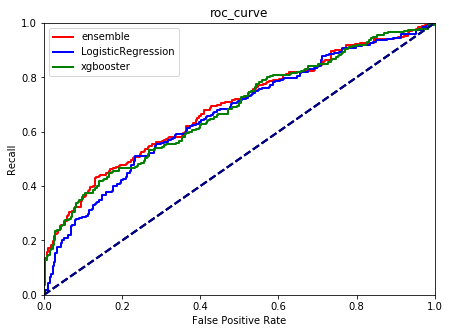

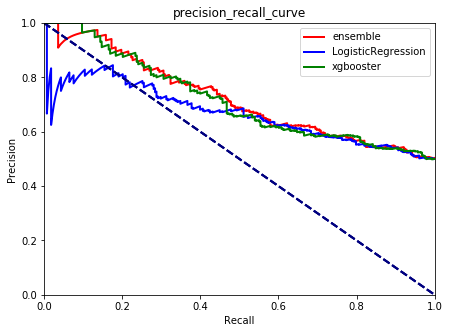

In [19]:
plot_curves_cv(pred_probs_cv.drop(['label'],axis=1),pred_probs_cv['label'],methods=['ensemble','LogisticRegression','xgbooster'])
plot_curves_cv(pred_probs_cv.drop(['label'],axis=1),pred_probs_cv['label'],methods=['ensemble','LogisticRegression','xgbooster'],types='precision_recall_curve')

In [20]:
tenfold_crossval_scores

logloss        f1    recall  precision  auc_score
0  0.751688  0.250000  0.142857   1.000000   0.709184
1  0.695827  0.378378  0.250000   0.777778   0.677296
2  0.634763  0.444444  0.285714   1.000000   0.728316
3  0.641178  0.486486  0.321429   1.000000   0.770408
4  0.671015  0.378378  0.250000   0.777778   0.711735
5  0.630834  0.526316  0.357143   1.000000   0.739796
6  0.755391  0.228571  0.142857   0.571429   0.664541
7  0.691844  0.410256  0.285714   0.727273   0.627551
8  0.672334  0.400000  0.259259   0.875000   0.692730
9  0.710863  0.363636  0.222222   1.000000   0.592593

In [21]:
 model_scores_cv

[{'LogisticRegression': (0.6663378852097431,
   0.6274509803921569,
   0.5714285714285714,
   0.6956521739130435,
   0.6900510204081632),
  'xgbooster': (1.8346766323250319,
   0.19354838709677416,
   0.10714285714285714,
   1.0,
   0.7091836734693877)},
 {'LogisticRegression': (0.671506064469264,
   0.6451612903225806,
   0.7142857142857143,
   0.5882352941176471,
   0.6581632653061225),
  'xgbooster': (1.9481522204997808,
   0.19354838709677416,
   0.10714285714285714,
   1.0,
   0.6033163265306123)},
 {'LogisticRegression': (0.6408533200695502,
   0.6774193548387097,
   0.75,
   0.6176470588235294,
   0.7040816326530612),
  'xgbooster': (1.5144495864406053,
   0.35294117647058826,
   0.21428571428571427,
   1.0,
   0.7946428571428572)},
 {'LogisticRegression': (0.6264856637765591,
   0.6956521739130435,
   0.8571428571428571,
   0.5853658536585366,
   0.7538265306122449),
  'xgbooster': (1.5278933453235888,
   0.25,
   0.14285714285714285,
   1.0,
   0.7372448979591836)},
 {'Logisti

In [41]:
best_params_cv

[{'LogisticRegression': {'C': 9.968285704604547,
   'class_weight': None,
   'dual': False,
   'fit_intercept': True,
   'intercept_scaling': 1,
   'max_iter': 100,
   'multi_class': 'ovr',
   'n_jobs': 1,
   'penalty': 'l2',
   'random_state': None,
   'solver': 'liblinear',
   'tol': 0.0001,
   'verbose': 0,
   'warm_start': False,
   'weight_factor': 0.46821851286368843},
  'RandomForestClassifier': {'bootstrap': True,
   'class_weight': None,
   'criterion': 'gini',
   'max_depth': 13,
   'max_features': 'auto',
   'max_leaf_nodes': None,
   'min_impurity_decrease': 0.0,
   'min_impurity_split': None,
   'min_samples_leaf': 5,
   'min_samples_split': 7,
   'min_weight_fraction_leaf': 0.0,
   'n_estimators': 983,
   'n_jobs': -1,
   'oob_score': False,
   'random_state': None,
   'verbose': 0,
   'warm_start': False,
   'weight_factor': 0.47579352095259553},
  'LinearSVC': {'base_estimator__C': 1.1061303169427354,
   'base_estimator__class_weight': None,
   'base_estimator__dual': F

In [52]:
model_combine_scores_cv

[{'LogisticRegression': {'auc': 0.5927524856096285,
   'recall': 0.03571428571428571,
   'precision': 0.08333333333333333,
   'accuracy': 0.8737541528239202,
   'f1': 0.05},
  'RandomForestClassifier': {'auc': 0.727891156462585,
   'recall': 0.03571428571428571,
   'precision': 1.0,
   'accuracy': 0.9102990033222591,
   'f1': 0.0689655172413793},
  'LinearSVC': {'auc': 0.6047880690737834,
   'recall': 0.0,
   'precision': 0.0,
   'accuracy': 0.8737541528239202,
   'f1': 0.0},
  'xgbooster': {'auc': 0.6832810047095761,
   'recall': 0.14285714285714285,
   'precision': 0.4,
   'accuracy': 0.9003322259136213,
   'f1': 0.21052631578947364},
  'LogisticRegression-RandomForestClassifier': {'auc': 0.6822344322344323,
   'recall': 0.0,
   'precision': 0.0,
   'accuracy': 0.893687707641196,
   'f1': 0.0},
  'LogisticRegression-LinearSVC': {'auc': 0.6002093144950288,
   'recall': 0.0,
   'precision': 0.0,
   'accuracy': 0.8704318936877077,
   'f1': 0.0},
  'LogisticRegression-xgbooster': {'auc':

In [50]:
log_xgb_cores = [x['LogisticRegression-xgbooster'] for x in model_combine_scores_cv]

In [51]:
log_xgb_cores

[{'auc': 0.6762166405023547,
  'recall': 0.03571428571428571,
  'precision': 0.09090909090909091,
  'accuracy': 0.8770764119601329,
  'f1': 0.05128205128205127},
 {'auc': 0.6072736787022501,
  'recall': 0.21428571428571427,
  'precision': 0.375,
  'accuracy': 0.893687707641196,
  'f1': 0.2727272727272727},
 {'auc': 0.7272370486656201,
  'recall': 0.21428571428571427,
  'precision': 0.5454545454545454,
  'accuracy': 0.9102990033222591,
  'f1': 0.30769230769230765},
 {'auc': 0.750130821559393,
  'recall': 0.17857142857142858,
  'precision': 0.4166666666666667,
  'accuracy': 0.9003322259136213,
  'f1': 0.25},
 {'auc': 0.7450287807430664,
  'recall': 0.17857142857142858,
  'precision': 0.5,
  'accuracy': 0.9069767441860465,
  'f1': 0.2631578947368421},
 {'auc': 0.7035583464154893,
  'recall': 0.21428571428571427,
  'precision': 0.6666666666666666,
  'accuracy': 0.9169435215946844,
  'f1': 0.3243243243243243},
 {'auc': 0.6376242804814234,
  'recall': 0.10714285714285714,
  'precision': 0.33

In [9]:
###parallel hyperparameter tuning, run call-opts.sh first!!
methods = ['RandomForestClassifier','SVC','xgbooster','LogisticRegression','tensor_DNN']
paralle_ensemble = pe.Ensemble(methods=methods,dataset=dataset)
paralle_ensemble.fit(train_x,train_label,sample_weights_train)
pred = paralle_ensemble.predict(test_x)
print("predicted number of positives: {}".format((pred==1).sum()))
pred_probs = paralle_ensemble.predict_proba(test_x)
score = scores(test_label,pred,pred_probs[:,1])
score

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 2.4494612503464697, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 1, 'missing': None, 'n_estimators': 2945, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 31.483980738185856, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
Tensor("IteratorGetNext:32", shape=(?,), dtype=float64)


Ensemble(dataset='RICHS/', home='/home/ec2-user/CpGPython/',
     methods=['RandomForestClassifier', 'SVC', 'xgbooster', 'LogisticRegression', 'tensor_DNN'])

Error analysis of  Ensemble


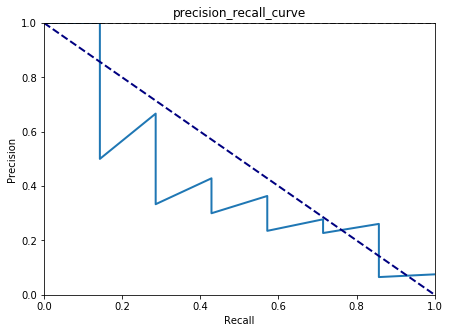

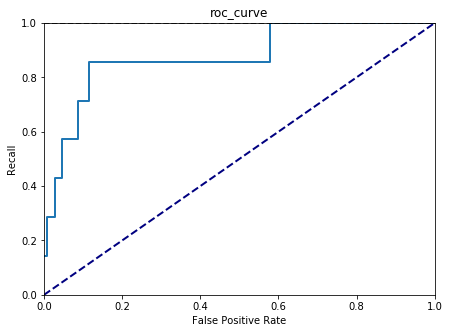

In [8]:
error_analysis(paralle_ensemble,test_x,test_label,types=['roc_curve','precision_recall_curve'])

In [7]:
pred  = paralle_ensemble.predict(test_x)

In [8]:
(pred==1).sum()

5

In [11]:
(test_label==1).sum()

28

In [11]:
pred  = ensemble_hyopt.predict(test_x)

NameError: name 'ensemble_hyopt' is not defined

In [14]:
(pred==1).sum()

16

In [10]:
test_label[test_label==1]

1409    1.0
310     1.0
711     1.0
1387    1.0
780     1.0
1435    1.0
1112    1.0
Name: label, dtype: float64

In [11]:
pred = pd.Series(pred,index=test_label.index)
pred[pred==1]

1165    1
594     1
1409    1
1071    1
1051    1
323     1
1401    1
711     1
590     1
1387    1
1367    1
1112    1
1328    1
1052    1
dtype: int64

In [17]:
for name,estimator in paralle_ensemble.best_estimators_.items():
    print (name)
    print(estimator.get_params())

RandomForestClassifier
{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 22, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 14, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
SVC
{'C': 0.8503159745629552, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.9907149182024338, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
xgbooster
{'gamma': 1.0645963553736928, 'learning_rate': 0.1, 'max_depth': 14, 'n_estimators': 1321, 'reg_lambda': 98.90305955429349, 'objective': 'binary:logistic'}
tensor_DNN
{'batch_normalization': True, 'batch_size': 30, 'drop_out': 0.4911329436304148, 'hidden_layers': (640, 480, 320, 160), 'l2_reg': 1.3217

In [7]:
ensemble.best_params_

{'LogisticRegression': {'C': 10.0, 'class_weight': {0: 1, 1: 30}},
 'MLPClassifier': {'alpha': 1.1888888888888891,
  'hidden_layer_sizes': (300, 200, 100),
  'max_iter': 3000},
 'RandomForestClassifier': {'class_weight': {0: 1, 1: 30},
  'max_depth': 10,
  'min_samples_leaf': 1,
  'min_samples_split': 5},
 'SVC': {'C': 0.057500000000000002,
  'class_weight': {0: 1, 1: 30},
  'gamma': 0.12575,
  'probability': True},
 'xgbooster': {'class_weight': {0: 1, 1: 30},
  'gamma': 2.3111111111111109,
  'learning_rate': 0.1,
  'max_depth': 17,
  'n_estimators': 2000,
  'reg_lambda': 11.888888888888889}}

In [12]:
all_estimators = list(paralle_ensemble.best_estimators_.values())
all_estimators.extend([paralle_ensemble])

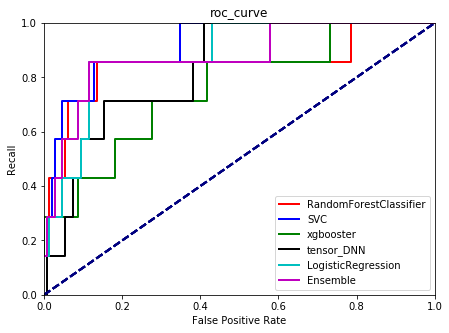

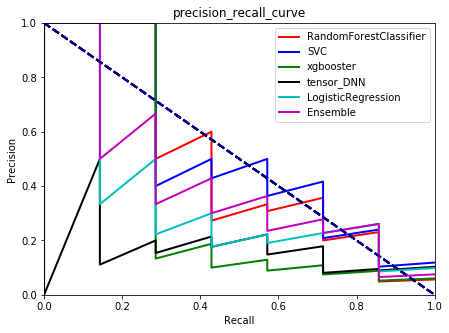

In [13]:
plot_curves(all_estimators,test_x,test_label,types='roc_curve')
plot_curves(all_estimators,test_x,test_label,types='precision_recall_curve')


Error analysis of  RandomForestClassifier


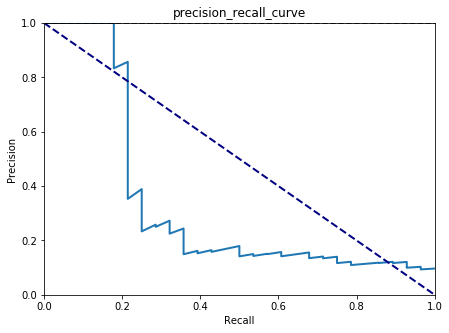

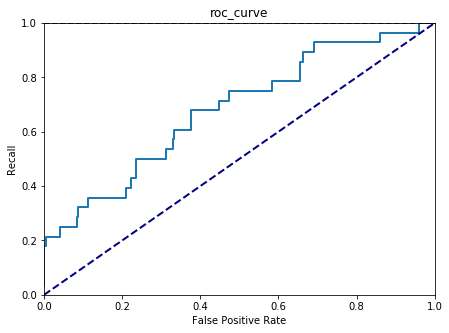

Error analysis of  SVC


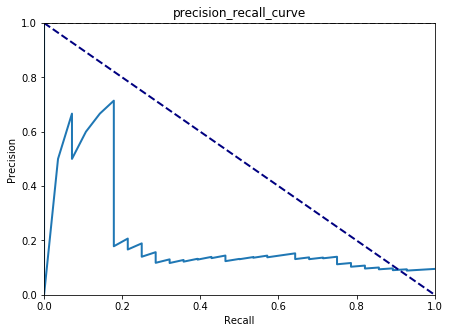

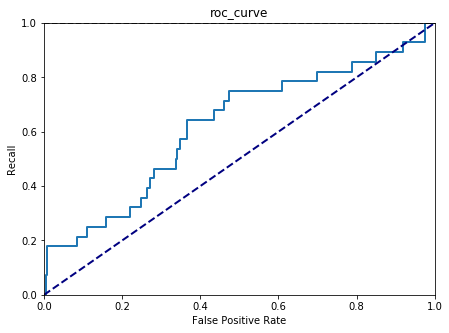

Error analysis of  xgbooster


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


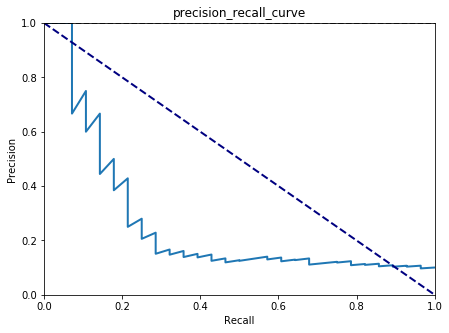

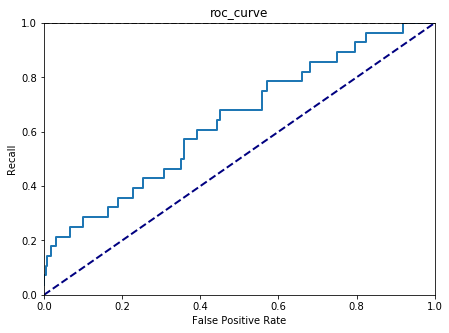

Error analysis of  LogisticRegression


/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


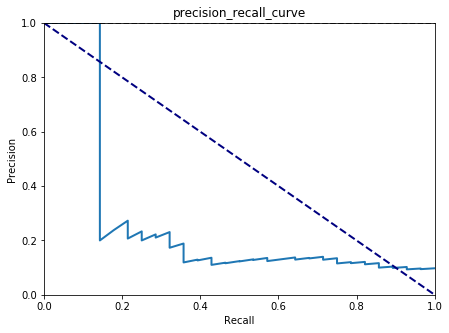

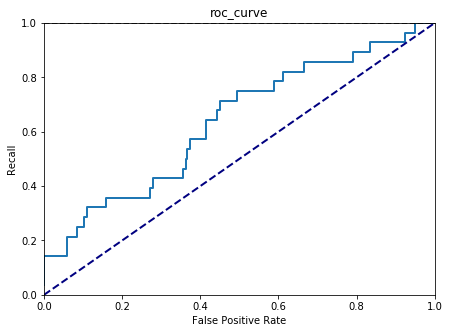

Error analysis of  MLPClassifier


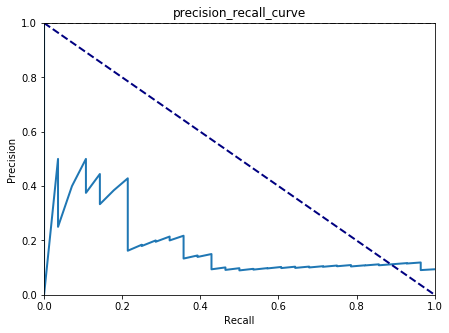

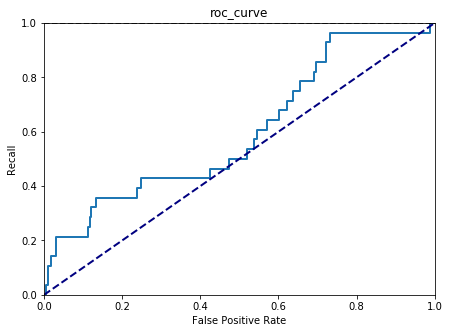

/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Error analysis of  tensor_DNN


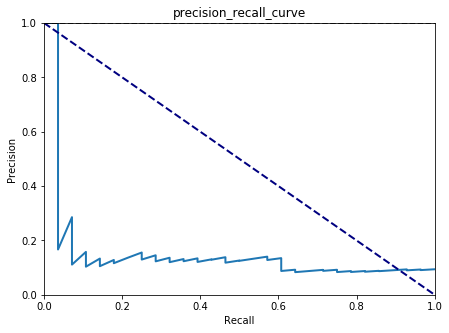

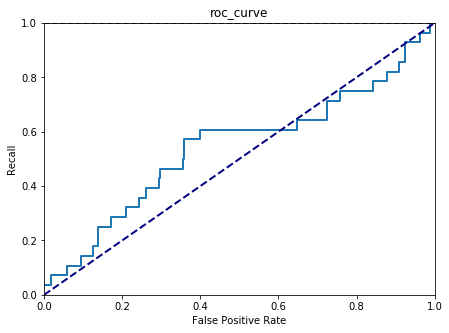

In [12]:
score_map={}
for name,estimator in paralle_ensemble.best_estimators_.items():
    #learn_curve(estimator,train_x,train_label,scoring='precision')
    error_analysis(estimator,test_x,test_label,types=['roc_curve','precision_recall_curve'])
    estimator_preds = estimator.predict(test_x)
    estimator_pred_probs = estimator.predict_proba(test_x)
    score_map[name] = scores(test_label,estimator_preds,estimator_pred_probs)
    
for name,score in score_map.items():
    logger.info('%s model in ensemble has scores: \n'+str(score),name)

In [13]:
for k in score_map:
    print('scores of '+k)
    print(score_map[k])

scores of RandomForestClassifier
{'auc': 0.5535714285714286, 'recall': 0.10714285714285714, 'precision': 1.0, 'accuracy': 0.9169435215946844, 'f1': 0.19354838709677416}
scores of SVC
{'auc': 0.5837912087912088, 'recall': 0.17857142857142858, 'precision': 0.625, 'accuracy': 0.9136212624584718, 'f1': 0.2777777777777778}
scores of xgbooster
{'auc': 0.5746336996336997, 'recall': 0.17857142857142858, 'precision': 0.38461538461538464, 'accuracy': 0.8970099667774086, 'f1': 0.24390243902439027}
scores of LogisticRegression
{'auc': 0.5494505494505495, 'recall': 0.14285714285714285, 'precision': 0.25, 'accuracy': 0.8803986710963455, 'f1': 0.18181818181818182}
scores of MLPClassifier
{'auc': 0.5, 'recall': 0.0, 'precision': 0.0, 'accuracy': 0.9069767441860465, 'f1': 0.0}
scores of tensor_DNN
{'auc': 0.5, 'recall': 0.0, 'precision': 0.0, 'accuracy': 0.9069767441860465, 'f1': 0.0}
